# Some CSD Issues

## Last updated by Qiang Zhu on 2021/09/16

In [2]:
import warnings
warnings.filterwarnings('ignore')

# creates driver that handles crystal structure database entries
from ccdc import io
csd_reader=io.EntryReader('CSD') 
print("Total number of Entries", len(csd_reader))

Total number of Entries 1135968


In [11]:
# Some simple filters

def good_formula(formula):
    for ele in ['Li', 'Na', 'K', 'Mg', 'Ca', 'Rb', 'Cs', 'Ba', 'Be', 'Sr', 'Fe', 'Pt', 'B', 'Si']:
        if formula.find(ele)>-1:
            return False
    if formula.find(')n') > -1: #polymers
        return False
    else:
        return True
    
def good_entry(entry):
    mol = entry.molecule
    ccdc = entry.ccdc_number
    formula = entry.formula
    good = False
    if ccdc is not None and formula.find(',')==-1 and mol.is_organic:
        if good_formula(formula):
            good = True
    return good

/Users/qiangzhu/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 1. Check if the entry is truly organic from formula
A lot of entries are assigned to be organic but they have metals

In [6]:
for i in range(500):
    entry = csd_reader[i]
    mol = entry.molecule
    ccdc = entry.ccdc_number
    formula = entry.formula
    if ccdc is not None and mol.is_organic:
        if not good_formula(formula):
            print(i, ccdc, entry.identifier, formula)

98 244156 ABAGEQ C42 H82 Ca2 N2 O4 Si4
101 244157 ABAGIU C44 H52 K4 O4,4(C7 H8)
104 244158 ABAGOA C22 H62 Ca1 K1 N3 O1 Si6
106 244159 ABAGUG C74 H94 Ca2 K2 O8
110 244160 ABAHAN C60 H84 Ca1 K2 O8
178 216488 ABAMEW C108 H132 Li4 N4 P4,3(C5 H12)
200 793605 ABANID C64 H88 Mg2 N4


# 2. Entries which are not single components 
But they are labeled to be have only one component

In [7]:
for i in range(4000, 5000):
    entry = csd_reader[i]
    mol = entry.molecule
    ccdc = entry.ccdc_number
    formula = entry.formula
    if not entry.has_disorder and ccdc is not None and mol.is_organic and good_formula(formula) and len(mol.components)==1:
        if formula.find(',') > -1:
            print(i, ccdc, entry.identifier, formula)
            url = "https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid="
            url += entry.identifier
            print(url)
            break

4184 1100836 ACNCSL10 C28 H37 Br1 O8 S1,H2 O1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ACNCSL10


# 3. Incorrect Assignments of Smiles Strings

/Users/qiangzhu/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AFOMOX
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AFOMOX
CSD: Cc1cc(C)cc(c1)N1C(=O)c2ccc3c4ccc5C(=O)N(c6cc(C)cc(C)c6)C(#O)c6ccc(c7ccc(C1=O)c2c37)c4c56
NEW: Cc1cc(C)cc(c1)N1C(=O)c2ccc3c4ccc5C(=O)N(c6cc(C)cc(C)c6)C(=O)c6ccc(c7ccc(C1=O)c2c37)c4c56


RDKit ERROR: [10:06:11] Explicit valence for atom # 30 C, 5, is greater than permitted


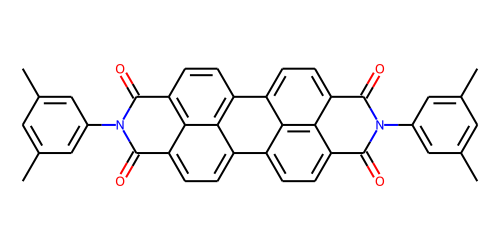

In [5]:
# Some temporary fixes
fixes = [
    ([9301], "Cc1cc(C)cc(c1)N1C(=O)c2ccc3c4ccc5C(=O)N(c6cc(C)cc(C)c6)C(=O)c6ccc(c7ccc(C1=O)c2c37)c4c56"),
    ([12865], "C1=C[N+](=O)C=CN1[O-]"),
    ([56700], "C1(=NC2=NC(=N[N+]#N)N=C3N2C(=NC(=N3)N=[N+]=[N-])[N-]1)N=[N+]=[N-]"),
    ([183136], "CC1=C([N+](=O)C2=CC=CC=C2N1[O-])C(C)C"), 
    ([192316], "O=P(O)(O)CCP(=O)(O)O"),
    ([205931], "COC1=CC=C(C=C1)C(=[N+]=[N-])C2=CC=C(C=C2)OC"),
    ([215685], "CCCCCCCCCCC1=CC=C(C=C1)[N+]#[C-]"),
    ([275059], "CC(C)(C)N([N+](=O)C(C)(C)C)[O-]"),
    ([282364], "CC(C)C1=C(C(=CC=C1)C(C)C)N2C=CN([CH]2)P(C(C)(C)C)C(C)(C)C"),
    ([283837], "CC2=[n+]1c(=O)[n-]c(=O)n1C(C)C2C"),
]

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.molSize = 500,250

for fix in fixes[:1]:
    for id in fix[0]:
        entry = csd_reader[id]
        mol = entry.molecule
        if mol.smiles is not None:
            sm1 = mol.smiles
            sm2 = fix[1]
            print(entry.identifier)
            url = "https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid="
            url += entry.identifier
            print(url)
            print("CSD:", sm1)
            print("NEW:", sm2)
            m1 = Chem.MolFromSmiles(sm1)
            m2 = Chem.MolFromSmiles(sm2)
            break
m1
m2

In [13]:
# Here is a short routine to find the entries which 
# 1, do not missing smiles or
# 2, has a smiles string that cannot be interpreted by rdkit

for i in range(1000000): 
    entry=csd_reader[i]
    if good_entry(entry):
        smi = entry.molecule.smiles
        url = "https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid="
        url += entry.identifier
        if smi is not None:
            #print(url)
            #print("Missing Smiles: ", i, entry.identifier)
        #else:
            m = Chem.MolFromSmiles(smi) 
            if m is None:
                print(url)
                print("Bad Smiles: ", i, entry.identifier, smi)
                #break

/Users/qiangzhu/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
RDKit ERROR: [10:14:48] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ADOJAG
Bad Smiles:  6956 ADOJAG CON=C(CCC(=O)C(=N=[N])C(=O)OC)c1ccc(Cl)cc1


RDKit ERROR: [10:14:58] Explicit valence for atom # 7 Cl, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AFELUS
Bad Smiles:  8432 AFELUS C[P](C)(C)[As]1(Cl)(Cl)Cl[As](Cl)(Cl)(Cl1)[P](C)(C)C.C[P](C)(C)[As]1(Cl)(Cl)Cl[As](Cl)(Cl)(Cl1)[P](C)(C)C


RDKit ERROR: [10:15:03] Explicit valence for atom # 30 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AFOMOX
Bad Smiles:  9301 AFOMOX Cc1cc(C)cc(c1)N1C(=O)c2ccc3c4ccc5C(=O)N(c6cc(C)cc(C)c6)C(#O)c6ccc(c7ccc(C1=O)c2c37)c4c56


RDKit ERROR: [10:15:06] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AFUVAA
Bad Smiles:  9900 AFUVAA CN1C(=[N-]c2ccccc12)[PH+](c1ccccc1)c1ccccc1


RDKit ERROR: [10:15:08] Explicit valence for atom # 25 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AGAMIG
Bad Smiles:  10203 AGAMIG CCOC1=CC=CC(=Nc2cc(C)c(C)cc2N(c2c(cc(c3NON(=O)c23)N(=O)=O)N(=O)=O)S(=O)(=O)Cc2ccccc2)C2=C(C)OC(=C12)C


RDKit ERROR: [10:15:08] Can't kekulize mol.  Unkekulized atoms: 15 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AGAPIK
Bad Smiles:  10242 AGAPIK Cc1cccc(C)c1c1cccc(c1[c+]1c([O-])[c+](c1[O-])c1c(cccc1c1c(C)cccc1C)c1c(C)cccc1C)c1c(C)cccc1C


RDKit ERROR: [10:15:24] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AHEMAB
Bad Smiles:  12865 AHEMAB O=N1C=CN(=O)C=C1


RDKit ERROR: [10:15:34] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:15:34] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AHUQID
Bad Smiles:  14241 AHUQID CCOC(=O)C(=N=[N])C(NC(=O)C(Cl)(Cl)Cl)C=Cc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AHUQID01
Bad Smiles:  14242 AHUQID01 CCOC(=O)C(=N=[N])C(NC(=O)C(Cl)(Cl)Cl)C=Cc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AHUQOJ
Bad Smiles:  14245 AHUQOJ CCOC(=O)C(=N=[N])C(CC)NC(=O)C(Cl)(Cl)Cl.CCOC(=O)C(=N=[N])C(CC)NC(=O)C(Cl)(Cl)Cl


RDKit ERROR: [10:15:38] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AJAWUD
Bad Smiles:  14819 AJAWUD [O]N(=Cc1ccccc1CCN=Nc1ccccc1)c1ccccc1


RDKit ERROR: [10:15:41] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:15:41] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AJEROY
Bad Smiles:  15153 AJEROY Cc1ccncc1C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AJERUE
Bad Smiles:  15157 AJERUE Cc1ccncc1C1=N([O])C2(CCCC2)C2(CCCC2)N1[O]


RDKit ERROR: [10:15:45] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AJITOC
Bad Smiles:  15630 AJITOC CC1=C(N=CN1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:15:46] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:15:46] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:15:46] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [10:15:46] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AJIYAT
Bad Smiles:  15701 AJIYAT CC1(C)N([O])C(=N([O])C1(C)C)c1ccncc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AJIYAT01
Bad Smiles:  15702 AJIYAT01 CC1(C)N(=C(c2ccncc2)N(=O)C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AJIYUO01
Bad Smiles:  15720 AJIYUO01 CC(C)c1cccc(C(C)C)c1N1C=CN(=C1[As][As]C1=N(C=CN1c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AJIZAV01
Bad Smiles:  15725 AJIZAV01 CC(C)c1cccc(C(C)C)c1N1C=CN(=C1[As](Cl)(Cl)Cl)c1c(cccc1C(C)C)C(C)C


RDKit ERROR: [10:15:48] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AJONUI
Bad Smiles:  15970 AJONUI CN1C(=NN=C1C1=N([O])C(C)(C)C(C)(C)N1[O])C


RDKit ERROR: [10:15:53] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AKAWIS
Bad Smiles:  16738 AKAWIS CC1(C)NC(=N([O])C1(C)C)C1=CNC=N1


RDKit ERROR: [10:15:57] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:15:57] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AKIZEA
Bad Smiles:  17380 AKIZEA Cc1cc(C)c(c(C)c1)N(C)=C=N(C)c1c(C)cc(C)cc1C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AKIZIE
Bad Smiles:  17384 AKIZIE CC(C)c1cccc(C(C)C)c1N(C)=C=N(C)c1c(cccc1C(C)C)C(C)C


RDKit ERROR: [10:16:03] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ALASUC
Bad Smiles:  18304 ALASUC CC1(C)N([O])C(=N([O])C1(C)C)c1c(F)ccc(F)c1F.CC1(C)N([O])C(=N([O])C1(C)C)c1c(F)ccc(F)c1F


RDKit ERROR: [10:16:16] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [10:16:16] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [10:16:16] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AMELIO
Bad Smiles:  20456 AMELIO CC(O)(c1ccccc1)c1ccccn1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AMELOU
Bad Smiles:  20459 AMELOU CC(O)(c1ccccn1[O])C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AMELUA
Bad Smiles:  20461 AMELUA [O]n1ccccc1C(=C)c1ccccc1


RDKit ERROR: [10:16:45] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:16:45] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:16:45] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AQIJUF
Bad Smiles:  25330 AQIJUF CC1(C)N([O])C(=N([O])C1(C)C)N1C=NC=N1.CC1(C)N([O])C(=N([O])C1(C)C)N1C=NC=N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AQIKAM
Bad Smiles:  25332 AQIKAM CC1(C)N([O])C(=N([O])C1(C)C)N1N=Nc2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AQIKOA
Bad Smiles:  25339 AQIKOA CC1(C)N([O])C(=N([O])C1(C)C)N1C=CN=C1


RDKit ERROR: [10:17:06] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ASCTMA
Bad Smiles:  28109 ASCTMA CN(C)(C)[As](Cl)(Cl)Cl


RDKit ERROR: [10:17:12] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ASOFIX
Bad Smiles:  28820 ASOFIX CC(C)(C)OC(=O)C1(C)CCC=N1[O]


RDKit ERROR: [10:17:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ASOKUP
Bad Smiles:  28895 ASOKUP [O]n1ccccc1C(=O)C1C(ON(C1c1ccccc1)c1ccccc1)C1=CC=CS1


RDKit ERROR: [10:17:16] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:17:16] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ATAGAD
Bad Smiles:  29548 ATAGAD CN1(C)Cc2ccccc2[Te]1Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ATAGAD01
Bad Smiles:  29549 ATAGAD01 CN1(C)Cc2ccccc2[Te]1Cl


RDKit ERROR: [10:17:38] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AVUNUB
Bad Smiles:  32612 AVUNUB [H]1OC(=CC(=O1)C=Cc1c2ccccc2cc2ccccc12)C=Cc1c2ccccc2cc2ccccc12


RDKit ERROR: [10:17:41] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AWATIB
Bad Smiles:  32956 AWATIB OC(=O)c1ccc(C(O)=O)c(c1)C1=[NH]c2ccccc2N1


RDKit ERROR: [10:17:55] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AXIQAA
Bad Smiles:  35147 AXIQAA [O]n1ccc(cc1)c1ccccn1


RDKit ERROR: [10:18:03] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:18:03] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AYEMIC
Bad Smiles:  36390 AYEMIC CCOC(=O)C(=N=[N])C(N1CCOCC1)c1ccccc1C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AYEMOI
Bad Smiles:  36393 AYEMOI CCOC(=O)C(=N=[N])C(N1CCOCC1)c1ccccc1Cl


RDKit ERROR: [10:18:09] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AYUYIC
Bad Smiles:  37459 AYUYIC CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2cc3ccccc3cc2N1


RDKit ERROR: [10:18:12] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [10:18:12] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AZEHET
Bad Smiles:  37941 AZEHET CC(C)C1(C)N(C)C(=O)C=N1[O].CC(C)C1(C)N(C)C(=O)C=N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AZEHOD
Bad Smiles:  37946 AZEHOD CN1C(=O)C=N([O])C21CCCCC2


RDKit ERROR: [10:18:17] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=AZTROP
Bad Smiles:  39047 AZTROP [N]=N=NC1=CC(=O)C=CC=C1


RDKit ERROR: [10:18:20] Explicit valence for atom # 34 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BABHUH
Bad Smiles:  39520 BABHUH CC(=O)OCC1OC(OC2OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C2OC(C)=O)C(N=N=[N])C(OCc2ccccc2)C1OCc1ccccc1


RDKit ERROR: [10:18:25] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BACTUV
Bad Smiles:  40274 BACTUV COC(=O)C(O)C1CCC2CC(=N([O])C12C)OC1CCCCC1c1ccccc1


RDKit ERROR: [10:18:29] Explicit valence for atom # 11 F, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BAFLIG
Bad Smiles:  41113 BAFLIG C[N+]1=CN(C=C1)P(F)(F)(F)(F)[F-]


RDKit ERROR: [10:18:38] Explicit valence for atom # 7 Te, 7, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BAJTUB
Bad Smiles:  42685 BAJTUB CN(CCO)C1=[S][Te]23(SC#N)(S1)(SC(=[S]2)N(C)CCO)SC(=[S]3)N(C)CCO


RDKit ERROR: [10:18:45] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [10:18:45] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:18:45] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BAMPOW
Bad Smiles:  43886 BAMPOW CC(C)(C)C#Cc1cc(cc(c1)C(=N=[N])c1ccncc1)C(=N=[N])c1ccncc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BAMQAJ
Bad Smiles:  43895 BAMQAJ CC1(C)N([O])C(=N([O])C1(C)C)C#CC#CC1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BAMQAJ01
Bad Smiles:  43896 BAMQAJ01 CC1(C)N([O])C(=N([O])C1(C)C)C#CC#CC1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:18:48] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BANNEL
Bad Smiles:  44296 BANNEL CC1=C(C(=O)NN)N(=CN1Cc1ccccc1)[O]


RDKit ERROR: [10:18:49] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BANZAT
Bad Smiles:  44492 BANZAT COC1(OC)C2CC(C)C(C1=O)C(CO)(C2)N(O)=O.COC1(OC)C2CC(C)C(C1=O)C(CO)(C2)N(O)=O


RDKit ERROR: [10:18:52] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BAPSOD
Bad Smiles:  44854 BAPSOD CC1(C)N([O])C(=N([O])C1(C)C)C1=CC=C(N1)C=O


RDKit ERROR: [10:19:00] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BARQAM
Bad Smiles:  45714 BARQAM CC(=O)OCC1OC(OCC(CN=N=[N])N=N=[N])C(OC(C)=O)C(OC(C)=O)C1OC(C)=O


RDKit ERROR: [10:19:04] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BATJUC
Bad Smiles:  46493 BATJUC Cc1cc(C=NO)c2SN(=Cc2c1)[O]


RDKit ERROR: [10:19:08] Explicit valence for atom # 3 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BAVQEV
Bad Smiles:  47031 BAVQEV C1CCO(C1)[Te]1234Cl[Te]56(Cl[Te](Cl1)(N=S=N5)(N=S=N2)(N36)O1CCCC1)N=S=N4


RDKit ERROR: [10:19:09] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BAWHEM01
Bad Smiles:  47316 BAWHEM01 n1snc2nsnc12


RDKit ERROR: [10:19:21] Explicit valence for atom # 9 S, 7, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEBJAU
Bad Smiles:  49514 BEBJAU COc1c2cccc3O[S](=Oc(c4C(=O)C=CC(=O)c14)c23)(=O)=O


RDKit ERROR: [10:19:22] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [10:19:22] Explicit valence for atom # 31 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEBLUR
Bad Smiles:  49575 BEBLUR COP123(OC)N4C5=CC=C4C(=C4C=CC(=C(c6ccccc6)C6=CC=C(N16)C(=C1C=CC5=N21)c1ccccc1)N34)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEBMAY
Bad Smiles:  49580 BEBMAY OP123(O)N4C5=CC=C4C(=C4C=CC(=C(c6ccc(Cl)cc6)C6=CC=C(N16)C(=C1C=CC5=N21)c1ccc(Cl)cc1)N34)c1ccc(Cl)cc1.OP123(O)N4C5=CC=C4C(=C4C=CC(=C(c6ccc(Cl)cc6)C6=CC=C(N16)C(=C1C=CC5=N21)c1ccc(Cl)cc1)N34)c1ccc(Cl)cc1


RDKit ERROR: [10:19:32] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEGDIB
Bad Smiles:  51212 BEGDIB CN1C(=[NH2])C2=C(N=CN2)N(C)C1=O


RDKit ERROR: [10:19:36] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEHWER
Bad Smiles:  51934 BEHWER COc1ccc(cc1)C1CC(C)(OC)ON(=C1C)[O]


RDKit ERROR: [10:19:41] Explicit valence for atom # 12 F, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEKRAM
Bad Smiles:  52737 BEKRAM CN1C=C[N+](=C1CP(F)(F)(F)(F)[F-])C


RDKit ERROR: [10:19:43] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:19:43] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:19:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:19:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:19:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:19:43] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:19:43] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BELPUD
Bad Smiles:  53141 BELPUD Cc1ccccc1N(=O)N(=O)c1ccccc1C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BELPUD01
Bad Smiles:  53142 BELPUD01 Cc1ccccc1N(=O)N(=O)c1ccccc1C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BELQUF
Bad Smiles:  53163 BELQUF CN1(C)Cc2ccccc2[Se]1N=[N+]=[N-]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BELRAM
Bad Smiles:  53167 BELRAM CN1(C)Cc2ccccc2[Se]1I
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BELRAM01
Bad Smiles:  53168 BELRAM01 CN1(C)Cc2ccccc2[Se]1I
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BELREQ
Bad Smiles:  53172 BELREQ CN1(C)Cc2ccccc2[Se]1Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BELREQ01
Bad Smiles:  53173 BELREQ01 CN1(C)Cc2ccccc2[Se]1Cl


RDKit ERROR: [10:19:46] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEMVOF01
Bad Smiles:  53701 BEMVOF01 CN1C=C(C=N1)C1=N([O])C(C)(C)C(C)(C)N1=O


RDKit ERROR: [10:20:04] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEVDAI
Bad Smiles:  56700 BEVDAI [N-]=[N+]=NC1=NC2=NC(=NC3=NC(=NC(=N23)[N]1)N=[N+]=[N-])N=[N+]=[N-]


RDKit ERROR: [10:20:08] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEWMOG
Bad Smiles:  57287 BEWMOG I[Se]1c2ccccc2C2=N1CCO2.I[Se]1c2ccccc2C2=N1CCO2


RDKit ERROR: [10:20:13] Explicit valence for atom # 19 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BEYQII
Bad Smiles:  58249 BEYQII COC(=NS(=O)C(C)(C)C)C(CCc1ccccc1)=N([O])c1ccccc1


RDKit ERROR: [10:20:36] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIGRUF
Bad Smiles:  61062 BIGRUF COC(=O)N1C(N(c2ccc(OC)cc2)C2=NC(=N([S]12)c1ccc(C)cc1)c1ccccc1)C(Cl)(Cl)Cl


RDKit ERROR: [10:20:38] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 20 21 22 23 24 25 26 27 28 29 30 31 36 37 38 39 40 41 46 47 48 49 50 51 52 53 54 55 56 57 62 63 64 65 66 67 72 73 74 75 76 77 78 79 80 81 82 83 88 89 90 91 92 93 98 99 100 101 102 103 104 105 106 107 108 109 114 115 116 117 118 119 124 125 126 127 128 129 130 131 132 133 134 135 140 141 142 143 144 145 150 151 152 153 154 155 156 157 158 159 160 161 166 167 168 169 170 171 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
RDKit ERROR: 
RDKit ERROR: [10:20:38] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [10:20:38] Explicit valence for atom # 8 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIHDAA
Bad Smiles:  61249 BIHDAA CC(C)(C)c1cc2cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc3cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc4cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc5cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc6cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc7cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc8cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc(cc2c1)c1cc2cc(c1)c1cc(cc8c1)c1cc(cc7c1)c1cc(cc6c1)c1cc(cc5c1)c1cc(cc4c1)c1cc2cc3c1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIHFAC
Bad Smiles:  61271 BIHFAC CC(=O)OI(OC(C)=O)(OC(C)=O)n1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIHFIK
Bad Smiles:  61280 BIHFIK Fc1c(F)c(F)c([I+]([O-]C(=O)C(F)(F)F)c2c(F)c(F)c(F)c(F)c2F)c(F)c1F


RDKit ERROR: [10:20:45] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIKFIN
Bad Smiles:  62212 BIKFIN [O]n1c(Cl)cccc1Cl


RDKit ERROR: [10:20:52] Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIMDUW10
Bad Smiles:  63047 BIMDUW10 [O]n1c2CCCC(Cl)c2nc2C(Cl)CCCc12


RDKit ERROR: [10:20:54] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIMZII
Bad Smiles:  63375 BIMZII CCCCC1C=CC(OO)C=C1C1=[NH]c2ccccc2C(=Nc2ccccc12)c1ccccc1


RDKit ERROR: [10:21:10] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8
RDKit ERROR: 
RDKit ERROR: [10:21:10] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:21:10] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BISTEC
Bad Smiles:  65204 BISTEC CN1c2cccccc2OC21C(=C[C](C=C2N(=O)=O)N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BISTIG
Bad Smiles:  65207 BISTIG CN1C2=CC=CC=CC2=N(C)C21C(=C[C](C=C2N(=O)=O)N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BISTIG01
Bad Smiles:  65208 BISTIG01 CN1C2=CC=CC=CC2=N(C)C21C(=C[C](C=C2N(=O)=O)N(=O)=O)N(=O)=O


RDKit ERROR: [10:21:17] Explicit valence for atom # 17 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIVFER
Bad Smiles:  65686 BIVFER NC(=O)C(Cc1ccc(O)c(c1)c1cc(CC(N#[C])C(N)=O)ccc1O)N#[C]


RDKit ERROR: [10:21:20] Explicit valence for atom # 20 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIVWAF
Bad Smiles:  65919 BIVWAF CCCCCC(=O)N1CCN(CC1)c1ccc(cc1)N=N([O])c1ccc(cc1)N1CCN(CC1)C(=O)CCCCC


RDKit ERROR: [10:21:30] Can't kekulize mol.  Unkekulized atoms: 20 21 24 25 26
RDKit ERROR: 
RDKit ERROR: [10:21:30] Can't kekulize mol.  Unkekulized atoms: 20 21 24 25 26
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIYMII
Bad Smiles:  67042 BIYMII CC(C)c1cccc(C(C)C)c1NC(=O)C1CCCN1c1cn([O])ccc1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BIYMOO
Bad Smiles:  67046 BIYMOO CC(C)c1cccc(C(C)C)c1NC(=O)C1CCCN1c1cn([O])ccc1N1CCCC1


RDKit ERROR: [10:21:50] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BOCYIC
Bad Smiles:  68870 BOCYIC CCN(N=N=C1S[N]c2ccc(cc12)N(=O)=O)c1ccc2ccccc2c1


RDKit ERROR: [10:21:56] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17 18 19
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BOFJIR
Bad Smiles:  69471 BOFJIR Fc1c(F)c(F)c(c2cc3cc(cc4cc(cc(c2)c34)c2c(F)c(F)c(F)c(F)c2F)c2c(F)c(F)c(F)c(F)c2F)c(F)c1F


RDKit ERROR: [10:22:37] Explicit valence for atom # 4 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BONHUH
Bad Smiles:  72558 BONHUH CC1=CC(=O[Te](Cl)(Cl)(Cl)C1)C


RDKit ERROR: [10:23:40] Explicit valence for atom # 31 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BOYTIT
Bad Smiles:  76711 BOYTIT CCCCCCCCOc1ccc(cc1)C(=O)Oc1ccc(OC(=O)c2ccc(NN=N([O])c3ccccc3)cc2)cc1


RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:24:11] WARNING: not r

https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BUFVAA
Bad Smiles:  79894 BUFVAA COC12OC3(O)C45OC64C4=C7C8=C9C%10=C%11C%12=C%13C%14=C%15C%16=C%17C%18=C%19C%20=C(OOC(C)(C)C)(C%21=C%22C%23=C%24C%25=C%26C(=C%12C%12=C%26C%26=C%24C(=C%20%22)C%18=C%26C%16=C%14%12)C%10=C8C%25=C%23C7=C6%21)C5=C5C63OC36C6=C1C(=C%11C%13=C6C%15=C3C%17=C%195OOC(C)(C)C)C9=C24


RDKit ERROR: [10:25:14] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BURXIW
Bad Smiles:  83819 BURXIW CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)c1nc(N)nc(N)n1


RDKit ERROR: [10:25:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BUWROC
Bad Smiles:  85370 BUWROC [O]n1nc2ccc3ccccc3c2c2c3ccccc3ccc12


RDKit ERROR: [10:25:30] Can't kekulize mol.  Unkekulized atoms: 6 7 9 11 12 13
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BUYDAA
Bad Smiles:  85928 BUYDAA c1ccc(cc1)p1(nsnsnp(n1)(c1ccccc1)c1ccccc1)c1ccccc1


RDKit ERROR: [10:25:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [10:25:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BZPRIA
Bad Smiles:  87156 BZPRIA O=C(OIn1ccccc1)c1ccccc1.O=C(OIn1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=BZPRIB
Bad Smiles:  87157 BZPRIB O=C(OIn1ccccc1)c1ccccc1C(=O)OIn1ccccc1


RDKit ERROR: [10:25:36] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:25:37] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CABJAS
Bad Smiles:  87490 CABJAS CN([O])=C1C(=O)Nc2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CABKEX
Bad Smiles:  87514 CABKEX [O]N(Cc1ccccc1)=CC1COC2(CCCCC2)O1


RDKit ERROR: [10:25:43] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:25:43] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:25:43] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:25:43] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAFCUK
Bad Smiles:  88819 CAFCUK CC1(C)N([O])C(C)(C)N(=C1C1=N([O])C(C)(C)C(C)(C)N1[O])[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAFCUK01
Bad Smiles:  88820 CAFCUK01 CC1(C)N([O])C(C)(C)N(=C1C1=N([O])C(C)(C)C(C)(C)N1[O])[O].CC1(C)N([O])C(C)(C)N(=C1C1=N([O])C(C)(C)C(C)(C)N1[O])[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAFDAR
Bad Smiles:  88825 CAFDAR CC1(C)N([O])C(=N([O])C1(C)C)C1=N([O])C2(CCCCC2)N=C1c1ccc(Cl)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAFDAR01
Bad Smiles:  88826 CAFDAR01 CC1(C)N([O])C(=N([O])C1(C)C)C1=N([O])C2(CCCCC2)N=C1c1ccc(Cl)cc1.CC1(C)N([O])C(=N([O])C1(C)C)C1=N([O])C2(CCCCC2)N=C1c1ccc(Cl)cc1


RDKit ERROR: [10:25:52] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAJXIX
Bad Smiles:  90472 CAJXIX CC(C)(C)N=N([O])C1=NON=C1N=NC1=NON=C1N([O])=NC(C)(C)C


RDKit ERROR: [10:26:28] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [10:26:28] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAXROL
Bad Smiles:  95939 CAXROL COc1ccccc1S(=O)(=O)C(N#[C])C(C1SCCCS1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAXTAZ
Bad Smiles:  95967 CAXTAZ COc1ccccc1S(=O)(=O)C(C)(N#[C])C(c1ccccc1)C1=Cc2ccccc2N1C


RDKit ERROR: [10:26:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:26:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:26:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:26:32] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:26:32] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [10:26:32] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [10:26:32] Explicit valence for atom # 4 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAZBZO11
Bad Smiles:  96563 CAZBZO11 [O]N(c1ccccc1)=N([O])c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAZBZO12
Bad Smiles:  96564 CAZBZO12 [O]N(c1ccccc1)=N([O])c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAZBZO13
Bad Smiles:  96565 CAZBZO13 [O]N(c1ccccc1)=N([O])c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAZBZO14
Bad Smiles:  96566 CAZBZO14 [O]N(c1ccccc1)=N([O])c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAZCOY
Bad Smiles:  96586 CAZCOY I[Te]1(I)(I)[O-][P+](c2ccccc2)(c2ccccc2)c2ccc3CCc4ccc1c2c34
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAZDAL
Bad Smiles:  96596 CAZDAL Cl[Te]1(Cl)(Cl)[O-][P+](c2ccccc2)(c2ccccc2)c2ccc3CCc4ccc1c2c34
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAZDIT
Bad Smiles:  96604 CAZDIT CC(C)[P+]1([O-][Te](Cl)(Cl)(Cl)c2ccc3CCc4ccc1c2c34)C(C)C


RDKit ERROR: [10:26:33] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:26:33] Explicit valence for atom # 12 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAZPEB
Bad Smiles:  96806 CAZPEB Cl[Te]1[O-][P+](c2ccccc2)(c2ccccc2)c2ccc3CCc4ccc1c2c34
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CAZPOL
Bad Smiles:  96816 CAZPOL Cc1cc(C)c(c(C)c1)[Te]1(Cl)(Cl)[O-][P+](c2ccccc2)(c2ccccc2)c2ccc3CCc4ccc1c2c34


RDKit ERROR: [10:26:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:26:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:26:34] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CBFUZO
Bad Smiles:  97066 CBFUZO [O]N1=C2C=CC(=CC2=NO1)Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CBFUZO01
Bad Smiles:  97067 CBFUZO01 [O]N1=C2C=CC(=CC2=NO1)Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CBFUZO02
Bad Smiles:  97068 CBFUZO02 [O]N1=C2C=CC(=CC2=NO1)Cl


RDKit ERROR: [10:26:42] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:26:42] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:26:42] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:26:42] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEDGAV
Bad Smiles:  98628 CEDGAV CC1=CC2=NON(=C2C=C1C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEDGAV01
Bad Smiles:  98629 CEDGAV01 CC1=CC2=NON(=C2C=C1C)[O].CC1=CC2=NON(=C2C=C1C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEDGAV02
Bad Smiles:  98630 CEDGAV02 CC1=CC2=NON(=C2C=C1C)[O].CC1=CC2=NON(=C2C=C1C)[O].CC1=CC2=NON(=C2C=C1C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEDGAV03
Bad Smiles:  98631 CEDGAV03 CC1=CC2=NON(=C2C=C1C)[O].CC1=CC2=NON(=C2C=C1C)[O].CC1=CC2=NON(=C2C=C1C)[O].CC1=CC2=NON(=C2C=C1C)[O].CC1=CC2=NON(=C2C=C1C)[O]


RDKit ERROR: [10:27:01] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:27:02] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CENCAA
Bad Smiles:  102123 CENCAA CC1(CCC=N1[O])C(=O)OCc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CENCEE
Bad Smiles:  102128 CENCEE CC1(CCC=N1[O])C(=O)OCC1CCCCC1


RDKit ERROR: [10:27:07] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:27:07] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEQCAD
Bad Smiles:  103029 CEQCAD CN(C1=N(c2ccccc2)P(F)(F)(F)(F)N1C)C1=N(c2ccccc2)P(F)(F)(F)(F)N1C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEQCEH
Bad Smiles:  103033 CEQCEH CN1C(=O)N(C)P(F)(F)(F)(F)N(=C1NC(C)(C)C)C


RDKit ERROR: [10:27:09] Explicit valence for atom # 1 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEQWEB
Bad Smiles:  103358 CEQWEB ClC12=C3C4=C5(Cl)C6=C1C1=C7C8=C9C%10=C%11C%12=C8C8=C%13C%14=C%12C%12=C%15C%16=C%14C%14=C%17C%18=C%16C%16=C%19C%20=C%21C(=C%15%16)C(=C%11%12)C%11=C%10C%10=C%12C(=C%21%11)C%11=C%20C%15(=C%19C%18=C(Cl)(C%17=C5C(=C%13%14)C6=C78)C4=C%15(Cl)C3=C%11(Cl)C%12=C2C1=C9%10)Cl.ClC12=C3C4=C5(Cl)C6=C1C1=C7C8=C9C%10=C%11C%12=C8C8=C%13C%14=C%12C%12=C%15C%16=C%14C%14=C%17C%18=C%16C%16=C%19C%20=C%21C(=C%15%16)C(=C%11%12)C%11=C%10C%10=C%12C(=C%21%11)C%11=C%20C%15(=C%19C%18=C(Cl)(C%17=C5C(=C%13%14)C6=C78)C4=C%15(Cl)C3=C%11(Cl)C%12=C2C1=C9%10)Cl


RDKit ERROR: [10:27:26] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:27:26] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEYJOH
Bad Smiles:  106344 CEYJOH CC1=N([O])ON=C1c1ccccc1.CC1=N([O])ON=C1c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEYJUN
Bad Smiles:  106347 CEYJUN [O]N1=C2CCc3ccccc3C2=NO1


RDKit ERROR: [10:27:31] Explicit valence for atom # 2 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CEZWIN
Bad Smiles:  107015 CEZWIN [CH]1C=[CH2]C2C1C1C3C4CC5C3C2N2C5C4N12


RDKit ERROR: [10:27:40] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:27:40] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:27:40] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:27:40] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIDWUI
Bad Smiles:  108877 CIDWUI Cl[Se]1c2ccccc2CN21CCOCC2
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIDXAP
Bad Smiles:  108881 CIDXAP CN1CCN2(CC1)Cc1ccccc1[Se]2I
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIDXIX
Bad Smiles:  108889 CIDXIX I[Se]1c2ccccc2CN21CCOCC2
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIDXIZ
Bad Smiles:  108891 CIDXIZ CS(=O)(=O)c1ccc(c2ccccn2[O])c(c1)S(C)(=O)=O


RDKit ERROR: [10:27:57] Explicit valence for atom # 11 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIMQAQ
Bad Smiles:  111895 CIMQAQ CC(=O)C1=C2C=CC=CC2=P2(O=C3C=CC=CC3=C12)(c1ccccc1)c1ccccc1


RDKit ERROR: [10:28:01] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIPCUA
Bad Smiles:  112612 CIPCUA [H](OC(=O)C(C)n1c[nH]c(n1)c1ccccn1)OC(=O)C(C)n1c[nH]c(n1)c1ccccn1


RDKit ERROR: [10:28:14] Can't kekulize mol.  Unkekulized atoms: 32 34 35 36 37 38 39 40 41 42 43 44 45
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CITJOF
Bad Smiles:  114490 CITJOF O(c1ccccn1)p1(Oc2ccccn2)np(Oc2ccccn2)(Oc2ccccn2)np2(Oc3ccccc3c3ccccc3O2)n1


RDKit ERROR: [10:28:20] Can't kekulize mol.  Unkekulized atoms: 2 22 23 24 25
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIWDOD
Bad Smiles:  115440 CIWDOD [O]n1c(CNC(=O)CP(=O)(c2ccccc2)c2ccccc2)cccc1CP(=O)(c1ccccc1)c1ccccc1


RDKit ERROR: [10:28:22] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIWVAH01
Bad Smiles:  115751 CIWVAH01 [O]N(=NC1=NON=C1NN(=O)=O)C1=NON=C1NN(=O)=O


RDKit ERROR: [10:28:27] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIYTOU
Bad Smiles:  116627 CIYTOU COc1ccc(cc1)C(CC(=O)C(=N=[N])C(=O)OCC=C)NS(=O)c1ccc(C)cc1


RDKit ERROR: [10:28:29] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CIZPIK
Bad Smiles:  116971 CIZPIK COC(=O)C=N([O])C(C)c1ccccc1


RDKit ERROR: [10:28:32] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CMABOX10
Bad Smiles:  117805 CMABOX10 CNC1=Nc2ccc(Cl)cc2C(=N([O])C1)c1ccccc1.CNC1=Nc2ccc(Cl)cc2C(=N([O])C1)c1ccccc1.CNC1=Nc2ccc(Cl)cc2C(=N([O])C1)c1ccccc1.CNC1=Nc2ccc(Cl)cc2C(=N([O])C1)c1ccccc1


RDKit ERROR: [10:28:32] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CMZOXB
Bad Smiles:  118180 CMZOXB Cc1ccc(cc1)N=N([O])c1ccccc1


RDKit ERROR: [10:28:39] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 10 11 12 13 14 15 16 17
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CODSET01
Bad Smiles:  119659 CODSET01 COC(=O)c1cnn2nc3ccccc3nc2c1C(=O)OC


RDKit ERROR: [10:28:53] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=COJLOE
Bad Smiles:  121426 COJLOE FC1=CC(=O)C(=N=[N])C(=C1)N(=O)=O


RDKit ERROR: [10:29:00] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CONDEO
Bad Smiles:  123094 CONDEO CC(=O)OC1C2OC(C)(OC2N=N=[N])C(OC(C)=O)C1OC(C)=O.CC(=O)OC1C2OC(C)(OC2N=N=[N])C(OC(C)=O)C1OC(C)=O


RDKit ERROR: [10:29:10] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:29:10] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=COQTUX
Bad Smiles:  124336 COQTUX I[Se]1c2ccccc2N=N1c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=COQTUX01
Bad Smiles:  124337 COQTUX01 I[Se]1c2ccccc2N=N1c1ccccc1


RDKit ERROR: [10:29:20] Explicit valence for atom # 17 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=COVZOD
Bad Smiles:  126343 COVZOD CC(C)N1C(=O)C2=CC3=C(C=CO3)N2CC1(C)[CH](=O)NC1CCCCC1


RDKit ERROR: [10:29:23] Explicit valence for atom # 25 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=COWYES
Bad Smiles:  126750 COWYES CC1CCC2(CCC3C4(C)CCC5C(C)(C)C(O)CCC5(C)C4CC=C3(C)C2=C1C)C(O)=O


RDKit ERROR: [10:29:24] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=COXKOP
Bad Smiles:  126947 COXKOP CC1(O)CCC2C(C(CCC2(C)N#[C])C2(C)CCC(O2)C(C)(C)N#[C])C1N#[C].CC1(O)CCC2C(C(CCC2(C)N#[C])C2(C)CCC(O2)C(C)(C)N#[C])C1N#[C]


RDKit ERROR: [10:29:26] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=COXTOA
Bad Smiles:  127118 COXTOA CCOC(=O)CC1C(C)C(O)C(=N1[O])c1ccccc1


RDKit ERROR: [10:29:31] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [10:29:31] Explicit valence for atom # 22 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=COZKIM
Bad Smiles:  127916 COZKIM CCCCCCCCCOc1ccc(cc1)C(=O)Oc1ccc(OC(=O)c2ccc(NN=N([O])c3ccccc3)cc2)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=COZLAF
Bad Smiles:  127927 COZLAF CCCCCCCCCCCCCCOc1ccc(cc1)N=N([O])c1ccc(OCCCCCCCCCCCCCC)cc1


RDKit ERROR: [10:29:37] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:29:37] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:29:37] Explicit valence for atom # 17 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUBFIP
Bad Smiles:  129766 CUBFIP CC1=N(C2CCCCC2)[Te](Cl)(Cl)(Cl)CC1=NC1CCCCC1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUBFUB
Bad Smiles:  129772 CUBFUB CC(C)c1cccc(C(C)C)c1N=C1C[Te](Cl)(Cl)(Cl)N(=C1C)c1c(cccc1C(C)C)C(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUBGEM
Bad Smiles:  129777 CUBGEM CC(C)c1cccc(C(C)C)c1NC1=C[Se](Cl)N(=C1C)c1c(cccc1C(C)C)C(C)C


RDKit ERROR: [10:29:38] Can't kekulize mol.  Unkekulized atoms: 1 2 5 8 11
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUBPAT
Bad Smiles:  129912 CUBPAT Nc1c(C#N)c(C#N)c(C#N)c1C#N


RDKit ERROR: [10:29:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:29:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:29:49] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUGNUQ
Bad Smiles:  131744 CUGNUQ [O]N1=C(Cl)C(=NO1)OCCCCc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUGPAY
Bad Smiles:  131748 CUGPAY [O]N1=C(Cl)C(=NO1)Oc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUGPOM
Bad Smiles:  131761 CUGPOM [O]N1=C(C#Cc2ccccc2)C(=NO1)Cl


RDKit ERROR: [10:29:58] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [10:29:58] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUKSAD
Bad Smiles:  133165 CUKSAD COC(=O)C(Cc1ccccc1)N([O])=C(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUKSEH
Bad Smiles:  133170 CUKSEH COC(=O)C(Cc1ccc(cc1)N(=O)=O)N([O])=C(c1ccccc1)c1ccccc1


RDKit ERROR: [10:30:16] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUSXEW
Bad Smiles:  136084 CUSXEW [O]N(c1cccc(Cl)c1Cl)=N([O])c1cccc(Cl)c1Cl


RDKit ERROR: [10:30:17] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:30:17] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:30:17] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUTHAB
Bad Smiles:  136241 CUTHAB COC(C(C)C=N([O])C(C)(C)C)c1ccc(OC)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUTHEF
Bad Smiles:  136245 CUTHEF COC(C(C=N([O])C(C)(C)C)c1ccccc1)c1ccc(OC)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CUTHIJ
Bad Smiles:  136252 CUTHIJ COC(C)(C(C)C=N([O])C(C)(C)C)c1ccccc1


RDKit ERROR: [10:30:29] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=CYPYRO01
Bad Smiles:  138606 CYPYRO01 [O]n1ccc(cc1)C#N


RDKit ERROR: [10:30:33] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 18 19
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DABZEN
Bad Smiles:  139235 DABZEN FC(F)(F)c1ccc2nc(nn(c3ccccc3)c2c1)c1ccccc1


RDKit ERROR: [10:30:35] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DACPOM
Bad Smiles:  139576 DACPOM CCN(CC)C(=O)C1(C)C2N=C(C)N=C(N(CC)CC)C(=CC2=N1[O])C


RDKit ERROR: [10:30:57] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DALDEC
Bad Smiles:  142600 DALDEC Cc1ccc(cc1)C(=C1CC1)c1cc(Cl)ccc1N#[C]


RDKit ERROR: [10:31:09] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DAQBIG
Bad Smiles:  144430 DAQBIG Fc1c(F)c(F)c(c(F)c1F)C1=NC(=N(S1)[As](F)(F)(F)(F)F)c1c(F)c(F)c(F)c(F)c1F


RDKit ERROR: [10:31:21] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 47 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111
RDKit ERROR: 
RDKit ERROR: [10:31:21] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 63 64 65 68 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 131 132 133
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DATZOQ
Bad Smiles:  146192 DATZOQ CCCOc1cc2c(cc1OCCC)c1cc3c4cc(cc5c6cc(cc7c8cc(cc9c%10cc(cc%11c%12cc%13c%14cc(OCCC)c(OCCC)cc%14c%14cc%15c%16cc(cc%17c%18cc(cc%19c%20cc(cc%21c%22cc(cc%23c%24cc2c2c1c1c3c3c(c45)c(c67)c(c89)c(c%10%11)c3c%12c1c%13c%14c1c%15c3c(c%16%17)c(c%18%19)c(c%20%21)c(c%22%23)c3c%24c21)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DATZUW
Bad Smiles:  146197 DATZUW COc1cc2c3cc4c5cc(cc6c7cc(cc8c9cc(cc%10c%11cc(cc%12c%13cc(cc%14c(c3)c4c3c(c56)c(c78)c(c9%10)c(c%11%12)c3c%13%14)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)c3cc(OC)c(OC)cc3c3cc4c5cc(cc6c7cc(cc8c9cc(cc%10c%11cc(cc%12c%13cc(cc%14c(c3)c4c3c(c56)c(c78)c(c9%10)c(c%11%12)c3c%13%14)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)c2cc1OC


RDKit ERROR: [10:31:22] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:31:22] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DAVJAN
Bad Smiles:  146333 DAVJAN [O]N1=NN(C(=O)C=Cc2ccccc2N(=O)=O)c2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DAVJER
Bad Smiles:  146338 DAVJER COc1cccc(C=CC(=O)N2N=N([O])c3ccccc23)c1


RDKit ERROR: [10:31:24] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DAWDOV
Bad Smiles:  146706 DAWDOV CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)C(=O)Oc1cc(ccc1C1=N([O])C(C)(C)C(C)(C)N1[O])C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:31:29] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DAYHIU
Bad Smiles:  147662 DAYHIU COC([O])=C(C1N(N=Cc2ccccc12)C1=[NH]CCN1)C(=O)C(=O)OC


RDKit ERROR: [10:31:32] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DAZROL
Bad Smiles:  148301 DAZROL CC(C)N1C(=N(C(C)C)P1(Cl)(Cl)(Cl)Cl)Cl


RDKit ERROR: [10:31:34] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DCXPYO01
Bad Smiles:  148879 DCXPYO01 [O]n1c(cccc1C(O)=O)C(O)=O.[O]n1c(cccc1C(O)=O)C(O)=O


RDKit ERROR: [10:31:37] Explicit valence for atom # 18 N, 4, is greater than permitted
RDKit ERROR: [10:31:37] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DECDUL
Bad Smiles:  149429 DECDUL CC(C)C(c1cc2ccccc2c2ccccc12)N(=O)C(C)(C)C.CC(C)C(c1cc2ccccc2c2ccccc12)N(=O)C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DECFAT
Bad Smiles:  149433 DECFAT CC(C)C(c1ccc(cc1)c1ccccc1)N(=O)C(C)(C)C


RDKit ERROR: [10:31:37] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DECGUQ
Bad Smiles:  149476 DECGUQ O=C1CCC(=O)N1In1ccc2ccccc2c1c1ccccc1


RDKit ERROR: [10:31:37] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DECLEF
Bad Smiles:  149547 DECLEF CN1N=NC(=N1)N=N([O])C1=NN(C)N=N1


RDKit ERROR: [10:31:54] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DEJVEW
Bad Smiles:  151957 DEJVEW [O]N1=C(CCCCC(O)=O)C(=O)NC21CCCCC2


RDKit ERROR: [10:32:01] Can't kekulize mol.  Unkekulized atoms: 4 5 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DENDAB
Bad Smiles:  153231 DENDAB FC(F)(F)c1nssn1.FC(F)(F)c1nssn1.FC(F)(F)c1nssn1.FC(F)(F)c1nssn1


RDKit ERROR: [10:32:04] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [10:32:04] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:32:04] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DEPVID
Bad Smiles:  153831 DEPVID C1N(CP(CN(CP1c1ccccc1)c1cccc[nH]1)c1ccccc1)c1cccc[nH]1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DEPVOM
Bad Smiles:  153837 DEPVOM [O]N(=CC1=CN(N=C1c1ccccc1)c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DEPVOM01
Bad Smiles:  153838 DEPVOM01 [O]N(=CC1=CN(N=C1c1ccccc1)c1ccccc1)c1ccccc1


RDKit ERROR: [10:32:08] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DERXEG
Bad Smiles:  154533 DERXEG [O]n1ccnc(Cl)c1


RDKit ERROR: [10:32:15] Explicit valence for atom # 31 O, 3, is greater than permitted
RDKit ERROR: [10:32:15] Explicit valence for atom # 24 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DEWFIV
Bad Smiles:  155737 DEWFIV Cc1cc(c2OP345(OCC(O3)C3OC6OC(C)(C)OC6C3O4)Oc3c(cc(C)cc3S(=O5)(=O)c2c1)C(C)(C)C)C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DEWFOB
Bad Smiles:  155740 DEWFOB CC1(C)OC2OC3C4COP56(O4)(OC3C2O1)Oc1c(cc(cc1S(=O5)(=O)c1cc(cc(c1O6)C(C)(C)c1ccccc1)C(C)(C)c1ccccc1)C(C)(C)c1ccccc1)C(C)(C)c1ccccc1


RDKit ERROR: [10:32:23] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DEZLAW
Bad Smiles:  157139 DEZLAW COc1cc2CCN(=C(c3ccccc3)c2cc1OC)IN1C(=O)CCC1=O


RDKit ERROR: [10:32:25] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:32:25] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DHDTIZ12
Bad Smiles:  157516 DHDTIZ12 S=C1N=N(c2ccccc2)N(=N1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DHDTIZ13
Bad Smiles:  157517 DHDTIZ13 S=C1N=N(c2ccccc2)N(=N1)c1ccccc1


RDKit ERROR: [10:32:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIBTEO
Bad Smiles:  157983 DIBTEO S1Sc2ccc3cccc4ccc1c2c34


RDKit ERROR: [10:32:28] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DICAMP
Bad Smiles:  158127 DICAMP CC1CC(CC(C)(C)N#[C])C2C3C1CCC(C)C3(CCC2=C)N#[C]


RDKit ERROR: [10:32:36] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIFVOF
Bad Smiles:  159400 DIFVOF CC1(C)N([O])C(=N([O])C1(C)C)C1=NN(N=C1)c1ccccc1


RDKit WARNING: [10:32:55] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
RDKit ERROR: [10:32:56] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIQGOZ
Bad Smiles:  162669 DIQGOZ COc1cccc(C=N([O])c2ccccc2)c1O


RDKit ERROR: [10:33:10] Explicit valence for atom # 15 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIWKUP
Bad Smiles:  164807 DIWKUP COC(=O)C1C2C(C)(C=CCC2(C2CC[CH]3=[CH](O)CC12C3)C(=O)OC)C(=O)OC


RDKit ERROR: [10:33:11] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIWZIT
Bad Smiles:  165069 DIWZIT CCN(CC)=CCC=Cc1ccn(nc1)c1ccccc1N=[S](=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


RDKit ERROR: [10:33:11] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIXDET
Bad Smiles:  165128 DIXDET [O]N1=C(C2=NC(=NO2)C#N)C(=NO1)C#N


RDKit ERROR: [10:33:12] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIXFEV
Bad Smiles:  165154 DIXFEV [O]N1=C(C#N)C(=NO1)C1=NC(=NO1)C#N


RDKit ERROR: [10:33:13] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [10:33:13] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [10:33:13] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [10:33:13] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIXMII
Bad Smiles:  165284 DIXMII Clc1cccc(c1Cl)c1nssn1.Clc1cccc(c1Cl)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIXMOO
Bad Smiles:  165287 DIXMOO Clc1ccc(c(Cl)c1)c1nssn1.Clc1ccc(c(Cl)c1)c1nssn1.Clc1ccc(c(Cl)c1)c1nssn1.Clc1ccc(c(Cl)c1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIXNAB
Bad Smiles:  165294 DIXNAB Clc1ccc(cc1Cl)c1nssn1.Clc1ccc(cc1Cl)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DIXNEF
Bad Smiles:  165301 DIXNEF Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1.Clc1cc(Cl)cc(c1)c1nssn1


RDKit ERROR: [10:33:22] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:33:22] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DNBZFX01
Bad Smiles:  167200 DNBZFX01 [O]N1=C2C=C(C=C(C2=NO1)N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DNNEPH10
Bad Smiles:  167230 DNNEPH10 O=N1c2cccc3cccc(c23)N1=O


RDKit ERROR: [10:33:34] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:33:34] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOFNOB
Bad Smiles:  168875 DOFNOB CN1C(=N(C)P1(Cl)(Cl)(Cl)Cl)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOFNUH
Bad Smiles:  168879 DOFNUH CN1C(=N(C)[As]1(Cl)(Cl)(Cl)Cl)c1ccccc1


RDKit ERROR: [10:33:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 21 22 23 24 25 26 27 28 29 30 33 34 35 36 37 38 39 40 41 42 43 53 54 64 65 66 67 68 69 70 71 72 73 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOFWIH
Bad Smiles:  169028 DOFWIH CCCCCCCCOc1cc(OCCCCCCCC)c2c3ccc4c5cccc6C(=O)c7cccc8c9ccc%10c%11c(OCCCCCCCC)cc(OCCCCCCCC)c%12c%13ccc%14c%15cccc%16C(=O)c%17cccc%18c%19ccc%20c1c2c1c2c%20c%19c(c%14c%13c2c(c%11%12)c2c%10c9c(c4c3c12)c(c56)c78)c(c%17%18)c%15%16


RDKit ERROR: [10:33:52] Explicit valence for atom # 2 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOMYOT
Bad Smiles:  171644 DOMYOT COC123C4CC5C6C7CC(C46)C41C1CC6C8C(CC2C18)C35(OC)C746


RDKit ERROR: [10:34:06] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOSMED
Bad Smiles:  173576 DOSMED [O]N1=C(C(=O)c2ccccc12)c1ccccc1


RDKit ERROR: [10:34:13] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 7 8 9
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOVCAS
Bad Smiles:  174315 DOVCAS c1ccc2snsnc2c1


RDKit ERROR: [10:34:15] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOVVEP
Bad Smiles:  174618 DOVVEP CCCOc1ccc(cc1)N=N([O])c1ccc(OCCC)cc1


RDKit ERROR: [10:34:18] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOWJEF
Bad Smiles:  174844 DOWJEF NC1=C(c2ccccc2)N(=NO1)[O]


RDKit ERROR: [10:34:18] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOWNIO
Bad Smiles:  174931 DOWNIO CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)C#Cc1ccc(cc1C(N)=O)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:34:23] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOYLEJ
Bad Smiles:  175804 DOYLEJ [N]=N=C(c1ccc(cc1)c1ccccc1)c1ccccc1C1OCCO1


RDKit ERROR: [10:34:24] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOYTUG
Bad Smiles:  175957 DOYTUG CC1=NN(=NC1(C)C)[O]


RDKit ERROR: [10:34:26] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOZKUZ
Bad Smiles:  176228 DOZKUZ Cc1ccccc1N1C(=O)C2(CCCC2)C(=N1[O])C


RDKit ERROR: [10:34:26] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25
RDKit ERROR: 
RDKit ERROR: [10:34:26] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 26
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOZNEL
Bad Smiles:  176274 DOZNEL O1c2ccccc2c2ccccc2O[As]21Oc1cccc3cccn2c13
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOZQAK
Bad Smiles:  176311 DOZQAK CC(C)(C)c1cc2Cc3cc(cc(c3O[As]3(Oc4cccc5cccn3c45)Oc2c(c1)C(C)(C)C)C(C)(C)C)C(C)(C)C


RDKit ERROR: [10:34:26] Can't kekulize mol.  Unkekulized atoms: 2 7 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DOZSUG
Bad Smiles:  176376 DOZSUG Cn1[n+]n(CCO)nc1[O-]


RDKit ERROR: [10:34:29] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DPIVPH
Bad Smiles:  176761 DPIVPH [H]1OC(=PC(=O1)C(C)(C)C)C(C)(C)C.[H]1OC(=PC(=O1)C(C)(C)C)C(C)(C)C


RDKit ERROR: [10:34:29] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DPTOLP
Bad Smiles:  176935 DPTOLP [H]1O[P](O[H]O[P](O1)(Oc1ccc(C)cc1)Oc1ccc(C)cc1)(Oc1ccc(C)cc1)Oc1ccc(C)cc1


RDKit ERROR: [10:34:44] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:34:44] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUGQIF
Bad Smiles:  179217 DUGQIF CCOC(=O)C(N=N=[N])C(O)c1ccc(OCc2ccccc2)c(Cl)c1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUGQOL
Bad Smiles:  179220 DUGQOL CCOC(=O)C(N=N=[N])C(O)c1ccc(OCc2ccccc2)cc1.CCOC(=O)C(N=N=[N])C(O)c1ccc(OCc2ccccc2)cc1


RDKit ERROR: [10:34:51] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUJRUW
Bad Smiles:  180092 DUJRUW [O]n1ccccc1SCCSc1ccccn1[O]


RDKit ERROR: [10:34:53] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUKHEZ
Bad Smiles:  180341 DUKHEZ [O]N(=Nc1ccc(Cl)cc1N(=O)=O)c1ccc(Cl)c(c1)N(=O)=O


RDKit ERROR: [10:35:03] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUNTEL
Bad Smiles:  181774 DUNTEL F[As](F)(F)(F)(F)N1=NSc2ccccc12


RDKit ERROR: [10:35:04] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:35:04] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUNXAM
Bad Smiles:  181831 DUNXAM CC1(C)N([O])C(=N([O])C1(C)C)C1=CNc2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUNXAM01
Bad Smiles:  181832 DUNXAM01 CC1(C)N([O])C(=N([O])C1(C)C)C1=CNc2ccccc12


RDKit ERROR: [10:35:05] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUPMIM
Bad Smiles:  182088 DUPMIM Cl[Te]1(Cl)(Cl)C2CCCC2n2ccccc12.Cl[Te]1(Cl)(Cl)C2CCCC2n2ccccc12


RDKit ERROR: [10:35:06] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [10:35:06] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [10:35:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8 9 10 12 13 14 15
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUPXOD
Bad Smiles:  182279 DUPXOD c1ccc(cc1)c1cc2cc(cc3cc(cc(c1)c23)c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUPXOD01
Bad Smiles:  182280 DUPXOD01 c1ccc(cc1)c1cc2cc(cc3cc(cc(c1)c23)c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUPYEU
Bad Smiles:  182292 DUPYEU Cc1cc2cc(C)cc3cc(C)cc(c1)c23.Cc1cc2cc(C)cc3cc(C)cc(c1)c23


RDKit ERROR: [10:35:11] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DURZEX
Bad Smiles:  183034 DURZEX COc1ccc(cc1)N=N([O])c1ccc(OC)cc1I


RDKit ERROR: [10:35:12] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUSFIH
Bad Smiles:  183136 DUSFIH CC(C)C1=N([O])c2ccccc2N(=C1C)[O]


RDKit ERROR: [10:35:19] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUWDUU
Bad Smiles:  184340 DUWDUU Cls1(=O)np2(NCCO2)ns(Cl)(=O)n1


RDKit ERROR: [10:35:19] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUWGOR
Bad Smiles:  184378 DUWGOR [C]#Nc1ccc2ccccc2c1c1c(ccc2ccccc12)N#[C]


RDKit ERROR: [10:35:31] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DUZXUS
Bad Smiles:  185828 DUZXUS CC(O)=C(C(C)=O)c1ccc(cc1)N#[C]


RDKit ERROR: [10:35:31] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=DZHPDO
Bad Smiles:  185957 DZHPDO [O]N1=N([O])C2CCC1C2


RDKit ERROR: [10:35:38] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:35:38] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:35:38] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:35:38] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:35:38] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:35:38] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:35:38] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:35:38] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EBIZAR
Bad Smiles:  187490 EBIZAR [O]N1c2ccccc2N(=C1c1c(Cl)cccc1Cl)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EBIZIZ
Bad Smiles:  187498 EBIZIZ [O]N1c2ccccc2N(=C1c1c(F)cccc1F)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EBIZIZ01
Bad Smiles:  187499 EBIZIZ01 [O]N1c2ccccc2N(=C1c1c(F)cccc1F)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EBIZUL
Bad Smiles:  187502 EBIZUL [O]N1c2ccccc2N(=C1c1c(F)cccc1Cl)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EBIZUL01
Bad Smiles:  187503 EBIZUL01 [O]N1c2ccccc2N(=C1c1c(F)cccc1Cl)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EBOBAZ
Bad Smiles:  187511 EBOBAZ [O]N1c2ccccc2N(=C1c1c(Cl)ccc(Cl)c1Cl)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EBOBED
Bad Smiles:  187513 EBOBED [O]N1c2ccccc2N(=C1c1c(F)c(F)c(F)c(F)c1F)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EBOBIH
Bad Smiles:  187516 EBOBIH [O]N1c2ccccc2N(=C1c1cccc(c1)C#N)[O]


RDKit ERROR: [10:35:39] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EBONAK
Bad Smiles:  187680 EBONAK Cc1cccc(C)c1N#[C].Cc1cccc(C)c1N#[C]


RDKit ERROR: [10:35:49] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ECIGAY
Bad Smiles:  189366 ECIGAY CN1C=C(C(=N1)C)C1=[N+]([O-])C(C)(C)C(C)(C)N1=O


RDKit ERROR: [10:35:49] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ECIJAE
Bad Smiles:  189407 ECIJAE CCOC(=O)C1ON(=C(C1c1cc(OC)c(OC)c(OC)c1)C(=O)OCC)[O]


RDKit ERROR: [10:35:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 8 10
RDKit ERROR: 
RDKit ERROR: [10:35:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 8 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ECOBUU
Bad Smiles:  189747 ECOBUU N#Cc1cccc2snsc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ECOBUU01
Bad Smiles:  189748 ECOBUU01 N#Cc1cccc2snsc12.N#Cc1cccc2snsc12


RDKit ERROR: [10:35:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 
RDKit ERROR: [10:35:53] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ECOKOY
Bad Smiles:  189888 ECOKOY Clc1cc(c(c1Cl)c1ccccn1)[P](c1ccccc1)(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ECOLAK
Bad Smiles:  189895 ECOLAK CC1=C(c2ccccc2S1)C1=C(C2=C(C)Sc3cc(ccc23)C2=N([O])C(C)(C)C(C)(C)N2[O])C(F)(F)C(F)(F)C1(F)F


RDKit ERROR: [10:36:02] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EDAKOK
Bad Smiles:  190750 EDAKOK Clp1(Cl)np2(NCCCO2)np2(OCC3(CO2)COp2(OC3)np(Cl)(Cl)np3(NCCCO3)n2)n1


RDKit ERROR: [10:36:16] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EFACIX
Bad Smiles:  192838 EFACIX CC1(C)N([O])C(=N([O])C1(C)C)c1cc(F)cc(F)c1.CC1(C)N([O])C(=N([O])C1(C)C)c1cc(F)cc(F)c1


RDKit ERROR: [10:36:40] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EGOXIH
Bad Smiles:  196523 EGOXIH [O]N(CCNS(=O)(=O)c1ccc(Cl)cc1)=CC1=CC=CN1


RDKit ERROR: [10:37:18] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ELACIE
Bad Smiles:  201891 ELACIE CC1=N2O[Te]3C(=CC(=N3O[Te]3C(=CC(=N3O[Te]3C(=CC(=N3O[Te]2C(=C1)C(C)(C)C)C)C(C)(C)C)C)C(C)(C)C)C)C(C)(C)C


RDKit ERROR: [10:37:18] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ELAHAC
Bad Smiles:  201947 ELAHAC CC1=N2O[Te]3C(=CC(=N3O[Te]3C(=CC(=N3O[Te]3C(=CC(=N3O[Te]2C(=C1)c1ccccc1)C)c1ccccc1)C)c1ccccc1)C)c1ccccc1


RDKit ERROR: [10:37:23] Explicit valence for atom # 21 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ELIFOV
Bad Smiles:  202558 ELIFOV Cc1cc(C)cc(c1)c1c2ccccc2cc2[Se](N=[N+]=[N-])N3=C(OCC3(C)C)c12


RDKit ERROR: [10:37:29] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EMAJAD
Bad Smiles:  203546 EMAJAD CCCN(C(=O)C(F)(F)F)C1=N2N=C3C=CC=CC3=N2C(=C1C(C)(C)C)c1ccccc1


RDKit ERROR: [10:37:29] Explicit valence for atom # 46 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EMANUC
Bad Smiles:  203620 EMANUC CC(C)(C)OC(=O)N1C(COCc2ccccc2)C(OCc2ccccc2)C(OCc2ccccc2)C(OCc2ccccc2)C1N([O])=Cc1ccccc1


RDKit ERROR: [10:37:39] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ENAQUH
Bad Smiles:  205316 ENAQUH CC1(C)N([O])C(=N([O])C1(C)C)c1ccc2cc3cc(ccc3cc2c1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:37:42] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:37:42] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ENIGEO
Bad Smiles:  205931 ENIGEO COc1ccc(cc1)C(=N=[N])c1ccc(OC)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ENIGOY
Bad Smiles:  205937 ENIGOY OCc1cccc2C(=N=[N])c3ccccc3c12.OCc1cccc2C(=N=[N])c3ccccc3c12


RDKit ERROR: [10:37:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 10 11 12 13 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EPASAQ
Bad Smiles:  206774 EPASAQ Cl[Te]1c2ccccn2[Te](Cl)c2ccccn12


RDKit ERROR: [10:38:00] Explicit valence for atom # 25 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EQILEW
Bad Smiles:  208363 EQILEW C1CCCN2N=NC(=N2)c2cccc(c2)C2=NN(CCCCCCCN3=C(N=N[N]3)c3cccc(n3)C3=NN(CCC1)N=N3)N=N2


RDKit ERROR: [10:38:10] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ERETAW
Bad Smiles:  209689 ERETAW NC(=O)C1=N([O])ON=C1N1N=C(C(=N1[O])C(N)=O)N(=O)=O


RDKit ERROR: [10:38:11] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ERIBIQ
Bad Smiles:  209799 ERIBIQ CC1(C)COC2=N1[Te](Cl)c1ccccc21


RDKit ERROR: [10:38:13] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ERIXEJ
Bad Smiles:  210077 ERIXEJ [O]N(=Cc1ccccc1Cl)c1ccccc1


RDKit ERROR: [10:38:17] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ERUWIY
Bad Smiles:  210703 ERUWIY Cl[Se]1c2ccccc2N=N1c1ccccc1.Cl[Se]1c2ccccc2N=N1c1ccccc1


RDKit ERROR: [10:38:26] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ESOYIU
Bad Smiles:  212040 ESOYIU CCOC(=O)c1c(SC)nnc1N#N


RDKit ERROR: [10:38:28] Explicit valence for atom # 35 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ESUQAM
Bad Smiles:  212281 ESUQAM CC(C)C1N(C)C(=O)C(Cc2ccccc2)NC(=O)C(CC(O)=O)NC(=O)CNC(=O)C(CCC[NH]=C(N)N)NC1=O


RDKit ERROR: [10:38:29] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ETAGOW
Bad Smiles:  212509 ETAGOW CCOC(=O)C1(N#[C])C(CC(=C(C(=O)Nc2ccc(C)cc2)C21SCCS2)O)c1ccc(OC)cc1


RDKit ERROR: [10:38:37] Explicit valence for atom # 19 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ETUBOK
Bad Smiles:  214140 ETUBOK Cc1cc(C)cc(c1)c1c2ccccc2cc2[Se](I)N3=C(OCC3(C)C)c12


RDKit ERROR: [10:38:47] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EVOBOG
Bad Smiles:  215484 EVOBOG COC(=O)c1c(C)nc(C)c(C(=O)OC)c1c1ccccc1N=N([O])c1ccccc1c1c(c(C)nc(C)c1C(=O)OC)C(=O)OC


RDKit ERROR: [10:38:48] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:38:48] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EVOSAJ
Bad Smiles:  215682 EVOSAJ O=N(=O)c1ccc(cc1)N#[C]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EVOSEN
Bad Smiles:  215685 EVOSEN CCCCCCCCCCc1ccc(cc1)N#[C]


RDKit ERROR: [10:39:10] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EXIQUY
Bad Smiles:  218470 EXIQUY Cc1ccc(cc1Cl)c1nssn1.Cc1ccc(cc1Cl)c1nssn1


RDKit ERROR: [10:39:19] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [10:39:19] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EYIJUR
Bad Smiles:  219910 EYIJUR [O]n1ccccc1C(O)P(O)(O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EYIKAY
Bad Smiles:  219914 EYIKAY [O]n1ccccc1CP(O)(O)=O


RDKit ERROR: [10:39:25] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:39:25] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:39:25] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EZAKEX
Bad Smiles:  220835 EZAKEX CC#N[Xe](=O)(=O)(=O)N#CC
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EZAKIB
Bad Smiles:  220837 EZAKIB CCC#N[Xe](=O)(=O)(=O)N#CCC
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EZAKUN
Bad Smiles:  220845 EZAKUN CCC#N[Xe](=O)(=O)=O.CCC#N[Xe](=O)(=O)=O


RDKit ERROR: [10:39:29] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EZIJIG
Bad Smiles:  221445 EZIJIG CC1(C)N(=C(C2=NC=CS2)N(=O)C1(C)C)[O].CC1(C)N(=C(C2=NC=CS2)N(=O)C1(C)C)[O]


RDKit ERROR: [10:39:32] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=EZOLAG
Bad Smiles:  221778 EZOLAG CN([O])=Cc1cc2CCc3ccc(CCc1cc2)cc3


RDKit ERROR: [10:39:35] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FABBOB
Bad Smiles:  222293 FABBOB CCOC(=O)C1=N([O])COC(C)(C)C1OC(=O)c1cccc(Cl)c1


RDKit ERROR: [10:39:43] Explicit valence for atom # 15 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FAFDUL
Bad Smiles:  223732 FAFDUL CCCCCCCCCCCCP(O)(=O)=[OH]


RDKit ERROR: [10:39:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 7 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FAGRIO
Bad Smiles:  224382 FAGRIO c1ccc2snsc2c1


RDKit ERROR: [10:39:49] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FAHBAR
Bad Smiles:  224555 FAHBAR CC(C)(C)c1cc(c(N=N=[N])c(c1)C(C)(C)C)C(C)(C)C.CC(C)(C)c1cc(c(N=N=[N])c(c1)C(C)(C)C)C(C)(C)C


RDKit ERROR: [10:39:56] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [10:39:56] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FAKTUG
Bad Smiles:  225766 FAKTUG CC(C)(CO)C1OCC(CO)C1N([O])=Cc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FAKVAO
Bad Smiles:  225770 FAKVAO [O]N(=Cc1ccccc1)C1C(CO)COC1Cc1ccccc1


RDKit ERROR: [10:39:56] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:39:57] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:39:57] Explicit valence for atom # 12 Cl, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FALBOM
Bad Smiles:  225884 FALBOM CN1(C)Cc2ccccc2[Te]1(Cl)(Cl)Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FALCAZ
Bad Smiles:  225892 FALCAZ CN1(C)Cc2ccccc2[Te]1(I)(I)I.CN1(C)Cc2ccccc2[Te]1(I)(I)I
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FALCED
Bad Smiles:  225895 FALCED C[NH+](C)Cc1ccccc1[Te](Cl)[Cl-]


RDKit ERROR: [10:39:57] Can't kekulize mol.  Unkekulized atoms: 16 19
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FALDON01
Bad Smiles:  225926 FALDON01 CCCCN(CCCC)c1ccc(c(O)c1)c1[c+]([O-])c([c+]1[O-])c1ccc(cc1O)N(CCCC)CCCC


RDKit ERROR: [10:40:09] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FAPWID
Bad Smiles:  227567 FAPWID CN1(C)c2cccc3cccc(c23)[P]1(C#Cc1ccccc1)C#Cc1ccccc1


RDKit ERROR: [10:40:09] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FAPZAY
Bad Smiles:  227633 FAPZAY Cc1ccc(cc1)S(=O)(=O)NC(C1=CC=CO1)C(=N=[N])C(=O)N1C(COC1=O)Cc1ccccc1


RDKit ERROR: [10:40:17] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FASZOQ
Bad Smiles:  228916 FASZOQ CC1=N([O])C(Nc2ccccc12)c1cc(Cl)cc(Cl)c1O


RDKit ERROR: [10:40:19] Explicit valence for atom # 60 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FATVAA
Bad Smiles:  229247 FATVAA C(CCc1ccc2ccc3cccc4ccc1c2c34)COc1ccc(cc1)C1=C2NC(=C(c3ccc(OCCCCc4ccc5ccc6cccc7ccc4c5c67)cc3)C3=[NH]C(=C(C4=CC=C(N4)C(=C4C=CC1=N4)c1ccc(OCCCCc4ccc5ccc6cccc7ccc4c5c67)cc1)c1ccc(OCCCCc4ccc5ccc6cccc7ccc4c5c67)cc1)C=C3)C=C2


RDKit ERROR: [10:40:23] Explicit valence for atom # 4 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FAWKIX
Bad Smiles:  229952 FAWKIX CC1=CC2=C(C)(S1)C1(=C(C=C(C)S1)C1=C2C(F)(F)C(F)(F)C1(F)F)C


RDKit ERROR: [10:40:38] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:40:38] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FECWUG
Bad Smiles:  232469 FECWUG CC1(C)N([O])C(=N([O])C1(C)C)c1cccc(c1)C#Cc1ccncc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FECXAN
Bad Smiles:  232472 FECXAN CC1(C)N([O])C(=N([O])C1(C)C)c1cccc(c1)C#Cc1ccc(cc1)C#N


RDKit ERROR: [10:40:41] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:40:41] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEDXES
Bad Smiles:  232860 FEDXES COC(=N)C1=N([O])C(C)(C)C(C)(C)N1=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEDXIW
Bad Smiles:  232864 FEDXIW CCOC(=N)C1=N([O])C(C)(C)C(C)(C)N1=O


RDKit ERROR: [10:40:41] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:40:41] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEDXOC
Bad Smiles:  232868 FEDXOC CCCCOC(=N)C1=N([O])C(C)(C)C(C)(C)N1=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEDXUI
Bad Smiles:  232872 FEDXUI CC(C)OC(=N)C1=N([O])C(C)(C)C(C)(C)N1=O


RDKit ERROR: [10:40:46] Can't kekulize mol.  Unkekulized atoms: 13 15 16
RDKit ERROR: 
RDKit ERROR: [10:40:46] Can't kekulize mol.  Unkekulized atoms: 13 15 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEGYAS
Bad Smiles:  233770 FEGYAS CC(C)c1cccc(C(C)C)c1n1[c]n(cc1)c1ncccc1C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEGYOG
Bad Smiles:  233785 FEGYOG CC(C)c1cccc(C(C)C)c1n1[c]n(cc1)c1ccccn1


RDKit ERROR: [10:40:46] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEHBID
Bad Smiles:  233820 FEHBID CC1(C)C2=C(C(N#[C])C(C)(C=C)C(Cl)C2)C2=CNc3cccc1c23


RDKit ERROR: [10:40:53] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 21 22
RDKit ERROR: 
RDKit ERROR: [10:40:53] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 20 21
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEKVUO
Bad Smiles:  235036 FEKVUO Fc1ccc(cc1)c1ccc2nc(nn(c3ccccc3)c2c1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEKWAV
Bad Smiles:  235039 FEKWAV c1ccc(cc1)c1ccc2nc(nn(c3ccccc3)c2c1)c1ccccc1


RDKit ERROR: [10:41:21] Can't kekulize mol.  Unkekulized atoms: 2 3 7 8 9 10 11 12 13 14 15
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEVSIK
Bad Smiles:  239158 FEVSIK [O]n1cc2C(=O)Oc3ccccc3c2nc1c1ccc(Cl)cc1


RDKit ERROR: [10:41:25] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEXBIU
Bad Smiles:  239748 FEXBIU [O]N1=CC2=C(N(C(=O)C1)c1ccccc1)c1ccccc1N2


RDKit ERROR: [10:41:30] Explicit valence for atom # 7 Cl, 2, is greater than permitted
RDKit ERROR: [10:41:30] Explicit valence for atom # 7 Cl, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEZGAS
Bad Smiles:  240717 FEZGAS CN(C)C(=[S][Te]1(Cl)Cl[Te](Cl)(Cl1)[S]=C(N(C)C)N(C)C)N(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEZGOG
Bad Smiles:  240733 FEZGOG CN(C)C(=[Se][Te]1(Cl)Cl[Te](Cl)(Cl1)[Se]=C(N(C)C)N(C)C)N(C)C


RDKit ERROR: [10:41:31] Explicit valence for atom # 18 N, 4, is greater than permitted
RDKit ERROR: [10:41:31] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [10:41:31] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEZQUX
Bad Smiles:  240896 FEZQUX Cc1cc(cc(C)c1O)C1=[N+]([O-])C(C)(C)C(C)(C)N1=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEZRAE
Bad Smiles:  240901 FEZRAE CC1(C)[N+](=C(C2=CNC(=O)C=C2)N(=O)C1(C)C)[O-]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FEZRAE01
Bad Smiles:  240902 FEZRAE01 CC1(C)N([O])C(=N([O])C1(C)C)C1=CNC(=O)C=C1


RDKit ERROR: [10:41:36] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 11
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FICFOM
Bad Smiles:  241588 FICFOM CC(C)Op1ns(=O)(ns(=O)(n1)c1ccccc1)c1ccccc1


RDKit ERROR: [10:41:51] Explicit valence for atom # 20 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FIJLIT
Bad Smiles:  243822 FIJLIT CC(C)(C)OC(=O)N1C(COC1(C)C)C=CCCC(N=N=[N])C(O)=O


RDKit ERROR: [10:41:52] Explicit valence for atom # 19 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FIJQAQ
Bad Smiles:  243894 FIJQAQ CC(C)(C)OC(=O)NC1COC(=O)C(CCC=C1)N=N=[N]


RDKit ERROR: [10:42:02] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FINWOO
Bad Smiles:  245759 FINWOO CN(=O)N=N(C)c1ccc(cc1)C(N)=O


RDKit ERROR: [10:42:11] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FISFOF
Bad Smiles:  247193 FISFOF Clc1ccc2C(OC(=O)c2c1)C(=N=[N])C(=O)OCc1ccccc1


RDKit ERROR: [10:42:13] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FISWOU
Bad Smiles:  247492 FISWOU CC1(C)N([O])C(=N([O])C1(C)C)c1ccc2SC(Sc2c1)=C1SC2=C(SCCS2)S1


RDKit ERROR: [10:42:15] Explicit valence for atom # 17 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FITLEC
Bad Smiles:  247714 FITLEC Cc1ccc(cc1)S(=O)(=O)CC1CC(C)(C)C(=N1[O])c1ccccc1


RDKit ERROR: [10:42:24] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:42:24] Explicit valence for atom # 19 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FIXXIT
Bad Smiles:  249248 FIXXIT CC1CC2CC(C)(C)CC3=C2C2C1CCC(C)(N#[C])C2CC3
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FIXXOZ
Bad Smiles:  249255 FIXXOZ CC1C=C2CC(C)(C)CC3CCC4C(C1CCC4(C)N#[C])C23


RDKit ERROR: [10:42:24] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FIYDAS
Bad Smiles:  249342 FIYDAS CC(=C)C1CC(Cl)C(C)(C=C)C2(N#[C])C1C12C(=O)Nc2ccccc12.CC(=C)C1CC(Cl)C(C)(C=C)C2(N#[C])C1C12C(=O)Nc2ccccc12


RDKit ERROR: [10:42:27] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 42 43 44 45 46 47 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 74 75 76 77 78 79 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 106 107 108 109 110 111 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 150 151 152 153 154 155 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 182 183 184 185 186 187 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 214 215 216 217 218 219 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 246 247 248 249 250 251 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FIYXOD
Bad Smiles:  249716 FIYXOD CC(C)(C)c1cc2cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc3cc(c1)c1cc4cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc5cc(c1)c1cc6cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc7cc(c1)c1cc8cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc9cc(c1)c1cc(cc2c1)c1cc2cc(c1)c1cc%10cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)c1cc%11cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)c1cc%12cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)c1cc%13cc(c1)c1cc(cc(c1)C(C)(C)C)c1cc(cc(c1)C(C)(C)C)c1cc(cc%10c1)c1cc(cc9c1)c1cc8cc%13c1)c1cc(cc7c1)c1cc6cc%12c1)c1cc(cc5c1)c1cc4cc%11c1)c1cc2cc3c1


RDKit ERROR: [10:42:30] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:42:30] Explicit valence for atom # 7 Cl, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FMAPUR
Bad Smiles:  250285 FMAPUR CN1C(=O)N(C)P23(F)(F)N4(C)P51(F)(F)N2(C)P12(F)(F)N(C)C(=O)N(C)P4(F)(F)(N51C)N32C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FMSETC
Bad Smiles:  250367 FMSETC FC(F)(F)[Se]1(Cl)(Cl)Cl[Se](Cl)(Cl)(Cl1)C(F)(F)F


RDKit ERROR: [10:42:40] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:42:40] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOGFUD
Bad Smiles:  252185 FOGFUD Nc1c(F)c(F)c(N#[C])c(F)c1F.Nc1c(F)c(F)c(N#[C])c(F)c1F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOGHEP
Bad Smiles:  252217 FOGHEP CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)C1=CSC=C1.CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)C1=CSC=C1.CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)C1=CSC=C1


RDKit ERROR: [10:42:41] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOGKAO
Bad Smiles:  252256 FOGKAO CC1(C)N([O])C(=N([O])C1(C)C)c1c2ccccc2cc2ccccc12


RDKit ERROR: [10:42:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOGMEU
Bad Smiles:  252310 FOGMEU [O]n1cc(cc(c1)c1ncc(cn1)c1ccccc1)c1ncc(cn1)c1ccccc1.[O]n1cc(cc(c1)c1ncc(cn1)c1ccccc1)c1ncc(cn1)c1ccccc1


RDKit ERROR: [10:42:42] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOGWAA
Bad Smiles:  252487 FOGWAA CCCCC1=N(Cc2ccc(cc2)c2ccccc2C#N)C(=C(Cl)[N]1)C=NO


RDKit ERROR: [10:42:42] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:42:42] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:42:42] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:42:42] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:42:42] Explicit valence for atom # 1 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOHCEK
Bad Smiles:  252575 FOHCEK [C]#O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOHCEK01
Bad Smiles:  252576 FOHCEK01 [C]#O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOHCEK02
Bad Smiles:  252577 FOHCEK02 [C]#O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOHCEK03
Bad Smiles:  252578 FOHCEK03 [C]#O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOHCEK04
Bad Smiles:  252579 FOHCEK04 [C]#O


RDKit ERROR: [10:42:45] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOJPIF
Bad Smiles:  253256 FOJPIF [O]n1c(cccc1C(O)=CC(=O)c1ccccc1)C(O)=O


RDKit ERROR: [10:42:49] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOKTUV
Bad Smiles:  253814 FOKTUV CC1(C)N([O])C(=N([O])C1(C)C)C1=CC=C(S1)c1ncc(cn1)c1ccccc1.CC1(C)N([O])C(=N([O])C1(C)C)C1=CC=C(S1)c1ncc(cn1)c1ccccc1


RDKit ERROR: [10:42:53] Explicit valence for atom # 24 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOMGUK
Bad Smiles:  254471 FOMGUK CC(C)(C)c1cc(Sc2ccccc2)c(O)c(c1)C(N1C=CC=N1)N1=CC=C[N]1


RDKit ERROR: [10:43:05] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FORBIA
Bad Smiles:  256084 FORBIA COC(=O)C(CC(C)C)[NH]=C(SC)N=C1Sc2ccccc2N1C


RDKit ERROR: [10:43:05] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FORHAX
Bad Smiles:  256183 FORHAX Clc1ccc(NN(Cl)=C(C#N)C#N)nc1


RDKit ERROR: [10:43:06] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:43:06] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FORRUB
Bad Smiles:  256385 FORRUB Cc1ccc(cc1N([O])=NN(=O)=O)N([O])=NN(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FORSAI
Bad Smiles:  256390 FORSAI Cc1c(cc(cc1N(=O)=O)N([O])=NN(=O)=O)N(=O)=O


RDKit ERROR: [10:43:20] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FOWJEJ
Bad Smiles:  257974 FOWJEJ CCC1(OC(=NC1=O)c1ccccc1)C(CC(=O)c1ccccn1[O])c1ccccc1


RDKit ERROR: [10:43:35] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FUDQIG
Bad Smiles:  260553 FUDQIG CCOC(=O)CC1=N([O])Cc2c(F)cccc12


RDKit ERROR: [10:43:35] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FUDWAC
Bad Smiles:  260654 FUDWAC Cc1ccc(Nc2nc([n+]c2N([O-])c2ccc(C)cc2)c2ccccc2)cc1


RDKit ERROR: [10:43:41] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FUGVAE
Bad Smiles:  261531 FUGVAE Clc1cc(Cl)c(N#[C])c(Cl)c1


RDKit ERROR: [10:43:54] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 29
RDKit ERROR: 
RDKit ERROR: [10:43:54] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 30
RDKit ERROR: 
RDKit ERROR: [10:43:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FUMLEF
Bad Smiles:  263118 FUMLEF CC1(C)OC2CCc3ccc(c4ccc5CCC6OC(C)(C)OC6c5n4[O])n([O])c3C2O1.CC1(C)OC2CCc3ccc(c4ccc5CCC6OC(C)(C)OC6c5n4[O])n([O])c3C2O1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FUMLIJ
Bad Smiles:  263123 FUMLIJ Cc1cc2CCC3OC(C)(C)OC3c2nc1c1c(C)cc2CCC3OC(C)(C)OC3c2n1[O].Cc1cc2CCC3OC(C)(C)OC3c2nc1c1c(C)cc2CCC3OC(C)(C)OC3c2n1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FUMLOP
Bad Smiles:  263127 FUMLOP Cc1cc2CCC3OC(C)(C)OC3c2n([O])c1c1c(C)cc2CCC3OC(C)(C)OC3c2n1[O].Cc1cc2CCC3OC(C)(C)OC3c2n([O])c1c1c(C)cc2CCC3OC(C)(C)OC3c2n1[O]


RDKit ERROR: [10:44:00] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FUPPUE
Bad Smiles:  264008 FUPPUE CC(=C)C1CCC(C)(C)C(N#[C])C1C1=CNc2ccccc12


RDKit ERROR: [10:44:02] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FUQFIG
Bad Smiles:  264250 FUQFIG CC(C)(C)N=C1c2cc(ccc2N=N1C(C)(C)C)C(C)(C)C


RDKit ERROR: [10:44:15] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=FUWNIU01
Bad Smiles:  266468 FUWNIU01 [O]N(=O)OCCNC(=O)c1cccnc1


RDKit ERROR: [10:44:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GADFOJ
Bad Smiles:  268748 GADFOJ Cc1cccn([O])c1c1cccc(c1)C(=O)OC(C)(C)C


RDKit ERROR: [10:44:29] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GADQOR
Bad Smiles:  268930 GADQOR CCCCCC12CCC(CC1)(CC2)C(=O)Oc1ccc(cc1)C#N[S].CCCCCC12CCC(CC1)(CC2)C(=O)Oc1ccc(cc1)C#N[S].CCCCCC12CCC(CC1)(CC2)C(=O)Oc1ccc(cc1)C#N[S].CCCCCC12CCC(CC1)(CC2)C(=O)Oc1ccc(cc1)C#N[S]


RDKit ERROR: [10:44:34] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GAHDEZ
Bad Smiles:  270035 GAHDEZ S1C2=NC3=NC4=N([S]3N2c2ccccc12)c1ccccc1S4


RDKit ERROR: [10:44:48] Can't kekulize mol.  Unkekulized atoms: 4 5 7 9 10 11
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GANMOX
Bad Smiles:  272393 GANMOX FC(F)(F)p1(nsnsnp(n1)(C(F)(F)F)C(F)(F)F)C(F)(F)F


RDKit ERROR: [10:44:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 8 10
RDKit ERROR: 
RDKit ERROR: [10:44:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GANXID
Bad Smiles:  272583 GANXID Cc1cc(C)n(ICl)c(C)c1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GANXOJ
Bad Smiles:  272587 GANXOJ CN(C)c1ccn(ICl)cc1


RDKit ERROR: [10:44:53] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 14 15 16 17 18 19
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GAQQEX
Bad Smiles:  273325 GAQQEX CCOC(=O)c1ccc2c(c1)nn([O])c1cc(ccc21)C(=O)OCC


RDKit ERROR: [10:44:54] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GAQVEA
Bad Smiles:  273404 GAQVEA [O]n1ccccc1SCC(O)=O.[O]n1ccccc1SCC(O)=O


RDKit ERROR: [10:44:56] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:44:56] Explicit valence for atom # 5 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GARKOA
Bad Smiles:  273667 GARKOA F[Te](F)(F)(F)(O1CCCC1)O1CCCC1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GARKOA01
Bad Smiles:  273668 GARKOA01 F[Te](F)(F)(F)(O1CCCC1)O1CCCC1


RDKit ERROR: [10:44:56] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GARREW
Bad Smiles:  273790 GARREW N(C=[NH]c1ccccc1)c1ccccc1.N(C=[NH]c1ccccc1)c1ccccc1


RDKit ERROR: [10:44:58] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GASGAI
Bad Smiles:  274048 GASGAI CCOc1ccc(c(OCC)c1)N([O])=C1C=CC(=O)C=C1OCC


RDKit ERROR: [10:45:02] Explicit valence for atom # 20 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GATWUU
Bad Smiles:  274807 GATWUU CCCCCCCCCCCCOc1ccc(cc1)N=N([O])c1ccc(OCCCCCCCCCCCC)cc1


RDKit ERROR: [10:45:03] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:45:03] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:45:03] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GAVKIX
Bad Smiles:  275051 GAVKIX CC1=N([O])ON=C1N
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GAVKOD
Bad Smiles:  275054 GAVKOD CC1=NON(=C1N)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GAVKUJ
Bad Smiles:  275059 GAVKUJ CC(C)(C)N([O])=N([O])C(C)(C)C


RDKit ERROR: [10:45:08] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GAXNAW
Bad Smiles:  275936 GAXNAW COc1ccc2cc(ccc2c1)C1=N([O])C(C)(C)C(C)(C)N1[O].COc1ccc2cc(ccc2c1)C1=N([O])C(C)(C)C(C)(C)N1[O].COc1ccc2cc(ccc2c1)C1=N([O])C(C)(C)C(C)(C)N1[O].COc1ccc2cc(ccc2c1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:45:12] Can't kekulize mol.  Unkekulized atoms: 4 5 6 15 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GAZCER
Bad Smiles:  276448 GAZCER COC(=O)c1cc(C2=CC=CN2C)n([O])cc1C(=O)OC


RDKit ERROR: [10:45:27] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [10:45:27] Explicit valence for atom # 54 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GEHCAY
Bad Smiles:  278829 GEHCAY FC(F)(F)C12C3=C4C5=C6C7=C8C9=C%10(C%11=C%12C%13=C%14C%15=C%11C9=C6C6(C5=C5C3=C3C9=C%11C%16=C%17C%18=C%19C%20=C%21C%22=C%18C%18=C%16C%16(=C%11C%11=C3C5(C(=C%156)C%14(C%11=C3C%16=C5C(=C%133C(F)(F)F)C3=C%12(C6=C(C%21=C%11C(=C%106)C8(C6=C7C4=C1C(=C6C%20%11C(F)(F)F)C%19(C%17=C29)C(F)(F)F)C(F)(F)F)C3=C%22C%185C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GEHCEC
Bad Smiles:  278831 GEHCEC FC(F)(F)C12C3=C4C5=C6C7=C8C9=C5C5=C3C3=C%10C%11=C%12C%13=C%14C%15=C%11C(=C13)C1(C%15=C3C%11=C%14C%14(C%15=C%11C%11=C%16C%17=C%15C%15(C%18=C%19C%20=C%21C(=C%22C(=C%20C8(C%19=C8C(=C%17%18)C%17=C%16C%16=C%11(C3=C3C1=C2C1=C4C6(C(=C%16C31C(F)(F)F)C%17=C78C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C9(C5=C%10C%12%22C(F)(F)F)C(F)(F)F)C%13(C%14=C%15%21)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F


RDKit ERROR: [10:45:29] Explicit valence for atom # 13 F, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GEHVAT
Bad Smiles:  279067 GEHVAT CCC1C2COC(C)(C)[NH+]2C(=O)C1[F-]


RDKit ERROR: [10:45:36] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GELFOV
Bad Smiles:  280151 GELFOV COc1ccc(cc1)C=Cc1ccc2ccccc2n1[O]


RDKit ERROR: [10:45:47] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GEPRAU
Bad Smiles:  281653 GEPRAU [O]N(=NN(=O)=O)C1=NON=C1OC1=NON=C1N([O])=NN(=O)=O


RDKit ERROR: [10:45:51] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GEQXEH01
Bad Smiles:  282188 GEQXEH01 [H](OC(=O)c1c(O)cccc1O)[O-]C(=[NH2+])c1ccccc1OCC


RDKit ERROR: [10:45:52] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:45:52] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [10:45:52] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GERHAO
Bad Smiles:  282346 GERHAO CCN1C=CN(=C1)P(C(C)(C)C)C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GERHOC
Bad Smiles:  282360 GERHOC Cc1cc(C)c(N2C=CN(=C2)P(C(C)(C)C)C(C)(C)C)c(C)c1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GERHUI
Bad Smiles:  282364 GERHUI CC(C)c1cccc(C(C)C)c1N1C=CN(=C1)P(C(C)(C)C)C(C)(C)C


RDKit ERROR: [10:46:00] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GEVSEF
Bad Smiles:  283837 GEVSEF CC1=C(C)C(=N2N1C(=O)[N]C2=O)C


RDKit ERROR: [10:46:01] Explicit valence for atom # 14 Cl, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GEWLIG
Bad Smiles:  284076 GEWLIG CC(C)(C)c1cc(c2N=[S+]O[Te](Cl)(Cl)([Cl-])c2c1)C(C)(C)C


RDKit ERROR: [10:46:02] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GEWZOZ
Bad Smiles:  284261 GEWZOZ [O]N1=C(SC2CCCCC2)C(=O)Nc2ccc(F)cc12


RDKit ERROR: [10:46:30] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GIKFUB
Bad Smiles:  288352 GIKFUB COc1ccc(NC=N([O])c2ccccc2)cc1


RDKit ERROR: [10:46:36] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GIMSUR
Bad Smiles:  289484 GIMSUR NC1=N([O])C(NC1=NO)c1ccc(O)cc1


RDKit ERROR: [10:46:38] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [10:46:38] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GINSAY
Bad Smiles:  289916 GINSAY [O]n1c2ccccc2c(c2ccccc12)c1c2ccccc2n([O])c2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GINTEE
Bad Smiles:  289941 GINTEE [O]N1=C2C=C(C=CC2=NS1)N(=O)=O


RDKit ERROR: [10:46:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GIQFET
Bad Smiles:  290564 GIQFET [O]n1ccccc1CC(c1ccccn1[O])P(=O)(c1ccccc1C(F)(F)F)c1ccccc1C(F)(F)F


RDKit ERROR: [10:46:48] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GISDIX
Bad Smiles:  291451 GISDIX [O]N(=NNc1ccc(cc1)N(=O)=O)c1ccccc1


RDKit ERROR: [10:46:51] Can't kekulize mol.  Unkekulized atoms: 7 8 9 12 13
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GITHEX
Bad Smiles:  291947 GITHEX CN1OC(=O)C(=C1c1ccn([O])cc1)c1ccc(F)cc1


RDKit ERROR: [10:47:04] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [10:47:04] Explicit valence for atom # 34 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GIYNUX
Bad Smiles:  293790 GIYNUX CC(=O)OCC(OC(C)=O)C(OC(C)=O)C(OC(C)=O)C(N=N=[N])C(=NNc1ccccc1)N=Nc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GIYPAF
Bad Smiles:  293793 GIYPAF CC(=O)OCC(OC(C)=O)C(OC(C)=O)C(OC(C)=O)C(C=NNc1ccc(cc1)N(=O)=O)N=N=[N]


RDKit ERROR: [10:47:20] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GODVED
Bad Smiles:  296054 GODVED [O]N(C(CCCS(=O)(=O)c1ccccc1)C=C)=C(c1ccccc1)c1ccccc1


RDKit ERROR: [10:47:21] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GODXIH
Bad Smiles:  296095 GODXIH Clc1ccc(cc1)C(CN(=O)=O)c1cccn1


RDKit ERROR: [10:47:22] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GOFHER
Bad Smiles:  296255 GOFHER [O]N1=NC(Nc2ccccc12)(C(F)(F)F)C(F)(F)F.[O]N1=NC(Nc2ccccc12)(C(F)(F)F)C(F)(F)F


RDKit ERROR: [10:47:36] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GOMFAQ
Bad Smiles:  298679 GOMFAQ CC1(C)OCC(O1)C(N([O])=Cc1ccccc1)C12CC3CC(CC(C3)C1)C2


RDKit ERROR: [10:47:39] Explicit valence for atom # 4 Cl, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GONHAU
Bad Smiles:  299070 GONHAU Cl[Se]12(Cl)(Cl)Cl3[Se]4(Cl)(Cl)(Cl)Cl1[Se]1(Cl)(Cl)(Cl)Cl2[Se]3(Cl)(Cl)(Cl)Cl41


RDKit ERROR: [10:47:52] Explicit valence for atom # 7 Cl, 3, is greater than permitted
RDKit ERROR: [10:47:52] Explicit valence for atom # 7 Cl, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GOVYUO
Bad Smiles:  301165 GOVYUO Cl[As]12C[P+](C[As]1(Cl)[Cl-]2)(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GOVYUO01
Bad Smiles:  301166 GOVYUO01 Cl[As]12C[P+](C[As]1(Cl)[Cl-]2)(c1ccccc1)c1ccccc1.Cl[As]12C[P+](C[As]1(Cl)[Cl-]2)(c1ccccc1)c1ccccc1


RDKit ERROR: [10:47:54] Explicit valence for atom # 2 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GOWZAT
Bad Smiles:  301486 GOWZAT COC1(=C(OC)(c2ccccc2)c2ccccc12)c1ccccc1


RDKit ERROR: [10:48:09] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GUCWAF
Bad Smiles:  303310 GUCWAF [O]n1ccccc1SCSc1ccccn1[O]


RDKit ERROR: [10:48:35] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GUNVAN
Bad Smiles:  306985 GUNVAN CC(C)(C)C(COP(=O)(OCC(N#[C])C(C)(C)C)c1ccccc1)N#[C]


RDKit ERROR: [10:48:56] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GUVTAU
Bad Smiles:  309441 GUVTAU [O]n1c(Cl)cc(cc1Cl)N(=O)=O


RDKit ERROR: [10:49:01] Explicit valence for atom # 19 C, 6, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=GUXREY
Bad Smiles:  310199 GUXREY CN(C)c1ccnc(c1)c1cc(cc(c1O)C(C)(C)[CH5])C(C)(C)C


RDKit ERROR: [10:49:24] Explicit valence for atom # 2 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HAJJAD
Bad Smiles:  313800 HAJJAD CP1(=OP(F)(F)(F)(F)OC1=C(c1ccccc1)c1ccccc1)C


RDKit ERROR: [10:49:27] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HAKHEI
Bad Smiles:  314201 HAKHEI COC(=O)C1=N([O])c2ccccc2N(O)C1=O


RDKit ERROR: [10:49:30] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:49:30] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HALLUC
Bad Smiles:  314673 HALLUC CC1(CCC=N1[O])C(N)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HALMAJ
Bad Smiles:  314677 HALMAJ CC1(CCC(=N1[O])N)C(N)=O


RDKit ERROR: [10:49:36] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:49:36] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:49:36] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:49:37] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HAPQIA
Bad Smiles:  315911 HAPQIA CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2ccccc2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HAPQIA01
Bad Smiles:  315912 HAPQIA01 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2ccccc2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HAPQIA02
Bad Smiles:  315913 HAPQIA02 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2ccccc2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HAPQIA03
Bad Smiles:  315914 HAPQIA03 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2ccccc2N1


RDKit ERROR: [10:49:38] Explicit valence for atom # 38 N, 4, is greater than permitted
RDKit ERROR: [10:49:38] Explicit valence for atom # 35 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HAQPOG
Bad Smiles:  316197 HAQPOG CN1C(=O)C(C(=O)N(C)C1=O)C1=C(CCCC1=CC=C1N(C)c2ccc3ccccc3c2C1(C)C)C=CC1=N(C)c2ccc3ccccc3c2C1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HAQQAT
Bad Smiles:  316203 HAQQAT CN1C(=O)C(C(=O)N(C)C1=O)C1=C(CCCCC1=CC=C1N(C)c2ccccc2C1(C)C)C=CC1=N(C)c2ccccc2C1(C)C


RDKit ERROR: [10:49:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HARCIM
Bad Smiles:  316363 HARCIM Fc1nc(F)n(c(F)n1)[As](F)(F)(F)(F)F


RDKit ERROR: [10:49:47] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HATQAV
Bad Smiles:  317210 HATQAV [H](OC(=O)C[NH+](CC(=O)[O-])C(C)C)[O-]C(=O)C[NH+](CC(O)=O)C(C)C


RDKit ERROR: [10:49:57] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HAYNEB
Bad Smiles:  318962 HAYNEB [Se]=P(c1ccccc1)(c1ccccc1)c1ccc2ccccc12


RDKit ERROR: [10:50:07] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HECTIU
Bad Smiles:  320686 HECTIU CCN1N=CC(C1=O)=N([O])C(C)(C)C


RDKit ERROR: [10:50:19] Can't kekulize mol.  Unkekulized atoms: 4 6 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HELDUX
Bad Smiles:  322960 HELDUX CC(C)n1c(C)c(C)n(C(C)C)c1[Se](I)I


RDKit ERROR: [10:50:21] Can't kekulize mol.  Unkekulized atoms: 10 11 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HEMZAA
Bad Smiles:  323409 HEMZAA C1C2CC3CC1CC(C2)(C3)c1nssn1


RDKit ERROR: [10:50:30] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HESGUI
Bad Smiles:  324907 HESGUI [O]N1=C(c2ccc(F)cc2)C(=NO1)c1ccc(F)cc1.[O]N1=C(c2ccc(F)cc2)C(=NO1)c1ccc(F)cc1


RDKit ERROR: [10:50:42] Can't kekulize mol.  Unkekulized atoms: 9 10 12 14 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HEYSEK
Bad Smiles:  327072 HEYSEK CCOC1CC(OCC)c2c(O1)c(Cl)c(Cl)c(Cl)n2[O]


RDKit ERROR: [10:50:43] Explicit valence for atom # 0 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HEZFOK
Bad Smiles:  327292 HEZFOK [OH2][I+](NS(=O)(=O)[O-])c1ccccc1


RDKit ERROR: [10:50:47] Explicit valence for atom # 35 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIBRAO
Bad Smiles:  328034 HIBRAO CCOC(=O)C(Cc1ccccc1)=C1OC(=CC(C1C(CC(=O)c1ccccc1)c1ccccc1N#[C])c1ccccc1N#[C])c1ccccc1


RDKit ERROR: [10:50:49] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HICLOX
Bad Smiles:  328399 HICLOX CC(C)(C)N([O])=NCC(O)c1ccc(Cl)cc1.CC(C)(C)N([O])=NCC(O)c1ccc(Cl)cc1


RDKit ERROR: [10:50:56] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIGBEE
Bad Smiles:  329526 HIGBEE COC(=O)C(NC(=O)CCCCCCN=N=[N])OC(C)c1ccc2ccccc2c1


RDKit ERROR: [10:50:58] Can't kekulize mol.  Unkekulized atoms: 7 8 16 17 19 21 22 30 38 39 40 41 42 43 44 46 48 49 57 65 66 68 70 71 72 73 74 75 76
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIGTEY
Bad Smiles:  329853 HIGTEY Cc1ccc(cc1)c1c(c2ccc(C)cc2)c2c(C)c(C)c3c(c4ccc(C)cc4)c(c4ccc(C)cc4)c4c5c3c2c2c1c(C)c(C)c1c(c3ccc(C)cc3)c(c3ccc(C)cc3)c3c(C)c(C)c6c(c3c21)c5c(c(C)[cH]4C)[cH](c1ccc(C)cc1)[cH]6c1ccc(C)cc1


RDKit ERROR: [10:51:00] Explicit valence for atom # 27 O, 3, is greater than permitted
RDKit ERROR: [10:51:01] Explicit valence for atom # 28 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIHMAM
Bad Smiles:  330160 HIHMAM C=CC(=O)OCCCCCCOc1ccc(cc1)C(=O)Oc1ccc2[N]C(=Oc2c1)c1ccc(cc1)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIHMIU
Bad Smiles:  330167 HIHMIU C=CC(=O)OCCCCCCOc1ccc(cc1)C(=O)Oc1ccc(cc1)C1=Oc2cc(ccc2[N]1)N(=O)=O.C=CC(=O)OCCCCCCOc1ccc(cc1)C(=O)Oc1ccc(cc1)C1=Oc2cc(ccc2[N]1)N(=O)=O


RDKit ERROR: [10:51:07] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIKJEQ
Bad Smiles:  330958 HIKJEQ CN1N=CC=C1C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:51:12] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIMFER
Bad Smiles:  331771 HIMFER F[As](F)(F)(F)(F)N#C


RDKit ERROR: [10:51:12] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:51:12] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:51:12] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:51:12] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:51:13] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIMKIA
Bad Smiles:  331855 HIMKIA F[As](F)(F)(F)(F)N#CCC#N[As](F)(F)(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIMKOG
Bad Smiles:  331862 HIMKOG F[As](F)(F)(F)(F)N#Cc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIMLAT
Bad Smiles:  331870 HIMLAT CC(C)(C)C#N[As](F)(F)(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIMLEX
Bad Smiles:  331876 HIMLEX F[As](F)(F)(F)(F)N#CC1CC1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIMLOH
Bad Smiles:  331885 HIMLOH F[As](F)(F)(F)(F)N#CCC#N


RDKit ERROR: [10:51:30] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIVZES
Bad Smiles:  335139 HIVZES CN([O])=NNc1ccccc1


RDKit ERROR: [10:51:40] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HIYWAP
Bad Smiles:  336343 HIYWAP CN(C)C(=NCc1cccc(CP(=O)(c2ccccc2)c2ccccc2)n1[O])N(C)C


RDKit ERROR: [10:51:44] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HMBQOX10
Bad Smiles:  336905 HMBQOX10 CON([O])=C1C=C(O)C(=O)C(=C1O)C


RDKit ERROR: [10:51:49] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:51:49] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HOCDIM
Bad Smiles:  337746 HOCDIM CC1(C)COC2=N1[Se](Cl)c1ccccc21
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HOCDUY
Bad Smiles:  337756 HOCDUY CC1(C)COC2=N1[Se](I)c1ccccc21


RDKit ERROR: [10:51:51] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 84 85 86 87 88 89 90 91 92 93 94 95 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 205 206 207 208 209 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 244 245 246 247 248 249 250 251 252 253 254 255 256 257
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HOCTUR
Bad Smiles:  338007 HOCTUR C1C=C2c3cccc4c5cccc6c7cccc8c7c7c(c56)c(c34)C3=C2C(=C1)c1cccc2c1c3c7c1c2c2c3c4c5cccc6c7cccc9c%10cccc%11c%12cccc%13c%14cccc%15c%14c%14c(c%12%13)c(c%10%11)c(c79)c(c56)c%14c4c%15c4C5=C6C(=C7c9c%10cccc%11c%12cccc%13c%14C=CCc%15c%16cccc%17c%18cccc%19c%18c%18c(c%16%17)c(c%14%15)c(c%12%13)c(c%10%11)c%18c9c%19C9=C7C7=C6c(c34)c3c2c(c81)c1c2c4cccc6c8cccc%10c%11cccc%12c%13cccc%14c%15cccc%16c%15c%15c(c%13%14)c(c%11%12)c(c8%10)c(c46)c%15c2c%16c2C4=C6c8cccc%10c%11cccc%12c%13cccc%14c%15cccc%16c%17cccc%18c%17c%17c(C(c%13%14)c(c%11%12)c(c8%10)C%17=C6C%18=C9C4=C7c3c12)c%15%16)c1c2cccc3c4cccc6c7cccc8c9cccc%10c%11CC=Cc%12c%11c%11c(c9%10)c(c78)c(c46)c(c23)c%11c1c5%12


RDKit ERROR: [10:52:07] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HOKSUV
Bad Smiles:  340431 HOKSUV CC1(C)N([O])C(=N([O])C1(C)C)CN1CCN(CC1)CC1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:52:24] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HOSHAY
Bad Smiles:  343241 HOSHAY [N]=N=Nc1cc(nc(c1)c1ccccn1)c1ccccn1


RDKit ERROR: [10:52:25] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HOSLAD
Bad Smiles:  343300 HOSLAD [O]N1=C(c2ccccc2)C(Cl)(Cl)C1c1ccccc1


RDKit ERROR: [10:52:26] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HOTCID
Bad Smiles:  343586 HOTCID CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)c1ccccn1


RDKit ERROR: [10:52:42] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [10:52:42] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HPXAXB01
Bad Smiles:  346291 HPXAXB01 CCCCCCCOc1ccc(cc1)N=N([O])c1ccc(OCCCCCCC)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HPXAXB03
Bad Smiles:  346293 HPXAXB03 CCCCCCCOc1ccc(cc1)N=N([O])c1ccc(OCCCCCCC)cc1


RDKit ERROR: [10:52:44] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HUBMAU
Bad Smiles:  346692 HUBMAU [O]N1=C2C=C(Cl)C(=C(SC3=Nc4ccccc4S3)C2=NO1)Cl


RDKit ERROR: [10:52:53] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HUGLIE
Bad Smiles:  348321 HUGLIE Cl[As](N=[N+]=[N-])(N=[N+]=[N-])n1ccccc1


RDKit ERROR: [10:53:17] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:53:17] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [10:53:18] Explicit valence for atom # 1 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HUQNAJ
Bad Smiles:  351648 HUQNAJ CC#N[Te](Cl)(Cl)(Cl)(Cl)N#CC
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HUQNEN
Bad Smiles:  351652 HUQNEN COCCO(C)[Te]1(Cl)(Cl)(Cl)(Cl)O(C)CCO1C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HUQPAL
Bad Smiles:  351667 HUQPAL CO1CCO(C)[Te]21(F)(F)(F)(F)O(C)CCO2C


RDKit ERROR: [10:53:21] Explicit valence for atom # 32 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HURVIB
Bad Smiles:  352129 HURVIB CC1C(=O)C(C)C23C4=C5C6=C7C8=C9C%10=C%11C%12=C%13C%14=C%15C%16=C%17C%18=C%19C%20=C%21C%22=C%23C%24=C%25C(=C7C9=C7=C%25C9=C%23C(=C%18%22)C%16=C%16=C9C7=C%10C%12=C%15%16)C7=C%24C%21=C9C%20=C%10C%12=C%19C%17=C%14C(=C%13C12C%11=C48)C%12(Cc1ccccc1)C3=C%10C5(Cc1ccccc1)C9=C67


RDKit ERROR: [10:53:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 18 19
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HUVLUH
Bad Smiles:  353125 HUVLUH [O]n1ccc(C=Cc2c(F)c(F)c(Cl)c(F)c2F)cc1


RDKit ERROR: [10:53:32] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=HUXFAH
Bad Smiles:  353818 HUXFAH CC1(C)N([O])C(=N([O])C1(C)C)c1ccc2NC=Cc2c1


RDKit ERROR: [10:53:45] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [10:53:45] Explicit valence for atom # 17 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IBAWUE
Bad Smiles:  355713 IBAWUE CCOc1ccc(cc1)[Te]1C2=C(CCCC2)C=N1c1ccc(C)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IBAWUE01
Bad Smiles:  355714 IBAWUE01 CCOc1ccc(cc1)[Te]1C2=C(CCCC2)C=N1c1ccc(C)cc1


RDKit ERROR: [10:53:46] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IBEFUS
Bad Smiles:  355859 IBEFUS O([Te]1c2ccccc2N=N1c1ccccc1)[Te]1c2ccccc2N=N1c1ccccc1


RDKit ERROR: [10:53:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IBOLOC
Bad Smiles:  356809 IBOLOC Cc1nc(nc(c2ccccc2)n1[O])c1ccccc1.Cc1nc(nc(c2ccccc2)n1[O])c1ccccc1


RDKit ERROR: [10:53:58] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IBZICN
Bad Smiles:  357516 IBZICN Ic1ccc(cc1)N#[C]


RDKit ERROR: [10:53:59] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ICALIH
Bad Smiles:  357688 ICALIH [O]N1=C(c2ccccc2)c2ccccc2c2ccccc2C1


RDKit ERROR: [10:54:16] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IDEHUV
Bad Smiles:  360265 IDEHUV [O]n1ccccc1CCP(O)(O)=O.[O]n1ccccc1CCP(O)(O)=O


RDKit ERROR: [10:54:40] Can't kekulize mol.  Unkekulized atoms: 1 2 5
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IFULUQ04
Bad Smiles:  363838 IFULUQ04 Clc1nssn1


RDKit ERROR: [10:54:41] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IFUWAK
Bad Smiles:  364010 IFUWAK [N]=N=CC(=O)C1N=C1c1ccccc1


RDKit ERROR: [10:55:12] Can't kekulize mol.  Unkekulized atoms: 9 10 11 14 15
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IJEKAJ
Bad Smiles:  368655 IJEKAJ CN(C)c1ccc(C=Cc2ccn([O])cc2)cc1


RDKit ERROR: [10:55:18] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IKAFEG
Bad Smiles:  369865 IKAFEG CC1(C)N([O])C(=N([O])C1(C)C)C1CCCN1C(=O)c1ccc(Cl)cc1


RDKit ERROR: [10:55:28] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [10:55:28] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ILAFEG
Bad Smiles:  371459 ILAFEG CN1N=NC(=N1)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ILAFUW
Bad Smiles:  371468 ILAFUW CN1N=NN=C1C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:55:43] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IMIJUK01
Bad Smiles:  373858 IMIJUK01 CC(C)c1cccc(C(C)C)c1N1C=CN(=C1[P](Cl)(Cl)Cl)c1c(cccc1C(C)C)C(C)C


RDKit ERROR: [10:55:47] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:55:47] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [10:55:47] Explicit valence for atom # 19 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IMOZOZ
Bad Smiles:  374394 IMOZOZ Cc1cc(C)cc(c1)c1c2ccccc2cc2[Te](Cl)N3=C(OCC3(C)C)c12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IMOZUF
Bad Smiles:  374395 IMOZUF Cc1cc(C)cc(c1)c1c2ccccc2cc2c1C1=N(C(C)(C)CO1)[Te]2(Cl)(Cl)Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IMUBEX
Bad Smiles:  374466 IMUBEX Cc1cc(C)cc(c1)c1c2ccccc2cc2[Te](I)N3=C(OCC3(C)C)c12


RDKit ERROR: [10:55:58] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [10:55:58] Explicit valence for atom # 4 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=INOPUW
Bad Smiles:  376021 INOPUW CC1CCO2CC3(C)OC3C(=O)C(CCC3(C)CCC12O3)=C(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=INOQAD
Bad Smiles:  376023 INOQAD CC1CCO2CC3(C)OC3C(=O)C(CCC3(C)CCC12O3)=C(C)C


RDKit ERROR: [10:55:59] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=INUMAG
Bad Smiles:  376305 INUMAG [O]N1=C(C(C(C1)c1ccccc1)S(=O)(=O)c1ccccc1)c1ccccc1


RDKit ERROR: [10:56:02] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:56:02] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:56:02] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [10:56:02] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IPAWAY
Bad Smiles:  376828 IPAWAY CN1(C)c2cccc3cccc(c23)[Te]1(Cl)[Te]1(Cl)c2cccc3cccc(c23)N1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IPAWAY01
Bad Smiles:  376829 IPAWAY01 CN1(C)c2cccc3cccc(c23)[Te]1(Cl)[Te]1(Cl)c2cccc3cccc(c23)N1(C)C.CN1(C)c2cccc3cccc(c23)[Te]1(Cl)[Te]1(Cl)c2cccc3cccc(c23)N1(C)C.CN1(C)c2cccc3cccc(c23)[Te]1(Cl)[Te]1(Cl)c2cccc3cccc(c23)N1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IPAWIG
Bad Smiles:  376832 IPAWIG CN1(C)c2cccc3cccc(c23)[Te]21(Cl)(Cl)Cl[Te]1(Cl)(Cl)(Cl2)c2cccc3cccc(c23)N1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IPAWOM
Bad Smiles:  376834 IPAWOM CN1(C)c2cccc3cccc(c23)[Te]231(Cl)O[Te]1(Cl)(Cl2)(Cl3)c2cccc3cccc(c23)N1(C)C.CN1(C)c2cccc3cccc(c23)[Te]231(Cl)O[Te]1(Cl)(Cl2)(Cl3)c2cccc3cccc(c23)N1(C)C


RDKit ERROR: [10:56:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [10:56:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IPOCEV
Bad Smiles:  377577 IPOCEV [O]n1ccc(cc1)c1cc(nc(c1)c1ccccn1)c1ccccn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IPOCEV01
Bad Smiles:  377578 IPOCEV01 [O]n1ccc(cc1)c1cc(nc(c1)c1ccccn1)c1ccccn1


RDKit ERROR: [10:56:15] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IQEXOR
Bad Smiles:  378876 IQEXOR CC1(C)N([O])C(=N([O])C1(C)C)c1ccc2N(c3ccccc3)c3ccccc3N(c3ccccc3)c2c1


RDKit ERROR: [10:56:31] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ISABEJ
Bad Smiles:  381398 ISABEJ CC1(C)N([O])C(=N([O])C1(C)C)C1=Cc2cnccc2N1


RDKit ERROR: [10:56:32] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ISAQUQ
Bad Smiles:  381595 ISAQUQ Fc1cc(cc2c1NON2=O)N(=O)=O


RDKit ERROR: [10:56:38] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ISOLOT
Bad Smiles:  382507 ISOLOT Cl[P]1(Cc2ccccc2)C2=C(CCCC2)N2P=C3CCCCC3=N12


RDKit ERROR: [10:57:02] Can't kekulize mol.  Unkekulized atoms: 1 2 18 19 20 21 22 23 38 39 40 41 42 43 44 46 62 63 64 65 66 67 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IVUDUA
Bad Smiles:  385768 IVUDUA Cc1c2C(c3cc(cc(c3)C(F)(F)F)C(F)(F)F)c3cc(cc4c(c5cc(cc(c5)C(F)(F)F)C(F)(F)F)c5cccc6c7c(C)c8C(c9cc(cc(c9)C(F)(F)F)C(F)(F)F)c9cc(cc%10c(c%11cc(cc(c%11)C(F)(F)F)C(F)(F)F)c%11cccc%12c1c(c8c(c9%10)c%11%12)c7c2c(c34)c56)C(C)(C)C)C(C)(C)C.Cc1c2C(c3cc(cc(c3)C(F)(F)F)C(F)(F)F)c3cc(cc4c(c5cc(cc(c5)C(F)(F)F)C(F)(F)F)c5cccc6c7c(C)c8C(c9cc(cc(c9)C(F)(F)F)C(F)(F)F)c9cc(cc%10c(c%11cc(cc(c%11)C(F)(F)F)C(F)(F)F)c%11cccc%12c1c(c8c(c9%10)c%11%12)c7c2c(c34)c56)C(C)(C)C)C(C)(C)C.Cc1c2C(c3cc(cc(c3)C(F)(F)F)C(F)(F)F)c3cc(cc4c(c5cc(cc(c5)C(F)(F)F)C(F)(F)F)c5cccc6c7c(C)c8C(c9cc(cc(c9)C(F)(F)F)C(F)(F)F)c9cc(cc%10c(c%11cc(cc(c%11)C(F)(F)F)C(F)(F)F)c%11cccc%12c1c(c8c(c9%10)c%11%12)c7c2c(c34)c56)C(C)(C)C)C(C)(C)C.Cc1c2C(c3cc(cc(c3)C(F)(F)F)C(F)(F)F)c3cc(cc4c(c5cc(cc(c5)C(F)(F)F)C(F)(F)F)c5cccc6c7c(C)c8C(c9cc(cc(c9)C(F)(F)F)C(F)(F)F)c9cc(cc%10c(c%11cc(cc(c%11)C(F)(F)F)C(F)(F)F)c%11cccc%12c1c(c8c(c9%10)c%11%12)c7c2c(c34)c56)C(C)(C)C

RDKit ERROR: [10:57:10] Explicit valence for atom # 2 N, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IWODII
Bad Smiles:  387009 IWODII CCN1(=[Se](Cl)c2ccccc2C1)CC.CCN1(=[Se](Cl)c2ccccc2C1)CC


RDKit ERROR: [10:57:27] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IYAYAK
Bad Smiles:  389450 IYAYAK CON=N([O])C(CO)(CO)N([O])=NOC


RDKit ERROR: [10:57:30] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IYIJEF
Bad Smiles:  389883 IYIJEF Cc1ccc(NC2=CC(=CC(C)=[NH]c3ccccc3)N(c3ccc(C)cc3)C2=O)cc1


RDKit ERROR: [10:57:42] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IZINOU
Bad Smiles:  391496 IZINOU CC1(C)N([O])C(=N([O])C1(C)C)C1=CN(N=C1)c1cccc(n1)N1C=C(C=N1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:57:45] Explicit valence for atom # 34 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IZUCOW
Bad Smiles:  391949 IZUCOW ClC12C3=C4C5=C6C7=C3C3=C8C9=C7C7(Cl)C%10=C%11C%12(Cl)C%13=C%14C%15=C%16C%17=C%18C%19=C%15C%15=C%13C%13(Cl)C%20=C%12C(=C%12C%21=C%22C%23=C%24C(=C%20=%21)C%13(Cl)C%13=C%20C%21=C%25C(=C%15%13)C%19(Cl)C%13=C%15C%18(Cl)C%18=C%19C%26=C(C%27=C%18C%17(Cl)C(=C%17C6(Cl)C7=C(C%11%14Cl)C%16%17Cl)C5%27Cl)C4(Cl)C1=C1C4(Cl)C5=C2C3=C(C2=C5C3(Cl)C5=C(C(=C(C(=C45)C%261Cl)C%15%19Cl)C%25%13Cl)C%21(Cl)C(=C3C%232Cl)C%24%20Cl)C%22(Cl)C8%12Cl)C9%10Cl


RDKit ERROR: [10:57:47] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [10:57:47] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IZUYEH
Bad Smiles:  392214 IZUYEH CCCC(C(=N=[N])C(=O)OCC)S(=O)(=O)c1ccc(C)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=IZUYEH01
Bad Smiles:  392215 IZUYEH01 CCCC(C(=N=[N])C(=O)OCC)S(=O)(=O)c1ccc(C)cc1


RDKit ERROR: [10:57:48] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [10:57:48] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JABHUS
Bad Smiles:  392349 JABHUS O=N(=O)c1cc2OCOc2cc1CN#[C]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JABKEF
Bad Smiles:  392372 JABKEF O=P(Oc1ccccc1N#[C])(Oc1ccccc1N#[C])c1ccccc1


RDKit ERROR: [10:57:52] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [10:57:52] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JADNOS
Bad Smiles:  393130 JADNOS CC1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JADPEK
Bad Smiles:  393137 JADPEK CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(Cl)cc1


RDKit ERROR: [10:57:54] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JAFZIC
Bad Smiles:  393652 JAFZIC CN1C(=O)C(c2ccccc12)=N([O])c1ccccc1C#N


RDKit ERROR: [10:57:58] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JAJNOY
Bad Smiles:  394496 JAJNOY CN(C)C=C(N#[C])C(=O)OC(C)(C)C


RDKit ERROR: [10:57:59] Explicit valence for atom # 0 H, 2, is greater than permitted
RDKit ERROR: [10:58:16] Explicit valence for atom # 29 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JAJSIW
Bad Smiles:  394548 JAJSIW [H](OC(=O)CCC1CC(c2ccc(OC)cc2)C(C)(CCCC)O1)O=C(O)CCC1CC(c2ccc(OC)cc2)C(C)(CCCC)O1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JAVBEQ
Bad Smiles:  397589 JAVBEQ CCCSC1=C(SCCC)SC(S1)=C1Sc2cc3N=C(N(Cc4ccc(cc4)C4=N([O])C(C)(C)C(C)(C)N4[O])c3cc2S1)c1ccccn1.CCCSC1=C(SCCC)SC(S1)=C1Sc2cc3N=C(N(Cc4ccc(cc4)C4=N([O])C(C)(C)C(C)(C)N4[O])c3cc2S1)c1ccccn1


RDKit ERROR: [10:58:22] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JAYKAW
Bad Smiles:  398705 JAYKAW CCCCCCCCOc1ccc(cc1)N=N([O])c1ccc(OCCCCCCCC)cc1.CCCCCCCCOc1ccc(cc1)N=N([O])c1ccc(OCCCCCCCC)cc1


RDKit ERROR: [10:58:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 8
RDKit ERROR: 
RDKit ERROR: [10:58:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JEBPIQ
Bad Smiles:  399454 JEBPIQ Cc1cc(n([O])c(N)n1)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JEBPOW
Bad Smiles:  399456 JEBPOW Cc1cc(nc(N)n1[O])C(F)(F)F


RDKit ERROR: [10:58:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JEJZAA
Bad Smiles:  401557 JEJZAA [O]n1ccc(NN(=O)=O)cc1.[O]n1ccc(NN(=O)=O)cc1


RDKit ERROR: [10:58:45] Explicit valence for atom # 39 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JENKUL
Bad Smiles:  402651 JENKUL CCCCCCCCCCCCc1c(CCCCCCCCCCCC)c2C3=C(Sc2c2SC4=C(SC(=C4)C4=N([O])C(C)(C)C(C)(C)N4[O])c12)C=C(S3)C1=N([O])C(C)(C)C(C)(C)N1[O].CCCCCCCCCCCCc1c(CCCCCCCCCCCC)c2C3=C(Sc2c2SC4=C(SC(=C4)C4=N([O])C(C)(C)C(C)(C)N4[O])c12)C=C(S3)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [10:58:51] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JESHIZ
Bad Smiles:  403651 JESHIZ [O]N1=C(C=NN1c1ccccc1)C(=NO)c1ccccc1


RDKit ERROR: [10:58:53] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 8
RDKit ERROR: 
RDKit ERROR: [10:58:53] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JETRUY
Bad Smiles:  404068 JETRUY Nc1nn([O])c(c(N)c1N(=O)=O)N(=O)=O.Nc1nn([O])c(c(N)c1N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JETSAF
Bad Smiles:  404072 JETSAF COc1nn([O])c(c(OC)c1N(=O)=O)N(=O)=O


RDKit ERROR: [10:58:56] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JEVGAT
Bad Smiles:  404236 JEVGAT CC1(CCC23N1OC(C)(c1ccccc21)c1ccccc31)CC1=N([O])C2(CC1)c1ccccc1C(=C)c1ccccc21


RDKit ERROR: [10:58:57] Explicit valence for atom # 14 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JEVVUC
Bad Smiles:  404426 JEVVUC CC(C)(C)c1ccccc1OP(Cl)(Cl)=Oc1ccccc1C(C)(C)C


RDKit ERROR: [10:59:46] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JEWSEK
Bad Smiles:  404697 JEWSEK CC(C)c1cccc(C(C)C)c1N1C(=N(c2c(cccc2C(C)C)C(C)C)[P]1(Cl)Cl)N(C1CCCCC1)C1CCCCC1


RDKit ERROR: [10:59:54] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JEZMIK
Bad Smiles:  405592 JEZMIK CN1(C)CC(=O)OP1(F)(F)(F)c1ccccc1


RDKit ERROR: [10:59:55] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JIBFAB
Bad Smiles:  405743 JIBFAB [O]N(c1ccc(F)cc1)=C(c1ccccc1)c1ccccc1


RDKit ERROR: [10:59:59] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JIFFIN
Bad Smiles:  406362 JIFFIN COc1ccc(cc1)C=C(N#[C])C1(CC2(O)C=CC(=O)CC12)N#[C]


RDKit ERROR: [11:00:02] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JIJCOU
Bad Smiles:  406965 JIJCOU COc1ccc(cc1)N=N([O])c1ccccc1


RDKit ERROR: [11:00:17] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JITBIX01
Bad Smiles:  409549 JITBIX01 Cl[Te](Cl)(Cl)(Cl)N12[Te]34N5[Te]67N8[Te]9%10N([Te]%111N3[Te]8(O1CCCC1)(O1CCCC1)(N46[Te](Cl)(Cl)(Cl)Cl)N9%11[Te](Cl)(Cl)(Cl)Cl)[Te]25(O1CCCC1)(O1CCCC1)N7%10[Te](Cl)(Cl)(Cl)Cl


RDKit ERROR: [11:01:01] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JOKZOZ
Bad Smiles:  415180 JOKZOZ COc1ccc(cc1)C(=N=[N])C(=O)OC(C)(C)C


RDKit ERROR: [11:01:01] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JOLDET
Bad Smiles:  415214 JOLDET COc1ccc(cc1)C1=NN(=C(=O)O1)OC


RDKit ERROR: [11:01:10] Explicit valence for atom # 1 Xe, 8, is greater than permitted
RDKit ERROR: [11:01:10] Explicit valence for atom # 1 Xe, 8, is greater than permitted
RDKit ERROR: [11:01:10] Explicit valence for atom # 3 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JORDUS
Bad Smiles:  416789 JORDUS O=[Xe](=O)(=O)(On1ccccc1)O(n1ccccc1)[Xe](=O)(=O)(=O)On1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JORFAA
Bad Smiles:  416790 JORFAA O=[Xe](=O)(=O)(O=P(c1ccccc1)(c1ccccc1)c1ccccc1)O=P(c1ccccc1)(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JORFEE
Bad Smiles:  416795 JORFEE CS(C)=O[Xe](=O)(=O)(=O)O(=S(C)C)[Xe](=O)(=O)(=O)O=S(C)C


RDKit ERROR: [11:01:23] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [11:01:23] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [11:01:23] Explicit valence for atom # 2 Te, 7, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JOXJUE
Bad Smiles:  418389 JOXJUE Cl[Te]1(Cl)(Cl)c2ccccc2c2ccccn12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JOXJUE01
Bad Smiles:  418390 JOXJUE01 Cl[Te]1(Cl)(Cl)c2ccccc2c2ccccn12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JOXKEP
Bad Smiles:  418395 JOXKEP CO[Te]1(O)(=O)(O[Te]2(O)(=O)(OC)c3ccccc3c3ccccn23)c2ccccc2c2ccccn12


RDKit ERROR: [11:01:23] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JOXSAQ
Bad Smiles:  418507 JOXSAQ CC(=CC=CC=C(C)C1=N([O])C(C)(C)C(C)(C)N1[O])C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:01:39] Explicit valence for atom # 15 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JUGKEB
Bad Smiles:  420626 JUGKEB CC(=O)O[Te]12(Cc3ccccc3C1)OC(=O2)C


RDKit ERROR: [11:01:45] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JUJYAO
Bad Smiles:  421447 JUJYAO CCOC(=O)C1=C(C)NC(=C(C1c1cnc2ccccc2n1[O])C(=O)OCC)C.CCOC(=O)C1=C(C)NC(=C(C1c1cnc2ccccc2n1[O])C(=O)OCC)C


RDKit ERROR: [11:01:46] Can't kekulize mol.  Unkekulized atoms: 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [11:01:46] Can't kekulize mol.  Unkekulized atoms: 4 5 8 11
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JUKJOQ
Bad Smiles:  421578 JUKJOQ COC(=O)c1c(nn([O])nn1[O])C(Cl)(Cl)C(=O)OC
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JUKJUW
Bad Smiles:  421581 JUKJUW COC(=O)c1nn([O])nn([O])c1C(=O)OC.COC(=O)c1nn([O])nn([O])c1C(=O)OC


RDKit ERROR: [11:02:00] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=JUSNEQ
Bad Smiles:  423829 JUSNEQ COC1OC2COC(OC2C(O)C1N=N=[N])c1ccccc1


RDKit ERROR: [11:02:14] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KABWUF
Bad Smiles:  425975 KABWUF CC1=N([O])N(=C(C)C2=NON=C12)[O]


RDKit ERROR: [11:02:14] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KACFOM
Bad Smiles:  426113 KACFOM Cc1ccc(cc1)S(=O)(=O)N1C(C2CCCCC32OCCO3)C(N#[C])c2ccccc12


RDKit ERROR: [11:02:25] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAGFEE
Bad Smiles:  427411 KAGFEE COC(=O)C(C)NC(=O)C(C)N#[C]


RDKit ERROR: [11:02:31] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:02:31] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAJRIY
Bad Smiles:  428480 KAJRIY [O]N1=NN2CCCCCC2=N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAJROE
Bad Smiles:  428485 KAJROE [O]N1=NN(C(=N1)Cl)c1ccccc1


RDKit ERROR: [11:02:42] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KANQAR01
Bad Smiles:  430197 KANQAR01 NC1=NON=C1N=N([O])C1=NON=C1N


RDKit ERROR: [11:02:47] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:02:47] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAQREZ
Bad Smiles:  431112 KAQREZ CC1(C)C2(C)N=N([O])C3C4CCCC4C4N=N([O])C1(C)C4C23
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAQROJ
Bad Smiles:  431118 KAQROJ COC1OC(OC)C2C1C1(C)N(=N([O])C2(C)C1(C)C)[O]


RDKit ERROR: [11:02:49] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KARKAQ
Bad Smiles:  431414 KARKAQ F[As](F)(F)(F)(F)N1=CC=CN1SN1C=CC=N1[As](F)(F)(F)(F)F


RDKit ERROR: [11:02:57] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAVLEY
Bad Smiles:  432733 KAVLEY CC(=O)OC1CCC2(C)C(CCC3C2CCC2(C)C(CCC32N=N=[N])C2=CC(=O)OC2)C1


RDKit ERROR: [11:02:58] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAVRUU
Bad Smiles:  432826 KAVRUU CC1(CC(C=N1[O])c1ccccc1)c1ccccc1


RDKit ERROR: [11:03:00] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAWQEF
Bad Smiles:  433232 KAWQEF [O]N1=C2C=C(C=CC2=NO1)C=NO


RDKit ERROR: [11:03:03] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAXJID
Bad Smiles:  433560 KAXJID COC1(N=C(c2ccccc2)C(=N1[O])c1ccccc1)c1ccccc1


RDKit ERROR: [11:03:03] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAXNEC
Bad Smiles:  433639 KAXNEC CCOC1=NC2=C(C3=CC(=CN3)C(=C3[N]C(=C(C4=[NH]C(=C(C1=C2)c1c(F)c(F)c(F)c(F)c1F)C=C4)c1c(F)c(F)c(F)c(F)c1F)C=C3)c1c(F)c(F)c(F)c(F)c1F)c1c(F)c(F)c(F)c(F)c1F


RDKit ERROR: [11:03:06] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAYRIN
Bad Smiles:  434149 KAYRIN CC1(C)N(=C(c2cccc(Oc3ccccc3)c2)N(=O)C1(C)C)[O]


RDKit ERROR: [11:03:09] Explicit valence for atom # 16 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAZKUR
Bad Smiles:  434461 KAZKUR CC1C2C(OC1=O)C(C(=C)CO)C(C)(CC2=[OH])C=C


RDKit ERROR: [11:03:09] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KAZPEG
Bad Smiles:  434529 KAZPEG [N]=N=NC(=O)c1ccc(cc1)C1C=CC=CC=C1


RDKit ERROR: [11:03:17] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KECZEY
Bad Smiles:  435708 KECZEY Clc1ccc(cc1)C1=CC(=N2N1[N]c1ccccc21)c1ccccc1


RDKit ERROR: [11:03:18] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [11:03:18] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [11:03:18] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KEDKAG
Bad Smiles:  435900 KEDKAG CC(C)c1cccc(C(C)C)c1N=C(C)c1ccccn1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KEDKAG01
Bad Smiles:  435901 KEDKAG01 CC(C)c1cccc(C(C)C)c1N=C(C)c1ccccn1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KEDKEK
Bad Smiles:  435905 KEDKEK CC(C)c1cccc(C(C)C)c1N=C(C)c1cccc(C(C)C)n1[O].CC(C)c1cccc(C(C)C)c1N=C(C)c1cccc(C(C)C)n1[O]


RDKit ERROR: [11:03:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 17
RDKit ERROR: 
RDKit ERROR: [11:03:27] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KEHXAY
Bad Smiles:  437412 KEHXAY [O]n1nc2c(cc(cc2N(=O)=O)N(=O)=O)n([O])n1.[O]n1nc2c(cc(cc2N(=O)=O)N(=O)=O)n([O])n1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KEHYAZ
Bad Smiles:  437439 KEHYAZ [O]N1=C(C=NO)C(=NO1)C=NO


RDKit ERROR: [11:03:33] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:03:33] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KELJOD
Bad Smiles:  438514 KELJOD CC1(C)N([O])C(=N([O])C1(C)C)c1cc(cc(c1)C1=N([O])C(C)(C)C(C)(C)N1[O])N1C=CC(=O)C=C1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KELJOD01
Bad Smiles:  438515 KELJOD01 CC1(C)N([O])C(=N([O])C1(C)C)c1cc(cc(c1)C1=N([O])C(C)(C)C(C)(C)N1[O])N1C=CC(=O)C=C1


RDKit ERROR: [11:03:45] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KEQNAX
Bad Smiles:  440366 KEQNAX [O]N1=C(C=C(c2ccccc2)C1(O)c1ccccc1)c1ccc(Cl)cc1.[O]N1=C(C=C(c2ccccc2)C1(O)c1ccccc1)c1ccc(Cl)cc1


RDKit ERROR: [11:03:51] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [11:03:51] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KESYAJ
Bad Smiles:  441409 KESYAJ CCC1=N([O])N(NC(=O)OC(C)(C)C)C(=C1C(=O)N(C)C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KESYAJ01
Bad Smiles:  441410 KESYAJ01 CCC1=N([O])N(NC(=O)OC(C)(C)C)C(=C1C(=O)N(C)C)C


RDKit ERROR: [11:03:55] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KEVWAM
Bad Smiles:  442268 KEVWAM Cc1cn([O])ccc1C=C1Sc2ccc(cc2C1=O)C(C)(C)C


RDKit ERROR: [11:04:13] Explicit valence for atom # 24 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KICZED
Bad Smiles:  445085 KICZED CCCSC1=C(SCCC)SC(S1)=C1SC2=C3NC(=C2S1)C(=C1N=C(=C(C2=C4SC(SC4=C(N2)C(=C2N=C(C3c3c(F)c(F)c(F)c(F)c3F)C3=C2SC(S3)=C2SC(=C(SCCC)S2)SCCC)c2c(F)c(F)c(F)c(F)c2F)=C2SC(=C(SCCC)S2)SCCC)c2c(F)c(F)c(F)c(F)c2F)C2=C1SC(S2)=C1SC(=C(SCCC)S1)SCCC)c1c(F)c(F)c(F)c(F)c1F


RDKit ERROR: [11:04:14] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KIDLAN
Bad Smiles:  445260 KIDLAN CC1(C)C2CCC1(C)c1nc3ccccc3n([O])c21


RDKit ERROR: [11:04:20] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [11:04:20] Explicit valence for atom # 21 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KIGNOF
Bad Smiles:  446200 KIGNOF CCC(C)(CCC1C(C)(CCC2C(C)(C)CCCC12C)N#[C])N#[C].CCC(C)(CCC1C(C)(CCC2C(C)(C)CCCC12C)N#[C])N#[C]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KIGNUL
Bad Smiles:  446204 KIGNUL CCC(C)(O)CCC1C(C)(CCC2C(C)(C)CCCC12C)N#[C]


RDKit ERROR: [11:04:23] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KIHXEG
Bad Smiles:  446782 KIHXEG [O]N1=C(C(=NC21CCCCC2)c1ccccc1)c1nc(nnc1c1ccccc1)c1ccccc1


RDKit ERROR: [11:04:24] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:04:24] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:04:24] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KIJDEO
Bad Smiles:  446887 KIJDEO [O]N1=C2C=C(Cl)C(=C(Nc3ccccc3O)C2=NO1)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KIJDIS
Bad Smiles:  446891 KIJDIS [O]N1=C2C=C(Cl)C(=C(N3CCOCC3)C2=NO1)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KIJDOY
Bad Smiles:  446896 KIJDOY Cc1ccccc1NC1=C(C(=CC2=N([O])ON=C12)Cl)N(=O)=O


RDKit ERROR: [11:04:52] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KIWKUX
Bad Smiles:  451264 KIWKUX Cc1c(C)c(CSc2ccccn2[O])c(C)c(C)c1CSc1ccccn1[O]


RDKit ERROR: [11:05:04] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KOBJES
Bad Smiles:  453027 KOBJES [O]N1C(=N([O])C2(CCCC2)C21CCCC2)c1cccnc1


RDKit ERROR: [11:05:16] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KOGROQ
Bad Smiles:  454898 KOGROQ CNc1c(C)cccn1[O]


RDKit ERROR: [11:05:19] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KOJHAT
Bad Smiles:  455545 KOJHAT FC(F)(F)C1=N2[N]c3cccnc3N2C=C1


RDKit ERROR: [11:05:32] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KONZEV
Bad Smiles:  457458 KONZEV O=N1O[Te](C#N)c2ccccc12


RDKit ERROR: [11:05:36] Explicit valence for atom # 30 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KORLIM
Bad Smiles:  458130 KORLIM CC1=C2NC(=C1C)C(=O)N1CCOCCOCCN(CCOCCOCC1)C(=O)C1=[NH]C(=C2)C(=C1C)C


RDKit ERROR: [11:05:37] SMILES Parse Error: syntax error while parsing: [D](Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1)Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1
RDKit ERROR: [11:05:37] SMILES Parse Error: Failed parsing SMILES '[D](Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1)Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1' for input: '[D](Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1)Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1'


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KOSBUR
Bad Smiles:  458335 KOSBUR [D](Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1)Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1


RDKit ERROR: [11:05:56] Explicit valence for atom # 4 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KUDHIB
Bad Smiles:  461462 KUDHIB FC(F)(F)C12=C3C4=C5(C6=C1C1(=C7C8=C6(C6=C9(C%10=C%11C%12=C%13C%14=C%10C%10(=C%15C%16=C%14(C%14=C%17C%18=C%19(C%20=C%21(C(=C3C3(=C%20C%20(=C%18C%18=C%22(C%23=C%20C3=C2C1=C%23C1(=C7C(=C%15(C(=C%221)C%16(=C%17%18)C(F)(F)F)C(F)(F)F)C8=C9%10)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C4=C(C%11(=C56)C(F)(F)F)C%12(=C%21C%19=C%13%14C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F


RDKit ERROR: [11:06:20] Can't kekulize mol.  Unkekulized atoms: 5 6 9
RDKit ERROR: 
RDKit ERROR: [11:06:20] Can't kekulize mol.  Unkekulized atoms: 7 8 11
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KUNXEW
Bad Smiles:  464885 KUNXEW O1C(=CC=C1c1nssn1)c1nssn1.O1C(=CC=C1c1nssn1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KUNXIA
Bad Smiles:  464889 KUNXIA N#CC1=CC=C(O1)c1nssn1.N#CC1=CC=C(O1)c1nssn1


RDKit ERROR: [11:06:24] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KUQMUG
Bad Smiles:  465474 KUQMUG [O]N1=C2C=CC(=O)C=C2C(=CC1(c1ccccc1)c1ccccc1)C(O)(c1ccccc1)c1ccccc1.[O]N1=C2C=CC(=O)C=C2C(=CC1(c1ccccc1)c1ccccc1)C(O)(c1ccccc1)c1ccccc1


RDKit ERROR: [11:06:30] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KUSTUQ
Bad Smiles:  466308 KUSTUQ CNc1nc2ccccc2n([O])c1C


RDKit ERROR: [11:06:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 20 21
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KUWHUH
Bad Smiles:  467292 KUWHUH CN(C)c1ccn(IN2C(=O)c3ccccc3S2(=O)=O)cc1


RDKit ERROR: [11:06:39] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=KUXCUB
Bad Smiles:  467616 KUXCUB CN1C(=C(C)c2ccccc12)CC1C(CC(=N1[O])c1ccccc1)c1ccccc1


RDKit ERROR: [11:06:52] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LADJUW
Bad Smiles:  469663 LADJUW [H]1N2C3=C(c4ccc(OC)cc4)C4=NC(=C(c5ccc(OC)cc5)C5=N6C(=C(c7ccccc7)C7=CC=C(C(=C2C=C3)c2ccccc2)[Te]167)C=C5)C=C4


RDKit ERROR: [11:06:53] Explicit valence for atom # 8 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LADXEV
Bad Smiles:  469904 LADXEV I[Te]1(I)(I[Te](I)(I)(I1)(O1CCCC1)c1ccccc1)(O1CCCC1)c1ccccc1


RDKit ERROR: [11:06:57] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LAGQAO
Bad Smiles:  470645 LAGQAO OC(=O)c1ccc(cc1)[n+]1ccc(cc1)c1ccn(cc1)c1ccc(cc1)C(=O)[O-]


RDKit ERROR: [11:07:09] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LANCIN
Bad Smiles:  472865 LANCIN CC1(C)N(=C(c2ccc(cc2)c2cc(cc(c2)C2=N([O])C(C)(C)C(C)(C)N2=O)C2=N([O])C(C)(C)C(C)(C)N2=O)N(=O)C1(C)C)[O]


RDKit ERROR: [11:07:18] Explicit valence for atom # 1 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LARKOH
Bad Smiles:  474329 LARKOH CO1C2CCC=CCCC2[Te]1(I)(I)C#CI.CO1C2CCC=CCCC2[Te]1(I)(I)C#CI


RDKit ERROR: [11:07:31] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LAXPEH
Bad Smiles:  476612 LAXPEH COC(=O)C(=N=[N])C(=O)CC1CC(=O)CC(O1)c1ccccc1.COC(=O)C(=N=[N])C(=O)CC1CC(=O)CC(O1)c1ccccc1


RDKit WARNING: [11:07:32] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
RDKit ERROR: [11:07:34] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LAYHIC
Bad Smiles:  476927 LAYHIC [O]N1=C(c2ccccc2)C(=Nc2ccccc2)c2ccccc12


RDKit ERROR: [11:07:38] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [11:07:38] Explicit valence for atom # 1 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEBCED
Bad Smiles:  477785 LEBCED CO1c2cccc3cccc(c23)[Te]1(Cl)(Cl)Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEBCED01
Bad Smiles:  477786 LEBCED01 CO1c2cccc3cccc(c23)[Te]1(Cl)(Cl)Cl


RDKit ERROR: [11:07:39] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEBMAI
Bad Smiles:  477951 LEBMAI CCOC(=O)C=CCC(C=CC(=O)OCC)N([O])=C1C(=O)N(CC=C)c2ccccc12


RDKit ERROR: [11:07:44] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [11:07:44] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEDBII
Bad Smiles:  478653 LEDBII CCC1C(=N([O])C1(C(=O)OC)C(=O)OC)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEDBOO
Bad Smiles:  478657 LEDBOO CCC1C(C(=O)OC)N(=C1c1ccccc1)[O].CCC1C(C(=O)OC)N(=C1c1ccccc1)[O]


RDKit ERROR: [11:07:48] Explicit valence for atom # 1 S, 7, is greater than permitted
RDKit ERROR: [11:07:48] Explicit valence for atom # 1 S, 7, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEFLOY
Bad Smiles:  479252 LEFLOY O=[S](=O)(=O)O1CCOCC1.O=[S](=O)(=O)O1CCOCC1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEFLUE
Bad Smiles:  479255 LEFLUE O=[S](=O)(=O)O1CCO(CC1)[S](=O)(=O)=O.O=[S](=O)(=O)O1CCO(CC1)[S](=O)(=O)=O


RDKit ERROR: [11:07:51] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEGKUF
Bad Smiles:  479673 LEGKUF [O]n1cccc2cc(ccc12)c1ccc(cc1)N(c1ccccc1)c1ccccc1


RDKit ERROR: [11:07:59] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEKFIQ
Bad Smiles:  480870 LEKFIQ CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)N=Nc1cccc(c1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:08:05] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEMMAR
Bad Smiles:  481815 LEMMAR CC1(C)N([O])C(=N([O])C1(C)C)c1cccc(n1)c1cccc(n1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:08:05] Explicit valence for atom # 4 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEMSOL
Bad Smiles:  481905 LEMSOL FC1(F)S(=O[As](F)(F)(F)(F)F)C(F)(F)S1(=O)=O


RDKit ERROR: [11:08:08] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:08:08] Explicit valence for atom # 17 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LENQAX
Bad Smiles:  482290 LENQAX COC(=O)C(=N=[N])C(N(c1ccccc1)C(=O)C(F)(F)F)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LENQEB
Bad Smiles:  482294 LENQEB CCC(N(C(=O)C(F)(F)F)c1ccccc1)C(=N=[N])C(=O)OC


RDKit ERROR: [11:08:11] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [11:08:11] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [11:08:11] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEPSEE
Bad Smiles:  482806 LEPSEE CN(C)c1ccc(cc1)C1=N([O])C(=C(C)(C)N1=O)(C)C.CN(C)c1ccc(cc1)C1=N([O])C(=C(C)(C)N1=O)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEPSEE01
Bad Smiles:  482807 LEPSEE01 CN(C)c1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEPSEE02
Bad Smiles:  482808 LEPSEE02 CN(C)c1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1=O


RDKit ERROR: [11:08:24] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LEVSEK
Bad Smiles:  484937 LEVSEK [O]N(c1ccccc1)=C1C(=Nc2ccccc12)Nc1ccccc1


RDKit ERROR: [11:08:42] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LICMIT
Bad Smiles:  487521 LICMIT CC1(C)N([O])C(=N([O])C1(C)C)c1cc(O)ccc1O


RDKit ERROR: [11:08:44] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:08:44] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LICZUS
Bad Smiles:  487777 LICZUS CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)C(O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LICZUS01
Bad Smiles:  487778 LICZUS01 CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)C(O)=O.CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)C(O)=O


RDKit ERROR: [11:08:46] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIDLUH
Bad Smiles:  487975 LIDLUH CC(C)(C)N([O])=Cc1ccc(NC(=O)NC(=O)c2c(F)cccc2F)cc1


RDKit ERROR: [11:08:53] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIGYAB01
Bad Smiles:  489048 LIGYAB01 [O]n1ccccc1[Se][Se]c1ccccn1[O]


RDKit ERROR: [11:08:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 22
RDKit ERROR: 
RDKit ERROR: [11:08:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIJPEA
Bad Smiles:  489788 LIJPEA Cc1ccn2c(OC(=C2C(=O)C(F)(F)F)[N]C(=O)C(F)(F)F)c1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIJPIE
Bad Smiles:  489792 LIJPIE Cc1cccn2c1OC(=C2C(=O)C(F)(F)F)[N]C(=O)C(F)(F)F


RDKit ERROR: [11:08:59] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:08:59] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:08:59] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:08:59] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:08:59] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:08:59] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:08:59] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIJXAE
Bad Smiles:  489944 LIJXAE CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIJXAE01
Bad Smiles:  489945 LIJXAE01 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIJXAE02
Bad Smiles:  489946 LIJXAE02 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIJXAE03
Bad Smiles:  489947 LIJXAE03 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIJXAE04
Bad Smiles:  489948 LIJXAE04 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIJXAE05
Bad Smiles:  489949 LIJXAE05 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIJXAE06
Bad Smiles:  489950 LIJXAE06 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(

RDKit ERROR: [11:09:03] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [11:09:03] Can't kekulize mol.  Unkekulized atoms: 11 12 14 15 16 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LILKIB
Bad Smiles:  490584 LILKIB CN(C)C(=O)CCc1ccccn1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LILKUO
Bad Smiles:  490590 LILKUO CCCCCCC1=CC=C(S1)c1nsnc(nsn1)C1=CC=C(CCCCCC)S1


RDKit ERROR: [11:09:19] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LISLUW
Bad Smiles:  493172 LISLUW ClN1C=[NH]c2ccccc12


RDKit ERROR: [11:09:27] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIWDIE
Bad Smiles:  494306 LIWDIE [O]N(c1ccc(Cl)cc1)=N([O])c1ccc(Cl)cc1


RDKit ERROR: [11:09:29] Can't kekulize mol.  Unkekulized atoms: 10 11 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIXGAB
Bad Smiles:  494774 LIXGAB FC(F)(F)c1ccc(cc1)c1nssn1.FC(F)(F)c1ccc(cc1)c1nssn1.FC(F)(F)c1ccc(cc1)c1nssn1.FC(F)(F)c1ccc(cc1)c1nssn1.FC(F)(F)c1ccc(cc1)c1nssn1.FC(F)(F)c1ccc(cc1)c1nssn1.FC(F)(F)c1ccc(cc1)c1nssn1.FC(F)(F)c1ccc(cc1)c1nssn1


RDKit ERROR: [11:09:34] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LIYVOH
Bad Smiles:  495457 LIYVOH CN(C)c1ccn(cc1)P(F)(F)(F)(F)F


RDKit ERROR: [11:09:41] Explicit valence for atom # 17 C, 6, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOBKUK
Bad Smiles:  496155 LOBKUK COc1ccc(cc1)C1=CC(=NC2=[N+]1N=C1N=[C-](=O)CCN21)c1ccccc1


RDKit ERROR: [11:09:42] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOBXIJ
Bad Smiles:  496371 LOBXIJ CC1(C)N([O])C(=N([O])C1(C)C)c1ccc2Sc3ccc(cc3Sc2c1)C1=N([O])C(C)(C)C(C)(C)N1[O].CC1(C)N([O])C(=N([O])C1(C)C)c1ccc2Sc3ccc(cc3Sc2c1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:09:43] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [11:09:43] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOCQOK
Bad Smiles:  496688 LOCQOK CC1(C)N(=C(C2=CC=CS2)N(=O)C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOCQOK01
Bad Smiles:  496689 LOCQOK01 CC1(C)N([O])C(=N([O])C1(C)C)C1=CC=CS1


RDKit ERROR: [11:09:44] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOCVEE
Bad Smiles:  496763 LOCVEE CC1=CC=C(C2=NON(=C12)[O])N(=O)=O


RDKit ERROR: [11:09:46] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LODVEF
Bad Smiles:  497214 LODVEF CC(=O)OCC1SC(N=N=[N])C(OC(C)=O)C(OC(C)=O)C1OC(C)=O


RDKit ERROR: [11:10:00] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOJSOV
Bad Smiles:  498845 LOJSOV CCc1ccncc1C1=N([O])C2(CCCC2)C2(CCCC2)N1[O]


RDKit ERROR: [11:10:02] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOKKIH
Bad Smiles:  499110 LOKKIH CC(C)(C)N1=C(O)C(C#N)(C(C1=S)c1ccc(Cl)cc1)C1=Nc2ccccc2S1


RDKit ERROR: [11:10:07] Explicit valence for atom # 17 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOLVUF
Bad Smiles:  499715 LOLVUF Cc1cc(nc2ccccc12)N1C=C(C=N1)C1=N([O])C(C)(C)C(C)(C)N1[O].Cc1cc(nc2ccccc12)N1C=C(C=N1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:10:07] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOLZUH
Bad Smiles:  499792 LOLZUH CC1=[NH]N(c2ccccc2)C2=C1C(=O)Oc1ccccc21


RDKit ERROR: [11:10:13] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LONSOX
Bad Smiles:  500517 LONSOX CC1=C(SC=C1)C=NC1=C(O)N(c2ccccc2)N(=C1C)C


RDKit ERROR: [11:10:15] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOPLOT
Bad Smiles:  500820 LOPLOT CCOC(=O)C1=C(C(=O)OCC)c2ccc3ccccc3n2C1C(=O)c1ccc(C)cc1


RDKit ERROR: [11:10:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOVJIR
Bad Smiles:  502651 LOVJIR CCc1nc2ccccc2c(c2ccc(Cl)c(Cl)c2)n1[O]


RDKit ERROR: [11:10:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LOZGIQ
Bad Smiles:  503824 LOZGIQ Cc1cccc2c1nc1c(cccc1C(C)(C)C)n2[O]


RDKit ERROR: [11:10:56] Explicit valence for atom # 24 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LUKFIH
Bad Smiles:  506930 LUKFIH CC1=C(c2ccccc2N1Cc1ccccc1)C1=C(C=C(C2=NON(=C12)[O])N(=O)=O)N(=O)=O


RDKit ERROR: [11:11:03] Can't kekulize mol.  Unkekulized atoms: 8 9 11 13
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LUMTUI
Bad Smiles:  507990 LUMTUI C1CN(CCO1)P(=Ns1nsnsn1)(N1CCOCC1)N1CCOCC1


RDKit ERROR: [11:11:07] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [11:11:07] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [11:11:07] Explicit valence for atom # 23 N, 4, is greater than permitted
RDKit ERROR: [11:11:07] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [11:11:07] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [11:11:07] Explicit valence for atom # 18 N, 4, is greater than permitted
RDKit ERROR: [11:11:07] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LUPBUW
Bad Smiles:  508516 LUPBUW CCOP123(OCC)N4C5=CC=C4C(=C4C=CC(=C(C6=N1C(=C(C1=CC=C5N21)c1c(F)c(F)c(F)c(F)c1F)C=C6)c1c(F)c(F)c(F)c(F)c1F)N34)c1c(F)c(F)c(F)c(F)c1F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LUPCAD
Bad Smiles:  508520 LUPCAD CCCOP123(OCCC)N4C5=CC=C4C(=C4C=CC(=C(C6=N1C(=C(C1=CC=C5N21)c1c(F)c(F)c(F)c(F)c1F)C=C6)c1c(F)c(F)c(F)c(F)c1F)N34)c1c(F)c(F)c(F)c(F)c1F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LUPCEH
Bad Smiles:  508524 LUPCEH CCCCOP123(OCCCC)N4C5=CC=C4C(=C4C=CC(=C(C6=N1C(=C(C1=CC=C5N21)c1c(F)c(F)c(F)c(F)c1F)C=C6)c1c(F)c(F)c(F)c(F)c1F)N34)c1c(F)c(F)c(F)c(F)c1F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LUPCIL
Bad Smiles:  508529 LUPCIL CCCCCOP123(OCCCCC)N4C5=CC=C4C(=C4C=CC(=C(C6=N1C(=C(C1=CC=C5N21)c1c(F)c(F)c(F)c(F)c1F)C=C6)c1c(F)c(F)c(F)c(F)c1F)N34)c1c(F)c(F)c(F)c(F)c1F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LUPCOR
Bad Smiles:  508532 LUPCOR CCCCCCOP123(OCCCCCC)N4C5=CC=C4

RDKit ERROR: [11:11:07] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LUPDOS
Bad Smiles:  508550 LUPDOS Fc1c(F)c(F)c(c(F)c1F)C1=C2C=CC3=C(C4=N5C(=C(C6=CC=C7N6P5(OCC#C)(OCC#C)(N5C7=CC=C15)N23)c1c(F)c(F)c(F)c(F)c1F)C=C4)c1c(F)c(F)c(F)c(F)c1F


RDKit ERROR: [11:11:10] Can't kekulize mol.  Unkekulized atoms: 16 19
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=LUPXOK
Bad Smiles:  508916 LUPXOK CC(C)C1=CC=C(C)C2=C(C=C(C)C2=C1)[c+]1c([O-])[c+](c1[O-])C1=C2C(=CC=C(C=C2C(=C1)C)C(C)C)C


RDKit ERROR: [11:11:44] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [11:11:44] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MADPAJ
Bad Smiles:  513369 MADPAJ Cl[Se]1c2ccccc2C2=N1CCCO2.Cl[Se]1c2ccccc2C2=N1CCCO2
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MADPIR
Bad Smiles:  513376 MADPIR I[Se]1c2ccccc2C2=N1CCCO2


RDKit ERROR: [11:12:05] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MANFEP
Bad Smiles:  516508 MANFEP O1[Te]2c3ccccc3C=N2O[Te]2c3ccccc3C=N2O[Te]2c3ccccc3C=N2O[Te]2c3ccccc3C=N12


RDKit ERROR: [11:12:10] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:12:10] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:12:10] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MAQCAJ
Bad Smiles:  517498 MAQCAJ [O]N(=NC1=NON=C1Cl)C1=NON=C1Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MAQCEN
Bad Smiles:  517502 MAQCEN [O]N(=NC1=NON=C1N1CCOCC1)C1=NON=C1N1CCOCC1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MAQCIR
Bad Smiles:  517507 MAQCIR CC1=NON=C1N=N([O])C1=NON=C1C


RDKit ERROR: [11:12:18] Explicit valence for atom # 9 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MASRUW
Bad Smiles:  518646 MASRUW Cc1ccc(cc1)S(=O)(=[O-])[NH+]=C(C1=CC=CN1)c1ccccc1


RDKit ERROR: [11:12:22] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MAVFUN
Bad Smiles:  519381 MAVFUN Cc1ccc2C[S+]([O-])C(=N=[N])C(=O)c2c1


RDKit ERROR: [11:12:31] Can't kekulize mol.  Unkekulized atoms: 10 11 12 19 20
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MAYFIC
Bad Smiles:  520673 MAYFIC Fc1c(F)c(c(F)c(F)c1c1nc(c2ccccc2)c(n1)c1ccccc1)c1nc(c2ccccc2)c(n1)c1ccccc1


RDKit ERROR: [11:12:37] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [11:12:37] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MCHZOX
Bad Smiles:  521981 MCHZOX CC1CCC(CC1)N([O])=NO
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MCMOXO
Bad Smiles:  522003 MCMOXO CC1=N([O])C(C)(OC1=O)C(Cl)Cl


RDKit ERROR: [11:12:37] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MCVXDZ
Bad Smiles:  522141 MCVXDZ CC1=N([O])ON=C1C=CC(O)=O


RDKit ERROR: [11:12:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEDFUW
Bad Smiles:  523316 MEDFUW Cc1cccc2N([As](Cl)Cl)[As](Cl)(Cl)n12


RDKit ERROR: [11:12:53] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:12:54] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEGVAX
Bad Smiles:  524436 MEGVAX CCC1COC2=N1[Te](Cl)(Cl)(Cl)c1ccccc21
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEGVIF
Bad Smiles:  524444 MEGVIF CCC1COC2=N1[Te](I)(I)(I)c1ccccc21


RDKit ERROR: [11:13:00] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:13:00] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:13:00] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:13:00] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:13:00] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:13:00] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:13:00] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEJZIL
Bad Smiles:  525422 MEJZIL Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEJZIL02
Bad Smiles:  525424 MEJZIL02 Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEJZIL03
Bad Smiles:  525425 MEJZIL03 Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEJZIL04
Bad Smiles:  525426 MEJZIL04 Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEJZIL05
Bad Smiles:  525427 MEJZIL05 Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1.Clc1ccc(Cl)c(c1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEJZIL06
Bad Smiles:  

RDKit ERROR: [11:13:00] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [11:13:00] Explicit valence for atom # 5 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEKCIQ
Bad Smiles:  525471 MEKCIQ CP(C)(C)=O[Te](F)(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEKCOW
Bad Smiles:  525475 MEKCOW F[Te](F)(F)(F)O=P(c1ccccc1)(c1ccccc1)c1ccccc1


RDKit ERROR: [11:13:03] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MELFOY
Bad Smiles:  525912 MELFOY FC(F)=C(F)N#[C]


RDKit ERROR: [11:13:03] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MELKAP
Bad Smiles:  525972 MELKAP COC(=O)C1(O)OC(N=C1c1ccccc1)(C(N=N=[N])c1ccccc1)C(=O)OC


RDKit ERROR: [11:13:13] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEQKAV
Bad Smiles:  527434 MEQKAV CC(C)(C)NC1=N(C(=O)C2=C([N]1)c1ccccc1S2)c1ccccc1


RDKit ERROR: [11:13:14] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:13:14] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEQVAG
Bad Smiles:  527584 MEQVAG [O]N1=C2C=C(C3=NN=NN3C2=NO1)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEQVAG01
Bad Smiles:  527585 MEQVAG01 [O]N1=C2C=C(C3=NN=NN3C2=NO1)N(=O)=O.[O]N1=C2C=C(C3=NN=NN3C2=NO1)N(=O)=O


RDKit ERROR: [11:13:16] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MERROR
Bad Smiles:  527887 MERROR O=C1NC(=CC(c2ccccc2)C1(N#[C])c1ccccc1)c1ccccc1


RDKit ERROR: [11:13:18] Can't kekulize mol.  Unkekulized atoms: 2 4 6 8 10
RDKit ERROR: 
RDKit ERROR: [11:13:18] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MESQOT
Bad Smiles:  528280 MESQOT [O]n1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MESRIO
Bad Smiles:  528292 MESRIO Ic1cc(I)c(N#[C])c(I)c1


RDKit ERROR: [11:13:19] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MESVUE
Bad Smiles:  528356 MESVUE [O]n1ccc(cc1Cl)N(=O)=O


RDKit ERROR: [11:13:20] Can't kekulize mol.  Unkekulized atoms: 13 14 15 68 69 70 74 76 81 84
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=METKIF
Bad Smiles:  528597 METKIF CCC1=C(C)C2=C(c3ccccc3)c3nc(C(C4C5=C(C)C(=C(N5)C(=O)c5nc(C=C6NC(=C(c7ccccc7)c7nc4c(CC)c7C)C(=C6CC)C)c(C)c5CC)CC)C4=C(C)C(=C(N4)C(=O)c4nc(C=C1N2)c(C)c4CC)CC)c(CC)c3C


RDKit ERROR: [11:13:21] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEVNIK
Bad Smiles:  528992 MEVNIK NC(=[NH]N=C([S])N1CCCCC1)c1ccccn1


RDKit ERROR: [11:13:23] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEWNOT
Bad Smiles:  529265 MEWNOT Cc1cc(ccc1N#[C])c1ccc(N#[C])c(C)c1


RDKit ERROR: [11:13:26] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MEYNEM
Bad Smiles:  529899 MEYNEM Cc1nc(c(C)nc1C1=N([O])C(C)(C)C(C)(C)N1[O])C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:13:30] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:13:30] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MFSXAS
Bad Smiles:  530400 MFSXAS CN(=S(F)(F)=O)[As](F)(F)(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MFURCH10
Bad Smiles:  530403 MFURCH10 CC1=NON(=C1C(=O)NN)[O]


RDKit ERROR: [11:13:39] Explicit valence for atom # 17 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIFFEP
Bad Smiles:  531855 MIFFEP CC1CCN(CC1)CC1=C(c2ccc(F)cc2)N(=O)ON1


RDKit ERROR: [11:13:41] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIGGEO
Bad Smiles:  532279 MIGGEO COc1cc2CCCC3CCC(C)(N#[C])c(c1)c23.COc1cc2CCCC3CCC(C)(N#[C])c(c1)c23


RDKit ERROR: [11:14:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MINMGM
Bad Smiles:  534984 MINMGM COC(=O)CCCC(=O)Nc1nc(cc(N)n1[O])N1CCCCC1


RDKit ERROR: [11:14:00] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [11:14:00] Explicit valence for atom # 32 C, 5, is greater than permitted
RDKit ERROR: [11:14:00] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [11:14:00] Explicit valence for atom # 46 C, 5, is greater than permitted
RDKit ERROR: [11:14:01] Explicit valence for atom # 14 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MINSOS
Bad Smiles:  535099 MINSOS FC(F)(F)C12=C3C4=C5C6=C7C8=C9C%10=C6C6=C%11C%12=C%10C%10=C%13C%14=C%15C(=C9%10)C9=C8C8=C7C4=C4C7=C8C8=C9C%15=C9C%10=C8C7=C7C8=C%10C%10(=C%15C%16=C8C(=C1C1=C%16C8=C(C%11=C1C2=C56)C%12=C%13C(=C%158)(C%14=C9%10)C(F)(F)F)C7(=C34)C(F)(F)F)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MINSUY
Bad Smiles:  535106 MINSUY FC(F)(F)C12C3=C4C5=C6C7=C8C9=C%10C%11=C%12C%13=C%14C%15=C%12C%12=C%10C%10=C%16C%12=C%12C%15=C%15C%17=C%14C(=C1C%17=C1(C%14=C%17C%18=C(C%19=C5C7=C5C9=C%10C7=C5C%19=C%18C5=C9(C(=C%12C%15(C1=C%179)C(F)(F)F)C%16=C75)C(F)(F)F)C4=C2%14)C(F)(F)F)C1=C%13C(=C8%11)C6=C31
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MINTEJ
Bad Smiles:  535115 MINTEJ FC(F)(F)C12C3=C4C5=C6C7=C8C9=C%10C6=C4C4=C1C1=C6(C%11=C%12C%13=C%14C(=C%10C4=C1%13)C9=C1C4=C9C%10=C%13C(=C84)C7=C4C5=C5C7=C4C%13=C4C8=C7C7=C%13C(=C%11C%11=C(C(=C%15(C9=C1C%14(C%12=C%11%15)C(F)(F)F)C(F)(F)F)C%104C(F)(F)F)C8%13C(F)(F)F)C6=

RDKit ERROR: [11:14:03] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIPTIP
Bad Smiles:  535540 MIPTIP [O]N1=C2C=CC=CC2=C(C#N)N1CC1=CC=CO1


RDKit ERROR: [11:14:06] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [11:14:06] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [11:14:06] Explicit valence for atom # 4 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIQNUW
Bad Smiles:  535879 MIQNUW FC(F)(F)C12=C3C4=C5C6=C1C1=C7C8=C9C%10=C1C2=C1C2=C%10C%10(=C%11C%12=C%13(C(=C9%10)C9=C8C8(=C7C6=C6(C5=C5C7=C4C4(=C%10C%14=C7(C7=C%15(C%16=C%14C%14=C(C%12=C%16C%12(=C%13C9=C9(C8=C6C(=C57)(C9=C%15%12)C(F)(F)F)C(F)(F)F)C(F)(F)F)C%11(=C2C(=C%10%14C(F)(F)F)C1(=C34)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIQPAE
Bad Smiles:  535883 MIQPAE FC(F)(F)C12=C3C4=C5C6=C7C8=C4C1=C1C4=C8C8(=C9C%10=C4(C4=C%11(C%12=C%10C%10=C%13C%14=C%12C%12=C%15C%16=C%17C(=C%11%12)C(=C14)(C2=C%17C1(=C3C2=C5C3(=C4C5=C%11(C(=C63)C(=C78)C(=C9%10C(F)(F)F)C%11=C%13(C3=C5(C5=C(C%15(=C%143)C(F)(F)F)C%16(=C1C2=C45C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIQPEI
Bad Smiles:  535887 MIQPEI FC(F)(F)C12=C3C4=C5(C6=C1C1=C7C8=C9C%10=C%11C(=C68)C5=C5C6

RDKit ERROR: [11:14:10] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MISROW
Bad Smiles:  536797 MISROW n1snc2n[se]nc12


RDKit ERROR: [11:14:12] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MITGUT
Bad Smiles:  537051 MITGUT CON=C1C(=N([O])N2OC3(CCCC3C12C)N1CCCC1)c1ccccc1


RDKit ERROR: [11:14:25] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIYBAY
Bad Smiles:  538642 MIYBAY [O]n1ccccc1SCc1ccccc1


RDKit ERROR: [11:14:27] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIYTEW
Bad Smiles:  538949 MIYTEW CCOC(=O)C1(N#[C])C(CC(=O)c2ccc(C)cc2)c2ccccc2NC1c1ccc(Cl)cc1


RDKit ERROR: [11:14:29] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIZHIN
Bad Smiles:  539166 MIZHIN [O]n1ccccc1C1=Nc2ccccc2S1


RDKit ERROR: [11:14:29] Can't kekulize mol.  Unkekulized atoms: 2 5 6 7 8 9 11 12 13
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MIZKEN
Bad Smiles:  539208 MIZKEN [O]n1c(CCl)nc2ccc(Cl)cc2c1c1ccccc1


RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:14:32] Can't ke

https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MNPYDO04
Bad Smiles:  539713 MNPYDO04 Cc1cn([O])ccc1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MNPYDO05
Bad Smiles:  539714 MNPYDO05 Cc1cn([O])ccc1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MNPYDO06
Bad Smiles:  539715 MNPYDO06 Cc1cn([O])ccc1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MNPYDO07
Bad Smiles:  539716 MNPYDO07 Cc1cn([O])ccc1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MNPYDO08
Bad Smiles:  539717 MNPYDO08 Cc1cn([O])ccc1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MNPYDO09
Bad Smiles:  539718 MNPYDO09 Cc1cn([O])ccc1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MNPYDO10
Bad Smiles:  539719 MNPYDO10 Cc1cn([O])ccc1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MNPYDO11
Bad Smiles:  539720 MNPYDO11 Cc1cn([O])ccc1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MNPYDO12
Bad Smiles:  539721 MNPYDO12 Cc1cn([O])ccc1

RDKit ERROR: [11:14:48] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [11:14:48] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MOHGIZ
Bad Smiles:  542023 MOHGIZ CC(C)(C)c1cc2cc(cc3nc(nc(c1)c23)C(C)(C)C)C(C)(C)C.CC(C)(C)c1cc2cc(cc3nc(nc(c1)c23)C(C)(C)C)C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MOHGIZ01
Bad Smiles:  542024 MOHGIZ01 CC(C)(C)c1cc2cc(cc3nc(nc(c1)c23)C(C)(C)C)C(C)(C)C


RDKit ERROR: [11:14:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [11:14:53] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MOKTUB
Bad Smiles:  543004 MOKTUB CC1(C)CN(C2=CC3=NON=C3C=C2O1)c1ccccn1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MOKWAK
Bad Smiles:  543020 MOKWAK CC1(CO)CN(c2cc(ccc2O1)N(=O)=O)c1ccccn1[O]


RDKit WARNING: [11:15:15] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [11:15:25] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MOZKUI
Bad Smiles:  548624 MOZKUI [O]n1ccccc1SCc1ccccc1CSc1ccccn1[O]


RDKit ERROR: [11:15:27] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MPCAZO
Bad Smiles:  548954 MPCAZO CCN(CC)C(=O)C1(C)C(C(=N1[O])C)c1ccccc1


RDKit ERROR: [11:15:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MQAZOX
Bad Smiles:  549506 MQAZOX Cc1nc2ccccc2cn1[O]


RDKit ERROR: [11:15:32] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUBXUE
Bad Smiles:  550521 MUBXUE Cc1ccc(OC(=O)C(c2ccccc2)c2ccccc2)c(c1)N#[C]


RDKit ERROR: [11:15:37] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUDQAE
Bad Smiles:  551234 MUDQAE CC(C)(C)OC(=O)N1C(COC1(C)C)C=N([O])c1ccccc1


RDKit ERROR: [11:15:37] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [11:15:37] Explicit valence for atom # 20 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUDVEM
Bad Smiles:  551323 MUDVEM CCC1(CC)c2cc(ccc2c2ccc(cc12)C(=O)C1C23=C41C1=C5C6=C7C8=C9C%10=C%11C%12=C%13C%14=C%10C%10=C9C6=C6C9=C%10C%10=C%14C%14=C%15C%16=C%17C(=C%13%14)C%13=C%12C%12=C%14C%18=C%13C%17=C%13C%17=C%16C%16=C(C(=C9C%10=C%15%16)C2=C56)C3=C%17C2=C4C3=C(C%14=C(C8=C%11%12)C7=C13)C%18=C%132)N(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUDVEM01
Bad Smiles:  551324 MUDVEM01 CCC1(CC)c2cc(ccc2c2ccc(cc12)C(=O)C1C23=C41C1=C5C6=C7C8=C9C%10=C%11C%12=C%13C%14=C%10C8=C8C%10=C%14C%14=C%15C%16=C%17C(=C%13%14)C%13=C%12C%12=C%14C%18=C%13C%17=C%13C%17=C%16C%16=C(C%19=C(C%10=C%15%16)C8=C7C5=C2%19)C3=C%17C2=C4C3=C(C%14=C4C(=C%11%12)C9=C6C4=C13)C%18=C%132)N(c1ccccc1)c1ccccc1


RDKit ERROR: [11:15:41] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [11:15:41] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [11:15:41] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUGCOH
Bad Smiles:  551848 MUGCOH [OH2]IN1C(=O)c2ccccc2S1(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUGCUN
Bad Smiles:  551851 MUGCUN O=C1N(IO2CCCC2)S(=O)(=O)c2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUGDAU
Bad Smiles:  551855 MUGDAU O=C1N(In2ccccc2)S(=O)(=O)c2ccccc12


RDKit ERROR: [11:15:50] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:15:50] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUKKUY01
Bad Smiles:  553208 MUKKUY01 CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(N)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUKKUY02
Bad Smiles:  553209 MUKKUY02 CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(N)cc1


RDKit ERROR: [11:15:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [11:15:55] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [11:15:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 13 14 15 16 17 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MULMUC
Bad Smiles:  553655 MULMUC CNC(=O)c1ccc2ccccc2n1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MULNAJ
Bad Smiles:  553659 MULNAJ CNC(=O)c1cc(Cl)c2ccccc2n1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MULNEN
Bad Smiles:  553663 MULNEN NC(=O)c1cc(Oc2ccccc2)c2ccccc2n1[O]


RDKit ERROR: [11:16:11] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MURXIJ
Bad Smiles:  555807 MURXIJ [C]#NCC(CN#[C])(CN#[C])CN#[C]


RDKit ERROR: [11:16:12] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUSGEO
Bad Smiles:  555940 MUSGEO [O]n1ccccc1N1C(=O)c2ccccc2C1=Cc1ccccc1


RDKit ERROR: [11:16:25] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=MUXWUY
Bad Smiles:  557784 MUXWUY COCC(c1ccccc1)N([O])=CC(F)(F)F


RDKit ERROR: [11:16:48] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NAGYUR
Bad Smiles:  561157 NAGYUR CN(C)Cc1cccc2CN(C)(C)P(=[Se])(=[Se])c12


RDKit ERROR: [11:16:54] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NAKJIT
Bad Smiles:  562256 NAKJIT COC1=NC2=NON(=C2C(N1)C(C)(C)C(=O)OC)[O]


RDKit ERROR: [11:17:02] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NANGIT
Bad Smiles:  563602 NANGIT CC1(C)CC2(N=N([O])C(C)(C)C2(C1)N(=O)=O)N(=O)=O


RDKit ERROR: [11:17:12] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NARFER
Bad Smiles:  565101 NARFER [O]n1ccccc1c1ccccn1[O]


RDKit ERROR: [11:17:13] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:17:13] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NARWOS
Bad Smiles:  565391 NARWOS CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cc1)P(=O)(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NARWUY
Bad Smiles:  565398 NARWUY CC1(C)N([O])C(=N([O])C1(C)C)c1ccccc1P(=O)(c1ccccc1)c1ccccc1


RDKit ERROR: [11:17:21] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [11:17:21] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [11:17:21] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NAVVEL
Bad Smiles:  566730 NAVVEL CC1=N([O])C(C)(C)C(=O)C1=C1C(=N([O])C(C)(C)C1=O)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NAVVIP
Bad Smiles:  566732 NAVVIP CC1(C)C(=O)C(=C2C(=O)C(C)(C)N(=C2c2ccccc2)[O])C(=N1[O])c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NAVVOV
Bad Smiles:  566735 NAVVOV CC(C)(C)C1=N([O])C(C)(C)C(=O)C1=C1C(=O)C(C)(C)N(=C1C(C)(C)C)[O]


RDKit ERROR: [11:17:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 10 11 12 13 14 15
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NAWKON
Bad Smiles:  566981 NAWKON CCOC(=O)c1ccn([O])c2ccccc12


RDKit ERROR: [11:17:30] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [11:17:30] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [11:17:30] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NAYXAP
Bad Smiles:  568020 NAYXAP CCN(CC)C(=S)S[Te]1c2ccccc2C=N1C(C)(C)C.CCN(CC)C(=S)S[Te]1c2ccccc2C=N1C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NAYXET
Bad Smiles:  568024 NAYXET CCN(CC)C(=S)S[Te]1c2ccccc2C=N1c1c(cccc1C(C)C)C(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NAYXUJ
Bad Smiles:  568036 NAYXUJ CC(C)(C)N1=Cc2ccccc2[Te]1(Cl)(Cl)Cl


RDKit ERROR: [11:17:34] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:17:34] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NEBQAM
Bad Smiles:  568941 NEBQAM [C]#NCN#[C]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NEBQAM01
Bad Smiles:  568942 NEBQAM01 [C]#NCN#[C]


RDKit ERROR: [11:17:36] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NECBOO
Bad Smiles:  569139 NECBOO CC1(C)N([O])C(=N([O])C1(C)C)c1cnc2ccccc2n1.CC1(C)N([O])C(=N([O])C1(C)C)c1cnc2ccccc2n1


RDKit ERROR: [11:17:41] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NEDSOH
Bad Smiles:  569880 NEDSOH CC(C)(C)Oc1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:17:44] Explicit valence for atom # 0 H, 2, is greater than permitted
RDKit ERROR: [11:17:44] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NEFQEW01
Bad Smiles:  570282 NEFQEW01 [H](Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1)Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NEFQEW02
Bad Smiles:  570283 NEFQEW02 [H](Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1)Oc1cc2SC(Sc2cc1O)=C1SC2=C(SCCS2)S1


RDKit ERROR: [11:17:51] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NEJFEP
Bad Smiles:  571382 NEJFEP CC1(C)OCC(O1)C(CC=C)N([O])=CCCC1OC2OC(C)(C)OC2C2OC(C)(C)OC12


RDKit ERROR: [11:18:00] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NEMNEA
Bad Smiles:  572824 NEMNEA CCOC(=O)C(=N=[N])C1(C)CC(Nc2ccccc12)c1ccccc1.CCOC(=O)C(=N=[N])C1(C)CC(Nc2ccccc12)c1ccccc1


RDKit ERROR: [11:18:03] Explicit valence for atom # 21 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NENLEX
Bad Smiles:  573213 NENLEX COC(=O)C12C3OC4OC14CCCCCC=C3NC(=O)C2=N=[N]


RDKit ERROR: [11:18:03] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [11:18:03] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NENNUP01
Bad Smiles:  573265 NENNUP01 CC1(C)N(=C(C2=CNN=C2)N(=O)C1(C)C)[O].CC1(C)N(=C(C2=CNN=C2)N(=O)C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NENNUP02
Bad Smiles:  573266 NENNUP02 CC1(C)N([O])C(=N([O])C1(C)C)C1=CNN=C1.CC1(C)N([O])C(=N([O])C1(C)C)C1=CNN=C1


RDKit ERROR: [11:18:34] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NEZWAR
Bad Smiles:  577746 NEZWAR CC1(C)CC(CC(C)(C)N1=O)NC(=O)C(C)(C)NC(=O)C(C)(C)NC(=O)c1ccc2ccc3cccc4ccc1c2c34


RDKit ERROR: [11:18:37] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIBZIH
Bad Smiles:  578345 NIBZIH CC1(C)OC(C(O1)C(N=N=[N])(c1ccccc1)c1ccccc1)C(N=N=[N])(c1ccccc1)c1ccccc1


RDKit ERROR: [11:18:54] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIHXAF
Bad Smiles:  580629 NIHXAF CNc1ccc(N#[C])c2C3c4ccccc4C(c4ccccc34)c12


RDKit ERROR: [11:19:10] Can't kekulize mol.  Unkekulized atoms: 6 7 9 11
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIPHDS10
Bad Smiles:  583040 NIPHDS10 c1ccc(cc1)p1(nsnsn1)c1ccccc1


RDKit ERROR: [11:19:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 16 23
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIPZOC
Bad Smiles:  583417 NIPZOC Cc1nc(C(=O)ON2N=Nc3ccccc23)c(c2ccccc2)c1c1ccccc1


RDKit ERROR: [11:19:30] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIVJEI
Bad Smiles:  585383 NIVJEI COC1C=CC23C(O)CN(=C2C1C(O)c1cc2OCOc2cc31)[O]


RDKit ERROR: [11:19:33] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [11:19:33] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIWFAB
Bad Smiles:  585754 NIWFAB NC1=NON=C1C1=NON(=C1C1=NON=C1N)[O].NC1=NON=C1C1=NON(=C1C1=NON=C1N)[O].NC1=NON=C1C1=NON(=C1C1=NON=C1N)[O].NC1=NON=C1C1=NON(=C1C1=NON=C1N)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIWFAB01
Bad Smiles:  585755 NIWFAB01 NC1=NON=C1C1=NON(=C1C1=NON=C1N)[O]


RDKit ERROR: [11:19:38] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:19:38] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIXPUF
Bad Smiles:  586407 NIXPUF CN([O])=NOCON=N(C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIXQAM
Bad Smiles:  586411 NIXQAM [O]N(=NOCON=N([O])c1ccccc1)c1ccccc1.[O]N(=NOCON=N([O])c1ccccc1)c1ccccc1


RDKit ERROR: [11:19:41] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIYKUD
Bad Smiles:  586757 NIYKUD [N]1[C](N=N(c2ccccc2)c2ccccc12)c1ccccn1


RDKit ERROR: [11:19:44] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIZHAH
Bad Smiles:  587121 NIZHAH [H]1Oc2c(O)c(cc(c2C=N1CCCN=Cc1c(O)c(O)c(cc1C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C


RDKit ERROR: [11:19:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIZKIT
Bad Smiles:  587168 NIZKIT [O]n1c(ccc2ccccc12)C(=O)Nc1ccccc1


RDKit ERROR: [11:19:46] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIZVEY
Bad Smiles:  587340 NIZVEY COc1ccc(cc1)N(=O)N(=O)c1ccc(OC)cc1


RDKit ERROR: [11:19:46] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NIZWEZ
Bad Smiles:  587363 NIZWEZ CC1(C)N(=C(C2=CN(Cc3cccc(CN4C=C(C=N4)C4=N([O])C(C)(C)C(C)(C)N4=O)n3)N=C2)N(=O)C1(C)C)[O].CC1(C)N(=C(C2=CN(Cc3cccc(CN4C=C(C=N4)C4=N([O])C(C)(C)C(C)(C)N4=O)n3)N=C2)N(=O)C1(C)C)[O]


RDKit ERROR: [11:19:47] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NNTSED10
Bad Smiles:  587535 NNTSED10 O=N(CCN(=O)=O)N(=O)CCN(=O)=O


RDKit ERROR: [11:19:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [11:19:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NODXIO
Bad Smiles:  588749 NODXIO [O]n1ccc2ccccc2c1c1c2CCCCc2cc(C2CCCO2)n1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NODXOU
Bad Smiles:  588754 NODXOU [O]n1c(cc2CCCCc2c1c1c2CCCCc2cc(C2CCCO2)n1[O])C1CCCO1


RDKit ERROR: [11:20:03] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit ERROR: 
RDKit ERROR: [11:20:03] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOHROS01
Bad Smiles:  589958 NOHROS01 CC(C)c1cccc(C(C)C)c1N=Cc1ccc2ccccc2n1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOHSEJ01
Bad Smiles:  589971 NOHSEJ01 CC(C)c1cccc(C(C)C)c1N=Cc1ccccn1[O].CC(C)c1cccc(C(C)C)c1N=Cc1ccccn1[O]


RDKit ERROR: [11:20:06] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [11:20:06] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [11:20:06] Explicit valence for atom # 1 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOJSUB
Bad Smiles:  590430 NOJSUB CO1CCO(C)[Se]21(F)(F)(C#N)(C#N)O(C)CCO2C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOJTAI
Bad Smiles:  590434 NOJTAI CO1CCO(C)[Se](C#N)(C#N)O(C)CCO(C)[Se]1(C#N)C#N
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOJTEM
Bad Smiles:  590438 NOJTEM CO1CCO(C)[Te]21(F)(F)(C#N)(C#N)O(C)CCO2C


RDKit ERROR: [11:20:09] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOKSAJ
Bad Smiles:  590848 NOKSAJ CC(C)(C)OC(=O)N1CN(=C(c2ccccc2)C(=Cc2ccccc2)N1C(=O)OC(C)(C)C)[O]


RDKit ERROR: [11:20:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 23
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOLMOT
Bad Smiles:  591188 NOLMOT Cc1ccc(c2cc3CCc4ccc(CCc2cc3)cc4)n([O])c1


RDKit ERROR: [11:20:12] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [11:20:12] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOLWIV01
Bad Smiles:  591343 NOLWIV01 CC(C)c1cccc(C(C)C)c1N1C=CN(=C1[P][P]C1=N(C=CN1c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOLWOB01
Bad Smiles:  591348 NOLWOB01 Cc1cc(C)c(N2C=CN(=C2[P][P]C2=N(C=CN2c2c(C)cc(C)cc2C)c2c(C)cc(C)cc2C)c2c(C)cc(C)cc2C)c(C)c1


RDKit ERROR: [11:20:41] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [11:20:41] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOZYAC
Bad Smiles:  595872 NOZYAC CN1c2ccccc2C(C)(C)C21Oc1c(cc3ccccc3c1N=C2)C=N([O])C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NOZYIK
Bad Smiles:  595878 NOZYIK CCCCCCCC(=O)NCC(C(C)C)N([O])=NO


RDKit ERROR: [11:20:42] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [11:20:42] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [11:20:42] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NUBFUL
Bad Smiles:  596317 NUBFUL O=C(c1ccccc1)C1=C(C(=O)c2ccccc2)C2([N]N(=NC2(N1c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NUBGAS
Bad Smiles:  596319 NUBGAS N#CC1CN(c2ccccc2)C2(N=N([N]C12c1ccccc1)c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NUBGEW
Bad Smiles:  596321 NUBGEW O=C(C1C(C(=O)c2ccccc2)C2([N]N(=NC2(N1c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1


RDKit ERROR: [11:20:43] Can't kekulize mol.  Unkekulized atoms: 6 7 9 10 11 12 13 16 17 18 19 20 21 22 23
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NUBPIJ
Bad Smiles:  596430 NUBPIJ CC(=O)OC1Oc2c(Nc3c1cccn3[O])ccc1ccccc21


RDKit ERROR: [11:21:17] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NUQKEP01
Bad Smiles:  601283 NUQKEP01 O=[Se](=O)n1ccccc1


RDKit ERROR: [11:21:33] Explicit valence for atom # 17 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NUXQIJ
Bad Smiles:  603774 NUXQIJ COC(=O)C(C=Cc1ccc(cc1)C(F)(F)F)=N=[N]


RDKit ERROR: [11:21:37] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NUYTEJ
Bad Smiles:  604247 NUYTEJ CN1=C(SII)N(C=C1)c1ccccn1


RDKit ERROR: [11:21:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=NUZJIB
Bad Smiles:  604471 NUZJIB [O]n1ccccc1SCC(CC=C)c1ccccc1


RDKit ERROR: [11:21:40] Explicit valence for atom # 6 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OAZFAS
Bad Smiles:  604715 OAZFAS F[As](F)(F)(F)(F)O=C1SN=S=N1


RDKit ERROR: [11:21:44] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OBELEO
Bad Smiles:  605112 OBELEO Cc1ccccc1C1=NC2=NC3=N([S]2O1)c1ccccc1S3


RDKit ERROR: [11:21:44] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [11:21:44] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OBEQET
Bad Smiles:  605194 OBEQET CC(=O)C(=N=[N])S(=O)(=O)c1ccc(Cl)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OBEQUJ
Bad Smiles:  605207 OBEQUJ [N]=N=C1C=CC=CC1=O


RDKit ERROR: [11:21:49] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OBOCAJ
Bad Smiles:  605803 OBOCAJ CC1(C)COP23(OC1)(Oc1cccc4cccn2c14)OC(=C(O3)c1ccccc1)c1ccccc1


RDKit ERROR: [11:21:54] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OCAKEK
Bad Smiles:  606796 OCAKEK CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(OCCO)cc1


RDKit ERROR: [11:21:57] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OCENIV
Bad Smiles:  607309 OCENIV CC1(C)N([O])C(=N([O])C1(C)C)c1ccccc1OCCO


RDKit ERROR: [11:22:06] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OCTEOX10
Bad Smiles:  608536 OCTEOX10 CC1CCC2(C)N(O)C1(C)N(=C2C)[O]


RDKit ERROR: [11:22:08] Explicit valence for atom # 1 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OCUSEK
Bad Smiles:  608833 OCUSEK CO1CCO[Te]21(Cl)(Cl)OCCO2C.CO1CCO[Te]21(Cl)(Cl)OCCO2C


RDKit ERROR: [11:22:21] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ODUSAK
Bad Smiles:  610971 ODUSAK CC1=N(O)[Te](Cl)C(=C1)c1ccccc1.CC1=N(O)[Te](Cl)C(=C1)c1ccccc1


RDKit ERROR: [11:22:25] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OFEKEQ
Bad Smiles:  611713 OFEKEQ O=N(=O)c1ccc(cc1)S(=O)(=O)[N]c1cc[nH]cc1


RDKit ERROR: [11:22:25] Explicit valence for atom # 18 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OFENAR
Bad Smiles:  611769 OFENAR O=N(=O)C1=NN2C(=N1)C=CC=C2c1ccc(cc1)[CH2]1[CH2]2COCCN12


RDKit ERROR: [11:22:32] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OFUCUP
Bad Smiles:  612908 OFUCUP CC1=N([O])C2(O)CCCCC2C1(N1CCCCC1)C(F)(F)F


RDKit ERROR: [11:22:39] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OGEWIH
Bad Smiles:  614059 OGEWIH CC(C)c1cccc(C(C)C)c1c1cccc(c1N#[C])c1c(cccc1C(C)C)C(C)C


RDKit ERROR: [11:22:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [11:22:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OGILIA
Bad Smiles:  614297 OGILIA [O]n1ccc(c2ccccc12)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OGILIA01
Bad Smiles:  614298 OGILIA01 [O]n1ccc(c2ccccc12)N(=O)=O


RDKit ERROR: [11:22:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 20 21
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OGIWUY
Bad Smiles:  614492 OGIWUY CN(C)c1ccn(IN2C(=O)c3ccccc3S2(=O)=O)cc1


RDKit ERROR: [11:22:47] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8
RDKit ERROR: 
RDKit ERROR: [11:22:47] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [11:22:47] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OGUGEC
Bad Smiles:  615071 OGUGEC COc1cccn([O])c1C(OC(C)=O)C(OC(C)=O)C(=O)OC(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OGUGOM
Bad Smiles:  615079 OGUGOM CC1(C)OCC(O1)C1OC(C2OC(C)(C)OC12)N([O])=CC1CC1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OGUHIH
Bad Smiles:  615095 OGUHIH CC(C)OC(=O)C=Cc1cccn([O])c1


RDKit ERROR: [11:23:02] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OHPOXZ
Bad Smiles:  617096 OHPOXZ [O]N1=C(C=NO1)c1ccc(O)cc1


RDKit ERROR: [11:23:04] Explicit valence for atom # 59 C, 5, is greater than permitted
RDKit ERROR: [11:23:04] Explicit valence for atom # 46 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OHULUZ01
Bad Smiles:  617293 OHULUZ01 C=CCC12C3=C4C5=C6C7=C8C9=C%10C%11=C%12C9=C9C7=C7C%13=C%14C%15=C%16C%17=C%14C(=C57)C4=C4C1=C1C5(CC=C)C7=C2C2=C3C6=C8C3=C2C2=C7C6=C7C(=C%11C8=C7C7=C(C%11=C%15C(=C9%13)C%12=C8%11)C%16=C(CC=C)(C7=C56)C1(=C%174)CC=C)C2=C%103
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OHUMAG01
Bad Smiles:  617296 OHUMAG01 C=CCC12C3=C4C5=C6C7=C8C9=C%10C%11=C%12C%13=C%14C%15=C%12C%12=C%16C%17=C%18C%19=C%20C(=C9C9=C7C5=C5C(=C%209)C7=C9C5=C4C1=C1C9=C4C(=C%197)C%18=C5C%16=C%15C7=C5C4=C1C1=C2(CC=C)C(=C%14C=71)C1=C%13C(=C8%11)C6=C31)C%17=C%10%12


RDKit ERROR: [11:23:14] Explicit valence for atom # 20 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OJOYES
Bad Smiles:  618906 OJOYES O=C1NC(=CC(c2ccccc2)C1(Cc1ccccc1)N#[C])c1ccccc1


RDKit ERROR: [11:23:20] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OKENOI
Bad Smiles:  619727 OKENOI [O]N1=C(c2ccccc2)C(=Cc2ccccc2)C(C=C1)c1ccccc1.[O]N1=C(c2ccccc2)C(=Cc2ccccc2)C(C=C1)c1ccccc1


RDKit ERROR: [11:23:27] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:23:27] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OKUXUN
Bad Smiles:  620778 OKUXUN CC1(C)NC(=N([O])C1(C)C)c1ncccc1O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OKUYOI
Bad Smiles:  620792 OKUYOI Cc1ccc(O)c(n1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:23:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9
RDKit ERROR: 
RDKit ERROR: [11:23:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9
RDKit ERROR: 
RDKit ERROR: [11:23:46] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:23:46] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OMIWEM
Bad Smiles:  623307 OMIWEM O=N(=O)c1ccn2cccn12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OMIWIQ
Bad Smiles:  623310 OMIWIQ O=N(=O)c1ccn2c(cc(n12)N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OMIWIQ01
Bad Smiles:  623311 OMIWIQ01 O=N(=O)C1=CC=N2C(=CC(=N12)N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OMIWIQ02
Bad Smiles:  623312 OMIWIQ02 O=N(=O)C1=CC=N2C(=CC(=N12)N(=O)=O)N(=O)=O


RDKit ERROR: [11:24:23] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [11:24:23] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OSIGAZ
Bad Smiles:  628526 OSIGAZ CC(C)(C)N([O])C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OSIGED
Bad Smiles:  628528 OSIGED CCOC(=O)C1=C(N#[C])C(=C2C=CC(=CC=C12)C1=CC=C2C(=C(C(=O)OCC)C(=C2C(=O)OCC)N#[C])C=C1)C(=O)OCC


RDKit ERROR: [11:24:27] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [11:24:27] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [11:24:27] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [11:24:27] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [11:24:27] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OSUQID
Bad Smiles:  629019 OSUQID CC1(C)CC(C)(C)OP(=O)(O1)C1(C)CCC=N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OSUQOJ
Bad Smiles:  629021 OSUQOJ CC1COP(=O)(OC1)C1(C)CCC=N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OSUQUP
Bad Smiles:  629023 OSUQUP CC1COP(=O)(OC1)C1(C)CCC=N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OSURAW
Bad Smiles:  629025 OSURAW CC1(C)COP(=O)(OC1)C1(C)CCC=N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OSUREA
Bad Smiles:  629027 OSUREA CCC1(CC)COP(=O)(OC1)C1(C)CCC=N1[O]


RDKit ERROR: [11:24:52] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OXAJIH
Bad Smiles:  632377 OXAJIH CC(C)(C)OCc1cccc2CN(C)(C)[As](Cl)(Cl)c12


RDKit ERROR: [11:24:53] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:24:53] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OXAYAO
Bad Smiles:  632556 OXAYAO NC1=NON=C1N([O])=NC1=NON=C1N=NC1=NON=C1N=N([O])C1=NON=C1N
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OXAYES
Bad Smiles:  632558 OXAYES [O]N1=NC2=NON=C2N=NC2=NON=C2N=N([O])C2=NON=C2N=NC2=NON=C12


RDKit ERROR: [11:24:56] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OXIRET
Bad Smiles:  633012 OXIRET CC(C)N1=C2C=CC=CC=C2O[As]21(Cl)Cl[As]1(Cl)(OC3=CC=CC=CC3=N1C(C)C)Cl2.CC(C)N1=C2C=CC=CC=C2O[As]21(Cl)Cl[As]1(Cl)(OC3=CC=CC=CC3=N1C(C)C)Cl2


RDKit ERROR: [11:24:58] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OXUCOA
Bad Smiles:  633425 OXUCOA [O]n1c(ccc2ccc3ccc4ccc5c6ccccc6c6ccccc6c5c4c3c12)c1ccccn1


RDKit ERROR: [11:25:01] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [11:25:01] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:25:01] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:25:01] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OYEKUZ
Bad Smiles:  633908 OYEKUZ CCOC(=O)C1=NOC(=C1)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OYELOU
Bad Smiles:  633915 OYELOU CC1(C)N([O])C(=N([O])C1(C)C)C=CC#C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OYELUA
Bad Smiles:  633917 OYELUA CC1(C)N([O])C(=N([O])C1(C)C)C=CC1=CC=NN1.CC1(C)N([O])C(=N([O])C1(C)C)C=CC1=CC=NN1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=OYEMAH
Bad Smiles:  633919 OYEMAH CNC(=O)N1C=CC(=N1)C=CC1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:25:18] Explicit valence for atom # 23 N, 4, is greater than permitted
RDKit ERROR: [11:25:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PABMAG
Bad Smiles:  635796 PABMAG CC1(C)OC2OC(C(F)C2O1)C(COC(=O)c1ccccc1)N=N=[N]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PABMEK
Bad Smiles:  635801 PABMEK CCC(C)c1ncc(C(C)CC)n([O])c1C(=O)c1ccc(C)cc1


RDKit ERROR: [11:25:26] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAFHIP
Bad Smiles:  637150 PAFHIP CON(C)C(=O)C(=N=[N])C(=O)C(CC(=O)OC)NC(c1ccccc1)(c1ccccc1)c1ccccc1


RDKit ERROR: [11:25:26] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAFLIR
Bad Smiles:  637215 PAFLIR CC1c2ccccc2[Te](Cl)(Cl)(Cl)N1(C)C


RDKit ERROR: [11:25:29] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAGHOU
Bad Smiles:  637591 PAGHOU CCN(CC)C1=N(C)P23(Oc4c(Cl)c(Cl)c(Cl)c(Cl)c4O2)(Oc2c(Cl)c(Cl)c(Cl)c(Cl)c2O3)N1C


RDKit ERROR: [11:25:34] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAHRAR
Bad Smiles:  638150 PAHRAR N#Cc1ccc(cc1)c1nssn1.N#Cc1ccc(cc1)c1nssn1


RDKit ERROR: [11:25:45] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAMTED
Bad Smiles:  639966 PAMTED [N]1C=[NH]N=C1C1=NN=C(SSC2=NN=C(N2c2ccccc2)C2=N[NH]=C[N]2)N1c1ccccc1


RDKit ERROR: [11:25:47] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PANINO01
Bad Smiles:  640228 PANINO01 COc1ccc(cc1)N(=O)c1ccc(OC)cc1


RDKit ERROR: [11:25:47] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PANRAY
Bad Smiles:  640391 PANRAY Cc1cc(C)cc(c1)[Te]1c2ccccc2N2=N1c1ccccc1[Te]2c1cc(C)cc(C)c1


RDKit ERROR: [11:25:49] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAPJUM
Bad Smiles:  640696 PAPJUM [O]C1=CC(=[O+])C(C=C1[NH-]CCO)=[NH]CCO


RDKit ERROR: [11:25:53] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [11:25:53] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [11:25:53] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAQWEL
Bad Smiles:  641365 PAQWEL CC(=O)Nc1cccc(c1)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAQWIP
Bad Smiles:  641369 PAQWIP CC(C)(C)OC(=O)Nc1cccc(c1)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAQWOV
Bad Smiles:  641373 PAQWOV CC1(C)N([O])C(=N([O])C1(C)C)c1cccc(N)c1


RDKit ERROR: [11:25:54] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PARMEB
Bad Smiles:  641643 PARMEB CC1=N([O])c2ccccc2C1(C)O


RDKit ERROR: [11:25:56] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [11:25:56] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PASJID
Bad Smiles:  642067 PASJID CCC1(C)N([O])C(=N([O])C1(C)CC)c1ccc(cc1)N(=O)=O.CCC1(C)N([O])C(=N([O])C1(C)CC)c1ccc(cc1)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PASJOJ
Bad Smiles:  642071 PASJOJ CCC1(C)N([O])C(=N([O])C1(C)CC)c1cccnc1.CCC1(C)N([O])C(=N([O])C1(C)CC)c1cccnc1


RDKit ERROR: [11:25:59] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [11:25:59] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PATNUU
Bad Smiles:  642636 PATNUU CCC1(C)N([O])C(=N([O])C1(C)CC)c1ccc(cc1)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PATPAC
Bad Smiles:  642640 PATPAC CCC1(C)N([O])C(=N([O])C1(C)CC)c1ccccc1.CCC1(C)N([O])C(=N([O])C1(C)CC)c1ccccc1


RDKit ERROR: [11:26:03] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAWJIH
Bad Smiles:  643449 PAWJIH CC1CCC(C(C)C)C2(C1)CC(C)(C)N(=[C]2)c1c(cccc1C(C)C)C(C)C.CC1CCC(C(C)C)C2(C1)CC(C)(C)N(=[C]2)c1c(cccc1C(C)C)C(C)C


RDKit ERROR: [11:26:11] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [11:26:11] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [11:26:11] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [11:26:11] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [11:26:11] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAZOXN03
Bad Smiles:  644857 PAZOXN03 COc1ccc(cc1)N=N([O])c1ccc(OC)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAZOXN12
Bad Smiles:  644859 PAZOXN12 COc1ccc(cc1)N=N([O])c1ccc(OC)cc1.COc1ccc(cc1)N=N([O])c1ccc(OC)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAZOXN13
Bad Smiles:  644860 PAZOXN13 COc1ccc(cc1)N=N([O])c1ccc(OC)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAZPTE
Bad Smiles:  644876 PAZPTE Cl[Te]1c2ccccc2N=N1c1ccccc1.Cl[Te]1c2ccccc2N=N1c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PAZPTE02
Bad Smiles:  644878 PAZPTE02 Cl[Te]1c2ccccc2N=N1c1ccccc1


RDKit ERROR: [11:26:30] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEHHIV
Bad Smiles:  647982 PEHHIV CC(C)c1cccc(C(C)C)c1N1=Cc2ccccc2[As]1(Cl)Cl


RDKit ERROR: [11:26:31] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEHVAZ
Bad Smiles:  648213 PEHVAZ [O]N1=C(C(=NO1)c1ccccc1)C1=NON(=C1C1=N([O])ON=C1c1ccccc1)[O]


RDKit ERROR: [11:26:44] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PENCIU
Bad Smiles:  650149 PENCIU Cc1ccc(cc1)N([O])=CC=Cc1c(O)ccc2ccccc12


RDKit ERROR: [11:26:55] Explicit valence for atom # 4 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PERXEQ
Bad Smiles:  651883 PERXEQ FC(F)(F)C12=C3C4=C5C6=C7C8=C9C%10=C6C6=C%11C%12=C%10C%10=C%13C%12=C%12C%14=C%11C%11=C6C5=C1C1=C%11C5=C%14C6=C%11C%14=C%15C%16=C%17C%18=C%14C(=C%126)C%13=C%18C6=C%10C9=C9C8=C8C(=C47)C4=C3C3=C2C2=C(C7=C3C3=C4(C8=C4C9=C6C%17=C4(C3=C%167C(F)(F)F)C(F)(F)F)C(F)(F)F)C%15(=C%11C5=C12C(F)(F)F)C(F)(F)F


RDKit ERROR: [11:27:02] Explicit valence for atom # 1 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEVNIN
Bad Smiles:  653155 PEVNIN CC12=C3(C)ON(O1)C(C(C2N(=O)=O)c1ccccc31)(N(=O)=O)N(=O)=O


RDKit ERROR: [11:27:03] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:27:03] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [11:27:03] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [11:27:03] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEVXET
Bad Smiles:  653323 PEVXET [N]=N=C1C=CC(=O)C=C1.[N]=N=C1C=CC(=O)C=C1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEVXIX
Bad Smiles:  653328 PEVXIX CC(C)(C)C1=CC(C=C(C1=O)C(C)(C)C)=N=[N]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEVXOD
Bad Smiles:  653331 PEVXOD OC(=O)C1=CC(C=CC1=O)=N=[N]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEVXUJ
Bad Smiles:  653335 PEVXUJ [N]=N=C1c2ccccc2C(=O)c2ccccc12.[N]=N=C1c2ccccc2C(=O)c2ccccc12.[N]=N=C1c2ccccc2C(=O)c2ccccc12.[N]=N=C1c2ccccc2C(=O)c2ccccc12


RDKit ERROR: [11:27:07] Can't kekulize mol.  Unkekulized atoms: 17 18 19 23 24
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEWQIT
Bad Smiles:  653632 PEWQIT CCCCCCCCOc1ccc(cc1)C=Cc1ccn(II)cc1


RDKit ERROR: [11:27:13] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [11:27:13] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEZCAZ
Bad Smiles:  654750 PEZCAZ C1CCN(CC1)CCc1cc(c2ccccc12)c1cc(CCN2CCCCC2)c2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PEZCEE
Bad Smiles:  654753 PEZCEE O=C(OCC1C(C(ON1=O)C(=O)C1=CC=CS1)c1ccccc1)C=Cc1ccccc1


RDKit ERROR: [11:27:17] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PHHZOX
Bad Smiles:  655574 PHHZOX [O]N(=NO)c1ccccc1


RDKit ERROR: [11:27:22] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [11:27:22] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PICANO03
Bad Smiles:  656420 PICANO03 [O]n1ccccc1C(O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PICANO04
Bad Smiles:  656421 PICANO04 [O]n1ccccc1C(O)=O


RDKit ERROR: [11:27:23] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PICNOE
Bad Smiles:  656656 PICNOE Cn1nc2nn(nc2n1)c1ccccc1.Cn1nc2nn(nc2n1)c1ccccc1


RDKit ERROR: [11:27:26] Can't kekulize mol.  Unkekulized atoms: 8 9 11 13
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PIDREZ
Bad Smiles:  657213 PIDREZ c1ccc(cc1)P(=Ns1nsnsn1)(c1ccccc1)c1ccccn1


RDKit ERROR: [11:27:44] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PIMHAW
Bad Smiles:  660123 PIMHAW CN(=Nc1ccc([O])c2ccccc12)c1ccccc1


RDKit ERROR: [11:27:47] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PINJUR
Bad Smiles:  660515 PINJUR COC(=O)C1=N([O])N2OC3C4OC(C3C2(C(=O)OC)C1=O)c1ccccc41


RDKit ERROR: [11:27:47] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 15 16 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 58 59 60 61 62 63 64 65 66 67 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 101 102 103 104 105 106 107 108 109 110 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 144 145 146 147 148 149 150 151 152 153 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 187 188 189 190 191 192 193 194 195 196 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 230 231 232 233 234 235 236 237 238 239 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PINMEH
Bad Smiles:  660555 PINMEH CCCCCCc1cc2c3cc(cc4c5cc(CCCCCC)c6ccccc6c5c5c(c34)c(c2c2ccccc12)c1c2c3c4c6ccccc6c(CCCCCC)cc4c4cc(cc6c7cc(CCCCCC)c8ccccc8c7c(c3c46)c3c4c6c7c8ccccc8c(CCCCCC)cc7c7cc(cc8c9cc(CCCCCC)c%10ccccc%10c9c(c6c78)c6c7c8c9c%10ccccc%10c(CCCCCC)cc9c9cc(cc%10c%11cc(CCCCCC)c%12ccccc%12c%11c(c8c9%10)c8c9c%10c%11c%12ccccc%12c(CCCCCC)cc%11c%11cc(cc%12c%13cc(CCCCCC)c%14ccccc%14c%13c(c%10c%11%12)c%10c%11c%12c%13c%14ccccc%14c(CCCCCC)cc%13c%13cc(cc%14c%15cc(CCCCCC)c%16ccccc%16c%15c(c%12c%13%14)c%12c5c1c1c(c23)c(c46)c(c78)c(c9%10)c1c%11%12)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C


RDKit ERROR: [11:27:49] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PIPHEB
Bad Smiles:  660884 PIPHEB CN(C)[P]([N-]=[N+]=NC(c1ccccc1)(c1ccccc1)c1ccccc1)(N(C)C)N(C)C


RDKit ERROR: [11:27:59] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PIWCII
Bad Smiles:  662739 PIWCII CC(Cc1ccccc1Cl)N([O])=Cc1ccc(cc1)N(C)C


RDKit ERROR: [11:28:11] Can't kekulize mol.  Unkekulized atoms: 0 3 4
RDKit ERROR: 
RDKit ERROR: [11:28:11] Can't kekulize mol.  Unkekulized atoms: 0 3 4
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PIZDOR
Bad Smiles:  664057 PIZDOR n1ssnc1c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PIZDOR10
Bad Smiles:  664058 PIZDOR10 n1ssnc1c1nssn1


RDKit ERROR: [11:28:15] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [11:28:15] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=POBJUO
Bad Smiles:  664939 POBJUO CC1=C(C)N=C(N1)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=POBKAV
Bad Smiles:  664944 POBKAV CC1(C)N([O])C(=N([O])C1(C)C)C1=NC(=C(Cl)N1)Cl


RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit ERROR: [11:28:22] Explicit valence for atom # 17 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PODLEB
Bad Smiles:  665854 PODLEB CC(C)c1cccc(C(C)C)c1N1C=CN([C]1C12=C3C4=C5C6=C7C8=C9C%10=C%11C%12=C%13C%14=C%15C%16=C%17C%18=C%19C%20=C%16C%16=C%21C%22=C%23C(=C8C8=C7C7=C5C5=C%24C7=C7C8=C%23C(=C%20%21)C7=C%19C%24=C%18C(=C35)C1=C%17C%15=C1C%13=C3C%11=C9C6=C4C3=C21)C%10=C%22C%12=C%14%16)c1c(cccc1C(C)C)C(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PODLEB01
Bad Smiles:  665855 PODLEB01 CC(C)c1cccc(C(C)C)c1N1C=CN([C]1C12=C3C4=C5C6=C7C8=C9C%10=C%11C%12=C%13C%14=C%15C%16=C%17C%18=C%19C%20=C%16C%16=C%21C%22=C%23C(=C8C8=C7C7=C5C5=C%24C7=C7C8=C%23C(=C%20%21)C7=C%19C%24=C%18C(=C35)C1=C%17C%15=C1C%13=C3C%11=C9C6=C4C3=C21)C%10=C%22C%12=C%14%16)c1c(cccc1C(C)C)C(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PODLEB02
Bad Smiles:  665856 PODLEB02 CC(C)c1cccc(C(C)C)c1N1C=CN([C]1C12=C3C4=C5C6=C7C8=C9C%10=C%11C%12=C%13C%14=C%15C%16=C%17C%18=C%19C%20=C%16C%16=C%21C%22=C%23C(=C8C8=C7C7=C5C5=C%24C7=C7C8=C%23C(=C%20%21)C7=C%19C%24=C%1

RDKit ERROR: [11:28:24] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=POFDAP
Bad Smiles:  666164 POFDAP [O]N(CC(c1ccccc1)N([O])=Cc1ccccc1)=Cc1ccccc1


RDKit ERROR: [11:28:46] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=POPNAM
Bad Smiles:  669773 POPNAM COc1ccc2C=C(OC(C)(C(N#N)P(=O)(OC)OC)c2c1)c1ccccc1


RDKit ERROR: [11:28:59] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=POVMAO
Bad Smiles:  671890 POVMAO CCN([O])=NNc1ccccc1C(O)=O.CCN([O])=NNc1ccccc1C(O)=O


RDKit ERROR: [11:29:01] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=POWKAN
Bad Smiles:  672267 POWKAN CC1(C)N([O])C(=N([O])C1(C)C)c1nccn1c1cc(Cl)cc(c1)n1ccnc1C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:29:05] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=POYGIT01
Bad Smiles:  673064 POYGIT01 I[Te]1c2ccccc2N=N1c1ccccc1


RDKit ERROR: [11:29:11] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PTDZOX
Bad Smiles:  674502 PTDZOX [O]N1=NSC=C1c1ccccc1


RDKit ERROR: [11:29:11] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PTTRZO
Bad Smiles:  674637 PTTRZO [O]N1=NSC(=N1)c1ccccc1.[O]N1=NSC(=N1)c1ccccc1


RDKit ERROR: [11:29:18] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PUDQUB
Bad Smiles:  675640 PUDQUB CC(c1ccccc1)N1=Cc2ccccc2[Te]21Cl[Te]1(Cl2)c2ccccc2C=N1C(C)c1ccccc1


RDKit ERROR: [11:29:19] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PUFFOL01
Bad Smiles:  675857 PUFFOL01 CC1=N([O])N(=C(C)C1=O)[O]


RDKit ERROR: [11:29:28] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PUJYUP
Bad Smiles:  677327 PUJYUP Cc1cc(C)c(CN2N=N([O])c3ccccc23)c(C)c1


RDKit ERROR: [11:29:35] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PUMSUM
Bad Smiles:  678464 PUMSUM CN1c2ccccc2N=C1C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:29:37] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PUNMES
Bad Smiles:  678769 PUNMES CSC(=O)C1=NN(N=N1[O])C(C)(C)C.CSC(=O)C1=NN(N=N1[O])C(C)(C)C


RDKit ERROR: [11:29:42] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PUQGAK
Bad Smiles:  679496 PUQGAK [H](OC(=O)c1ccc(O)c(c1)N(=O)=O)O=C(O)c1ccc(N)c(OC)c1


RDKit ERROR: [11:30:02] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PUYPOQ
Bad Smiles:  682361 PUYPOQ CC(=O)Oc1cc(C)cc(OC(C)=O)c1N([O])=Nc1ccc(C)cc1


RDKit ERROR: [11:30:03] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PUYWAH
Bad Smiles:  682446 PUYWAH CSC(=S)[NH]=N=Cc1c(O)ccc2ccccc12


RDKit ERROR: [11:30:06] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:30:06] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [11:30:06] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PYRIIC10
Bad Smiles:  683564 PYRIIC10 ClIn1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PYRIIC11
Bad Smiles:  683565 PYRIIC11 ClIn1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=PYRIIC12
Bad Smiles:  683566 PYRIIC12 ClIn1ccccc1


RDKit ERROR: [11:30:07] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 

https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABBIG
Bad Smiles:  683813 QABBIG COC(=O)CN([O])=Cc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABBUS
Bad Smiles:  683819 QABBUS COC(=O)CN([O])=Cc1ccc(Cl)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABCAZ
Bad Smiles:  683822 QABCAZ COC(=O)CN([O])=Cc1ccc(cc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABCED
Bad Smiles:  683825 QABCED COC(=O)CN([O])=Cc1ccc(cc1)C#N
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABCIH
Bad Smiles:  683828 QABCIH COC(=O)CN([O])=Cc1cccc2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABCON
Bad Smiles:  683831 QABCON [O]N(CC(=O)OCc1ccccc1)=Cc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABDAA
Bad Smiles:  683837 QABDAA [O]N(CCOCc1ccccc1)=Cc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABDEE
Bad Smiles:  683843 QABDEE [O]N(CCOCc1ccccc1)=Cc1ccc(cc1)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABDII
Bad

RDKit ERROR: [11:30:07] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [11:30:07] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABFEG
Bad Smiles:  683863 QABFEG CC(C)CC=N([O])C(COCc1ccccc1)C(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QABFIK
Bad Smiles:  683867 QABFIK CCCCC=N([O])C(COCc1ccccc1)C(C)C


RDKit ERROR: [11:30:13] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:30:13] Explicit valence for atom # 19 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QADQOC
Bad Smiles:  684808 QADQOC CN1(C)Cc2ccccc2[Se]1SP(=S)(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QADQUI
Bad Smiles:  684812 QADQUI CC(C)OP(=S)(OC(C)C)S[Se]1c2ccccc2CN1(C)C


RDKit ERROR: [11:30:15] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QAFTEW
Bad Smiles:  685280 QAFTEW [H](OC(=O)CC1=CNc2ccc(Cl)c(Cl)c12)OC(=O)CC1=CNc2ccc(Cl)c(Cl)c12


RDKit ERROR: [11:30:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18 19 20 21 22 23 24 25 26 27 29
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QAJZIK
Bad Smiles:  686660 QAJZIK [O]n1cccc2OC(OC(=O)c3cccc(Cl)c3)c3cc4ccccc4cc3Nc12


RDKit ERROR: [11:30:24] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QAKHES
Bad Smiles:  686786 QAKHES CC1(C)N([O])C(=N([O])C1(C)C)c1ncccn1.CC1(C)N([O])C(=N([O])C1(C)C)c1ncccn1


RDKit ERROR: [11:30:27] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:30:27] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:30:27] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QALCOV
Bad Smiles:  687138 QALCOV CC1(C)N([O])C(=N([O])C1(C)C)c1ccccc1CO
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QALCUB
Bad Smiles:  687141 QALCUB CC1(C)N([O])C(=N([O])C1(C)C)c1cccc(CO)c1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QALDAI
Bad Smiles:  687145 QALDAI CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(CO)cc1


RDKit ERROR: [11:30:28] Explicit valence for atom # 31 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QALLUN
Bad Smiles:  687279 QALLUN CC1(C)C(Nc2ccccc12)=CC1=C([O-])C(=CC2=[NH+]c3ccccc3C2(C)C)C(=O)C1=[OH].CC1(C)C(Nc2ccccc12)=CC1=C([O-])C(=CC2=[NH+]c3ccccc3C2(C)C)C(=O)C1=[OH]


RDKit ERROR: [11:30:34] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QAPHOG
Bad Smiles:  688452 QAPHOG CC1CC(CC(C)(C)N#[C])C2C3C1CCC(C)C3(CCC2=O)N#[C]


RDKit ERROR: [11:30:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:30:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:30:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:30:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:30:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:30:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:30:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 
RDKit ERROR: [11:30:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QASDUM
Bad Smiles:  689662 QASDUM Fc1ccc(Cl)c(c1)c1nssn1.Fc1ccc(Cl)c(c1)c1nssn1.Fc1ccc(Cl)c(c1)c1nssn1.Fc1ccc(Cl)c(c1)c1nssn1.Fc1ccc(Cl)c(c1)c1nssn1.Fc1ccc(Cl)c(c1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QASFEY
Bad Smiles:  689670 QASFEY Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QASFEY01
Bad Smiles:  689671 QASFEY01 Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QASFEY02
Bad Smiles:  689672 QASFEY02 Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QASFEY03
Bad Smiles:  689673 QASFEY03 Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1.Clc1ccc(I)cc1c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QASFEY04
Bad Smiles:  689674 QAS

RDKit ERROR: [11:30:50] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 32 33 34 35 36
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QAWLUW
Bad Smiles:  691051 QAWLUW Cc1cc(C)c(c(C)c1)C1=C2NC(=C(C3=NC(=C(c4ccc(n4)C(=C4NC(=C(C5=NC(=C(c6ccc1n6)c1c(C)cc(C)cc1C)C=C5)c1c(C)cc(C)cc1C)C=C4)c1c(C)cc(C)cc1C)c1c(C)cc(C)cc1C)C=C3)c1c(C)cc(C)cc1C)C=C2


RDKit ERROR: [11:30:52] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QAXHUV
Bad Smiles:  691407 QAXHUV FC(F)(F)c1ccc(cc1)N=C1N=Nc2cccc(Cl)n12


RDKit ERROR: [11:30:56] Explicit valence for atom # 7 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QAYVAN
Bad Smiles:  692096 QAYVAN CO[Te](OC)(OC)O(C)[Te](Cl)(OC)(OC)OC


RDKit ERROR: [11:31:06] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QEGHES
Bad Smiles:  693915 QEGHES COc1ccc(cc1)C(NC(=O)OC(C)(C)C)C(C(=O)OCc1ccccc1)c1ccccn1[O].COc1ccc(cc1)C(NC(=O)OC(C)(C)C)C(C(=O)OCc1ccccc1)c1ccccn1[O]


RDKit ERROR: [11:31:07] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [11:31:07] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QEGNUO
Bad Smiles:  694008 QEGNUO CC1(CC1N([O])=C(c1ccccc1)c1ccccc1)c1ccc2ccccc2c1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QEGQOL
Bad Smiles:  694044 QEGQOL CCC(c1ccccc1)=N([O])C1CC1(C)c1ccccc1


RDKit ERROR: [11:31:07] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QEGQUR
Bad Smiles:  694048 QEGQUR CC1(CC1N([O])=Cc1ccc(cc1)N(=O)=O)c1ccccc1.CC1(CC1N([O])=Cc1ccc(cc1)N(=O)=O)c1ccccc1


RDKit ERROR: [11:31:21] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QENGOG
Bad Smiles:  696196 QENGOG NC1=C2[N]C=NC2=NC=N1C1OC(CO)C(O)C1O.NC1=C2[N]C=NC2=NC=N1C1OC(CO)C(O)C1O


RDKit ERROR: [11:31:24] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QEPFEY
Bad Smiles:  696519 QEPFEY CN([O])=Cc1ccc(O)cc1


RDKit ERROR: [11:31:42] Can't kekulize mol.  Unkekulized atoms: 27 28 29 38 39 40 41 43 68 70
RDKit ERROR: 
RDKit ERROR: [11:31:42] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16 21 22 23 32 33 34 35 37 42 43 44 53 54 55 56 58 63 64 65 69 71 85 87 101 103
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QEYVOF
Bad Smiles:  699559 QEYVOF CCC1=C2NC(=C1CC)C1=C(CC)C(=C(N1)C=C1N=C(C(=C1C)C)C(C)(C)c1nc(C=C3NC(=C4NC(=Cc5nc(c(C)c5C)C(C)(C)C5=NC(=C2)C(=C5C)C)C(=C4CC)CC)C(=C3CC)CC)c(C)c1C)CC
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QEYVUL
Bad Smiles:  699562 QEYVUL CCC1=C(CC)C2=C3NC(=Cc4nc(c(C)c4C)C(C)(C)c4nc(C=C5NC(=C6NC(=Cc7nc(c(C)c7C)C(C)(C)c7nc(C=C8NC(=C9NC(=Cc%10nc(c(C)c%10C)C(C)(C)c%10nc(C=C1N2)c(C)c%10C)C(=C9CC)CC)C(=C8CC)CC)c(C)c7C)C(=C6CC)CC)C(=C5CC)CC)c(C)c4C)C(=C3CC)CC


RDKit ERROR: [11:31:52] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QIDFIS
Bad Smiles:  700985 QIDFIS CN1(C)c2cccc3cccc(c23)P231(c1cccc4cccc(c14)N2(C)C)c1cccc2cccc(c12)N3(C)C


RDKit ERROR: [11:31:54] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QIFCOX
Bad Smiles:  701418 QIFCOX CC1CCC2=C(C1)N(=N([O])C2(C)C)[O]


RDKit ERROR: [11:32:01] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QIHHOE
Bad Smiles:  702246 QIHHOE C1CN2N=NC(=N2)CCOCCC2=N(CCO1)[N]N=N2


RDKit ERROR: [11:33:01] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [11:33:01] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QODXOY
Bad Smiles:  709157 QODXOY CC(C)c1cccc(C(C)C)c1N1=Cc2ccccc2[Se]1I
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QODXUE
Bad Smiles:  709161 QODXUE CC(C)c1cccc(C(C)C)c1N1=Cc2ccccc2[Se]1[Se]C#N


RDKit ERROR: [11:33:06] Can't kekulize mol.  Unkekulized atoms: 5 6 7 10 11 12 13 14 15 16 17 18 19 20 21
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QOGYOB
Bad Smiles:  710037 QOGYOB CCOC(=O)c1ncn([O])c2cc3c4ccccc4c3cc12


RDKit ERROR: [11:33:19] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QONKEL
Bad Smiles:  712342 QONKEL CN(C)c1ccn(cc1)P(F)(F)(C(F)(F)C(F)(F)F)(C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F


RDKit ERROR: [11:33:19] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QONMUC
Bad Smiles:  712437 QONMUC [O]N(c1ccc(cc1)N(=O)=O)=N([O])c1ccc(cc1)N(=O)=O


RDKit ERROR: [11:33:27] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QORRUK
Bad Smiles:  713741 QORRUK [O]n1ccccc1C1NCCN1CCN1CCNC1c1ccccn1[O]


RDKit ERROR: [11:33:33] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QOTQAU
Bad Smiles:  714520 QOTQAU CC(C)(C)S(=O)[NH2]C1C2C(CCOC2=O)CC2=C1c1ccccc1N2S(=O)(=O)c1ccccc1


RDKit ERROR: [11:33:57] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUBMEI
Bad Smiles:  719178 QUBMEI CC(C)c1cccc(C(C)C)c1N=NN([Te]1N(N=N1c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C


RDKit ERROR: [11:34:09] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:34:09] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [11:34:09] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [11:34:09] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUGTER
Bad Smiles:  720980 QUGTER CN1(C)Cc2ccccc2[Te]1SP(C)(C)=S
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUGTIV
Bad Smiles:  720984 QUGTIV CN1(C)Cc2ccccc2[Te]1SP(=S)(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUGTOB
Bad Smiles:  720988 QUGTOB CC(C)OP(=S)(OC(C)C)S[Te]1c2ccccc2CN1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUGTUH
Bad Smiles:  720992 QUGTUH CN1(C)Cc2ccccc2[Te]1SP(=NP(=S)(c1ccccc1)c1ccccc1)(c1ccccc1)c1ccccc1


RDKit ERROR: [11:34:10] Explicit valence for atom # 5 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUHKUA
Bad Smiles:  721243 QUHKUA Cl[Te]1(Cl)(Cl)(Cl)O=P(CP(=O1)(c1ccccc1)c1ccccc1)(c1ccccc1)c1ccccc1


RDKit WARNING: [11:34:14] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
RDKit ERROR: [11:34:17] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QULBOO
Bad Smiles:  722351 QULBOO CCN1CCN(CC)C1c1c(nnc1C(F)(F)F)C(F)(F)F


RDKit ERROR: [11:34:26] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUPPAT
Bad Smiles:  723776 QUPPAT S=P(=S)(SSSP(=S)(=S)n1ccccc1)n1ccccc1


RDKit ERROR: [11:34:30] Explicit valence for atom # 21 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUQXOR
Bad Smiles:  724320 QUQXOR OP123(O)N4C5=CC=C4C(=C4C=CC(=C(c6ncccn6)C6=N1C(=C(C1=CC=C5N21)c1c(F)cccc1F)C=C6)N34)c1c(F)cccc1F


RDKit ERROR: [11:34:40] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUTBOX
Bad Smiles:  725177 QUTBOX Cc1c(C)c(C)c(c1C)[P](NC12CC3CC(CC(C3)C1)C2)(c1ccccc1)c1ccccc1.Cc1c(C)c(C)c(c1C)[P](NC12CC3CC(CC(C3)C1)C2)(c1ccccc1)c1ccccc1


RDKit ERROR: [11:34:40] Explicit valence for atom # 51 C, 5, is greater than permitted
RDKit ERROR: [11:34:41] Explicit valence for atom # 31 Cl, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUTCOY
Bad Smiles:  725200 QUTCOY FC(F)(F)C12C3=C4C5=C6C7=C8C4=C4C9=C3C3=C1C1=C%10C%11=C3C3=C9C9=C%12C%13=C3C%11(C3=C%11C%14=C%15C%16=C3C%13(C3=C%13C%16(C%16=C%17C%18=C%19C%20=C%16C%15(C%15=C%16C%21(C%22=C(C(=C%14%16C(F)(F)F)C%10%11C(F)(F)F)C1(C1=C%22C%10(=C(C5=C21)C1=C6C(=C7C%18(C2=C(C(=C(C49C(F)(F)F)C82C(F)(F)F)C%123C(F)(F)F)C%13%17C(F)(F)F)C(F)(F)F)C%19(C2=C%20C%15(C%21=C%10C12C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=QUTLIA
Bad Smiles:  725328 QUTLIA Cl[As](Cl)(Cl)[Se]1CCC[Se]2CCC[Se]3CCC[Se](CCC[Se]4CCC[Se](CCC1)[As]14(Cl)(Cl)Cl[As]23(Cl)(Cl)Cl1)[As](Cl)(Cl)Cl


RDKit WARNING: [11:34:54] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [11:35:03] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RAGNIW
Bad Smiles:  729198 RAGNIW CC1(CCC(=N1[O])C#N)c1ccccc1


RDKit ERROR: [11:35:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RAJGUG
Bad Smiles:  729921 RAJGUG Cc1ccccn1[O]


RDKit ERROR: [11:35:12] Explicit valence for atom # 0 H, 2, is greater than permitted
RDKit ERROR: [11:35:12] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RAKQOJ
Bad Smiles:  730501 RAKQOJ [H](Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl)n1ccc(C)cc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RAKQOJ01
Bad Smiles:  730502 RAKQOJ01 [H](Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl)n1ccc(C)cc1


RDKit ERROR: [11:35:13] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RALGUH
Bad Smiles:  730753 RALGUH COc1c(cc(c(OC)c1N(=O)N(=O)c1c(OC)c(cc(c1OC)N(=O)=O)N(=O)=O)N(=O)=O)N(=O)=O


RDKit ERROR: [11:35:28] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RARTAG
Bad Smiles:  733119 RARTAG CN1(C)Cc2ccccc2[Te]1N=[N+]=[N-]


RDKit ERROR: [11:35:43] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RAYTAM
Bad Smiles:  735724 RAYTAM CC1(C)N(=C(c2cccc(n2)C#C)N(=O)C1(C)C)[O]


RDKit ERROR: [11:35:49] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RECBUW
Bad Smiles:  736777 RECBUW CN1(C)c2cccc3cccc(c23)[As]1(Cl)Cl


RDKit ERROR: [11:35:59] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:35:59] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [11:35:59] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REFXOP
Bad Smiles:  738030 REFXOP CC1(C)N([O])C(=N([O])C1(C)C)C1=NC=CN1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REFXUV
Bad Smiles:  738034 REFXUV CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2ccccc2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REFXUV02
Bad Smiles:  738036 REFXUV02 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2ccccc2N1


RDKit ERROR: [11:36:07] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [11:36:07] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [11:36:07] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REJPUS
Bad Smiles:  739198 REJPUS CC(C)N1C=C(C=N1)C1=N([O])C(C)(C)C(C)(C)N1=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REJQAZ
Bad Smiles:  739204 REJQAZ CN1C=NC=C1C1=N([O])C(C)(C)C(C)(C)N1=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REJQED
Bad Smiles:  739206 REJQED CN1C=NC(=C1)C1=N([O])C(C)(C)C(C)(C)N1=O


RDKit ERROR: [11:36:12] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RELQIJ
Bad Smiles:  740057 RELQIJ CC(C)(C)NC(=O)Cc1cccc(CC(=O)NC(C)(C)C)n1[O]


RDKit ERROR: [11:36:15] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [11:36:15] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REMWUB
Bad Smiles:  740584 REMWUB COC(=O)C=C1CN(CC2=C1c1ccccc1N2S(=O)(=O)c1ccccc1)=[S](=O)(=O)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REMXOY
Bad Smiles:  740600 REMXOY CC1(CCC=N1[O])P1(=O)OCCCO1


RDKit ERROR: [11:36:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 11
RDKit ERROR: 
RDKit ERROR: [11:36:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REPXOA
Bad Smiles:  741460 REPXOA Cc1nc2ccccc2n([O])n1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REPXUG
Bad Smiles:  741465 REPXUG Cc1nc2ccccc2nn1[O]


RDKit ERROR: [11:36:25] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RERMEH
Bad Smiles:  742124 RERMEH CCOP(=O)(OCC)C(C)(C)N([O])=Cc1ccc(O)cc1


RDKit ERROR: [11:36:26] Explicit valence for atom # 21 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RERXES
Bad Smiles:  742312 RERXES CC1(C)N=C(c2ccc3ccc4cccc5ccc2c3c45)N(=O)C1(C)C


RDKit ERROR: [11:36:30] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RESHIG
Bad Smiles:  742524 RESHIG [H]1OC(=O[H]OC(=O1)C=C(C)CCC1C(=C)CCC2C(C)(C)CCCC12C)C=C(C)CCC1C(=C)CCC2C(C)(C)CCCC12C


RDKit ERROR: [11:36:34] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RETSEP
Bad Smiles:  743178 RETSEP CC1(C)N([O])C(=N([O])C1(C)C)c1cncc(c1)C1=N([O])C(C)(C)C(C)(C)N1[O].CC1(C)N([O])C(=N([O])C1(C)C)c1cncc(c1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:36:38] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [11:36:38] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REWPEO
Bad Smiles:  743967 REWPEO Cl[Te]1c2ccccc2c2ccccn12.Cl[Te]1c2ccccc2c2ccccn12.Cl[Te]1c2ccccc2c2ccccn12.Cl[Te]1c2ccccc2c2ccccn12.Cl[Te]1c2ccccc2c2ccccn12.Cl[Te]1c2ccccc2c2ccccn12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=REWPEO01
Bad Smiles:  743968 REWPEO01 Cl[Te]1c2ccccc2c2ccccn12


RDKit ERROR: [11:36:51] Explicit valence for atom # 45 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RICQUR
Bad Smiles:  746205 RICQUR FC(F)(F)C12C3=C4C5=C6C7=C8C9=C%10C6=C6C%11=C5C5=C3C3(C%12=C%13C%14=C%15C(=C5%12)C%11(C5=C%11C%15(C%12=C%15C%16=C%17C%18=C%12C%11(C%11=C(C%10=C%10C%12=C%11C%18(C%11=C%12(C%12=C(C%18=C%19C%20=C%12C%12(=C%11C%17(C%11=C%12C%12=C%17C%21=C%22C(=C%20%12)C%19(C%12=C(C1=C4C7=C%12C8%18C(F)(F)F)C%22(C1=C%21C4=C(C3=C21)C%13(C(=C1C4(C%17=C%11C%161C(F)(F)F)C(F)(F)F)C%14%15C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C9%10C(F)(F)F)C(F)(F)F)C(F)(F)F)C65C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F


RDKit ERROR: [11:36:51] Explicit valence for atom # 24 C, 5, is greater than permitted
RDKit ERROR: [11:36:52] Explicit valence for atom # 2 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RICSED
Bad Smiles:  746229 RICSED FC(F)(F)C12C3=C4C5=C6C7=C8C9=C5C5=C%10C%11=C9C9=C%12C%13=C%11C%11=C%14C%15=C%16=C%17C%18=C%19C%20=C%16=C%11C%11=C%13C%13(C%12=C%12C(=C89)C8=C7C7=C9C%16=C(C3=C67)C3=C6C7=C%16C%16=C9C8=C8C9=C%16C%16=C7C7=C6C6=C(C%18=C7C7=C%16C%16=C(C(=C%13C(=C9=%16)C%128C(F)(F)F)C%20%11C(F)(F)F)C%197C(F)(F)F)C7=C%17C%15(C8=C(C5=C4C1=C8C7(C6=C23)C(F)(F)F)C%10%14C(F)(F)F)C(F)(F)F)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RICWUW
Bad Smiles:  746276 RICWUW COC12=C3OC4=C5(O)C6=C7C(=O)OC8=C1C1=C9C%10=C8C7=C7C8=C%10C%10=C%11C%12=C8C8=C%13C%14=C%12C%12=C%15C%16=C%14C%14=C%17C%18=C%16C%16=C%19C%20=C%21C(=C%15%16)C(=C%11%12)C(=C9%10)C%21=C1C2=C%20C1(=C%19C%18=C(OOC(C)(C)C)(C4=C31)C%17=C5C(=C%13%14)C6=C78)OOC(C)(C)C


RDKit ERROR: [11:36:58] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [11:36:58] Explicit valence for atom # 17 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RIGLEB
Bad Smiles:  747285 RIGLEB S=P1(=S)C2=C(CCCC2)N2P=C3CCCCC3=N12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RIGLIF
Bad Smiles:  747291 RIGLIF [Se]=P1(=[Se])C2=C(CCCC2)N2P=C3CCCCC3=N12


RDKit ERROR: [11:37:20] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RIRPEN
Bad Smiles:  750675 RIRPEN [O]n1ccccc1SSc1ccccn1[O]


RDKit ERROR: [11:37:29] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RIWKIU
Bad Smiles:  752332 RIWKIU CCCCCCC1=C(SC(=C1)C1=CC(=C(S1)c1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1[O])CCCCCC)C1=C(CCCCCC)C=C(S1)C1=CC(=C(S1)c1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1[O])CCCCCC


RDKit ERROR: [11:37:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RIWSIB
Bad Smiles:  752468 RIWSIB C1C[cH]2cc3c4cccc5Cc6c7Cc8cccc9c%10cc1c2c1c%10c(c7c89)c(c6c45)c31


RDKit ERROR: [11:37:35] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RIYPIY
Bad Smiles:  753258 RIYPIY [H]1OC(=O)c2ccc(cc2)C2=N(O[H]OC(=O)c3ccc(cc3)C3=N(O1)C(C)(C)C(C)(C)N3[O])C(C)(C)C(C)(C)N2[O]


RDKit ERROR: [11:37:40] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROBJEX01
Bad Smiles:  754041 ROBJEX01 [C]#Nc1ccccc1OCOc1ccccc1N#[C]


RDKit ERROR: [11:37:47] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [11:37:47] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RODLIG
Bad Smiles:  754953 RODLIG CC1(C)NC(NC1(C)C)=C(C=O)C1=N([O])C(C)(C)C(C)(C)N1[O].CC1(C)NC(NC1(C)C)=C(C=O)C1=N([O])C(C)(C)C(C)(C)N1[O].CC1(C)NC(NC1(C)C)=C(C=O)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RODLIG01
Bad Smiles:  754954 RODLIG01 CC1(C)NC(NC1(C)C)=C(C=O)C1=N([O])C(C)(C)C(C)(C)N1[O].CC1(C)NC(NC1(C)C)=C(C=O)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [11:37:50] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROFTAI
Bad Smiles:  755535 ROFTAI Cc1cc(C)c(C)c(CSc2ccccn2[O])c1C


RDKit ERROR: [11:37:59] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROJQEO
Bad Smiles:  756773 ROJQEO CC(C)(C)N1N=N([O])c2c1nn([O])nn2[O]


RDKit ERROR: [11:38:00] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROJYAQ
Bad Smiles:  756920 ROJYAQ CC(N#C)(c1ccccc1)C(C)(N#C)c1ccccc1


RDKit ERROR: [11:38:01] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROKSIT
Bad Smiles:  757263 ROKSIT CN([O])=NNc1ccccc1C(O)=O


RDKit ERROR: [11:38:06] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROMNUE
Bad Smiles:  758118 ROMNUE CC1(C)C2CCC(C)(C=C)C(N#[C])C2C2=CNc3cccc1c23


RDKit ERROR: [11:38:11] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROPRIA
Bad Smiles:  758902 ROPRIA CC1=CN2c3ccccc3C=C2C(=N1[O])C


RDKit ERROR: [11:38:17] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 26 27 28 29 30 31 37 38 39 40 41 42 48 49 50 51 52 53 59 60 61 62 63 64 67 68 69 70 71 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106
RDKit ERROR: 
RDKit ERROR: [11:38:18] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 26 27 28 29 30 31 37 38 39 40 41 42 48 49 50 51 52 53 59 60 61 62 63 64 67 68 69 70 71 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROTSAX
Bad Smiles:  759996 ROTSAX CC(C)c1cccc(C(C)C)c1N1C(=O)c2cc3c4cc5C(=O)N(C(=O)c6cc7c8cc9C(=O)N(C(=O)c%10cc%11c%12cc%13C(=O)N(C(=O)c%14cc%15c%16cc%17C(=O)N(C(=O)c%18cc%19c%20cc(C1=O)c2c1c3c2c3[C]%21[C]%22[C]%23[C]%24[C]%21c%21c(c%19c(c%17%18)c%16c%21c%16c%24c(c%12c(c%13%14)c%15%16)c%12c%23c(c8c(c9%10)c%11%12)c8c%22c2c4c(c56)c78)c3c%201)c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROTSEB
Bad Smiles:  759998 ROTSEB CC(C)c1cccc(C(C)C)c1N1C(=O)c2cc3c4cc5C(=O)N(C(=O)c6cc7c8cc9C(=O)N(C(=O)c%10cc%11c%12cc%13C(=O)N(C(=O)c%14cc%15c%16cc%17C(=O)N(C(=O)c%18cc%19c%20cc(C1=O)c2c1c3c2c3[C]%21[C]%22[C]%23[C]%24[C]%21c%21c(c%19c(c%17%18)c%16c%21c%16c%24c(c%12c(c%13%14)c%15%16)c%12c%23c(c8c(c9%10)c%11%12)c8c%22c2c4c(c56)c78)c3c%201)c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C)c1c(cccc1C(C)C)C(C)C


RDKit ERROR: [11:38:21] Explicit valence for atom # 5 N, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ROXLUN
Bad Smiles:  760551 ROXLUN N#CC(C#N)=N1=CC2=C(CCCC2)C=C1


RDKit ERROR: [11:38:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 9 10 11 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RUFMAG
Bad Smiles:  762370 RUFMAG c1ccc2cc3snsc3cc2c1.c1ccc2cc3snsc3cc2c1


RDKit ERROR: [11:38:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9
RDKit ERROR: 
RDKit ERROR: [11:38:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RUHHEH
Bad Smiles:  763173 RUHHEH [O]n1cccc(C(O)=O)c1c1c(cccn1[O])C(O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RUHHOR
Bad Smiles:  763181 RUHHOR [O]n1cccc(C(O)=O)c1c1c(cccn1[O])C(O)=O.[O]n1cccc(C(O)=O)c1c1c(cccn1[O])C(O)=O


RDKit ERROR: [11:38:43] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RUJLUG
Bad Smiles:  763658 RUJLUG CN(=N=[N])[As](F)(F)(F)(F)F


RDKit ERROR: [11:39:03] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 19
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=RURTIK
Bad Smiles:  766718 RURTIK COc1ccc2c(ccc([Se]c3ccccc3)n2[O])c1.COc1ccc2c(ccc([Se]c3ccccc3)n2[O])c1


RDKit ERROR: [11:39:28] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SAFMEU
Bad Smiles:  770712 SAFMEU [O]N1=NNc2c1cc(cc2N(=O)=O)N(=O)=O


RDKit ERROR: [11:39:32] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [11:39:32] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SAHCAH
Bad Smiles:  771400 SAHCAH COC(=O)COc1ccccc1C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SAHCEL
Bad Smiles:  771404 SAHCEL CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(OCCO)c(O)c1


RDKit ERROR: [11:39:33] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SAHQAV
Bad Smiles:  771628 SAHQAV CCOC(=O)C1(CCCCC1=O)N(=O)N(=O)C1(CCCCC1=O)C(=O)OCC


RDKit ERROR: [11:39:45] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SANGIZ
Bad Smiles:  773795 SANGIZ Cc1ccc(cc1)S(=O)c1ccccc1C=N(C)[O]


RDKit ERROR: [11:39:49] Explicit valence for atom # 33 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SAPWIQ
Bad Smiles:  774493 SAPWIQ CCCCCCCCCCn1c(ccc2ccccc12)C=C(C#N)c1ccc(cc1)C(C#N)=C#N


RDKit ERROR: [11:39:50] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SAQLIG
Bad Smiles:  774735 SAQLIG CCOC(=O)C1(CCC=N1[O])C(=O)OCC


RDKit ERROR: [11:40:05] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [11:40:05] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SAWBUP
Bad Smiles:  776856 SAWBUP CC1(C)OC(C)(CCC1Cl)C1CCC(C)(N=C=S)C2CCC(C)(O)C(N#[C])C12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SAWCAW
Bad Smiles:  776860 SAWCAW CC1(C)OC(C)(CCC1Cl)C1CCC(C)(N#[C])C2CCC(C)(O)C(N=C=S)C12.CC1(C)OC(C)(CCC1Cl)C1CCC(C)(N#[C])C2CCC(C)(O)C(N=C=S)C12


RDKit ERROR: [11:40:15] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SAZPUF
Bad Smiles:  778428 SAZPUF [C]#NN=P(c1ccccc1)(c1ccccc1)c1ccccc1


RDKit ERROR: [11:45:11] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SDOMET
Bad Smiles:  778797 SDOMET CN(C)(CCN(C)(C)[S](=O)=O)[S](=O)=O


RDKit ERROR: [11:45:17] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SECYUV
Bad Smiles:  779688 SECYUV COc1ccc(cc1)C1CN(=C2C1CCc1ccccc21)[O]


RDKit ERROR: [11:45:39] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [11:45:39] Explicit valence for atom # 4 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SEJHOF
Bad Smiles:  781598 SEJHOF FC(F)(F)C12=C3C4=C5C6=C1C1=C7C8=C9C%10=C%11C%12=C(C2=C1%10)C1(=C3C2=C3(C%10=C%13C%14=C%15C%16(=C%17C%18=C%14(C%14=C%19C%20=C(C%21=C%12(C(=C13)C%13(=C%14%21)C(F)(F)F)C(F)(F)F)C%11(=C9C1=C3C9=C%11C%12=C(C(=C%18%19C(F)(F)F)C9=C%201C(F)(F)F)C%17(=C1C9=C%12(C%12=C%11C(=C83)(C7=C6C%12(=C5C9=C3C4=C2C(=C%10%15C(F)(F)F)(C3=C%161)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SEJHUL
Bad Smiles:  781602 SEJHUL FC(F)(F)C12=C3C4=C5C6=C7(C8=C9C%10=C%11C%12=C%13C9=C9(C7=C5C5(=C7C4=C1C1=C4(C%14=C2C2=C%15C%16=C%17C%18=C2C3=C6C%18(=C8C%10(=C%17C2=C%11(C3=C6(C2=C%16C2(=C%15C%14=C8(C%10=C%11C(=C%14(C%15=C(C%16=C%13(C9=C5C5(=C7C1=C1(C(=C%165)C%15=C%11(C1=C48)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C%12(=C3%14)C(F)(F)F)C(F)(F)F)C6=C2%10C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F


RDKit ERROR: [11:45:41] Can't kekulize mol.  Unkekulized atoms: 10 11 14
RDKit ERROR: 
RDKit ERROR: [11:45:41] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SEKDUI
Bad Smiles:  781993 SEKDUI CC(C)(C)c1cc(cc(c1)c1nssn1)C#N
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SEKHEW
Bad Smiles:  782041 SEKHEW CC(C)(CC(C)(C)N(=O)=O)N#[C]


RDKit ERROR: [11:45:46] Explicit valence for atom # 4 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SEMDUJ
Bad Smiles:  782893 SEMDUJ CN(C)C=O[Te]1234Cl[Te]56(Cl[Te](Cl1)(N=S=N2)(N=S=N5)(O=CN(C)C)N36)(N=S=N4)O=CN(C)C


RDKit ERROR: [12:17:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 29 30 31 32 33 34 35 36 37 38 39 42 43 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 69 70 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 96 97 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 123 124 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 150 151 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SESSAN
Bad Smiles:  785322 SESSAN COc1cc(OC)c2c3cc(ccc3c3c4c(c5ccc(cc5c1c24)C(C)(C)C)c1c2c4c5ccc(cc5c5c(OC)cc(OC)c6c7cc(ccc7c(c4c56)c4c5c6c7ccc(cc7c7c(OC)cc(OC)c8c9cc(ccc9c(c6c78)c6c7c8c9ccc(cc9c9c(OC)cc(OC)c%10c%11cc(ccc%11c(c8c9%10)c8c9c%10c%11ccc(cc%11c%11c(OC)cc(OC)c%12c%13cc(ccc%13c(c%10c%11%12)c%10c%11c%12c%13ccc(cc%13c%13c(OC)cc(OC)c%14c%15cc(ccc%15c(c%12c%13%14)c%12c3c1c1c(c24)c(c56)c(c78)c(c9%10)c1c%11%12)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C)C(C)(C)C


RDKit ERROR: [12:17:51] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SEWBED
Bad Smiles:  786352 SEWBED CC1(C)CC(=O)C2=C(C1)OC(O)(CC2c1cccc(Cl)c1)c1ccccn1[O]


RDKit ERROR: [12:18:16] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SIDBIQ
Bad Smiles:  788559 SIDBIQ Cc1cc(N#[C])c(OCc2ccccc2)c(c1)N#[C]


RDKit ERROR: [12:18:20] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 
RDKit ERROR: [12:18:20] Can't kekulize mol.  Unkekulized atoms: 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SIFKOI
Bad Smiles:  789156 SIFKOI Clp1(Cl)np2(NCCCO2)np2(OCC3(CO2)COp2(OC3)np(Cl)(Cl)np3(NCCCO3)n2)n1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SIFKUO
Bad Smiles:  789160 SIFKUO Clp1(Cl)np(Cl)(Cl)np2(OCC3(CO2)COp2(OC3)np(Cl)(Cl)np3(NCCCO3)n2)n1


RDKit ERROR: [12:46:13] Explicit valence for atom # 8 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SINCOI
Bad Smiles:  792117 SINCOI CC1=NN=C(SCC2=ON=C([N]2)c2ccc(cc2)S(C)(=O)=O)S1


RDKit ERROR: [12:46:22] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SIRYUO
Bad Smiles:  793576 SIRYUO CC1=COC2=C1CC(C(=O)C=N=[N])C(C)(C2)C=C


RDKit ERROR: [12:46:25] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [12:46:25] Explicit valence for atom # 26 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SITBIJ
Bad Smiles:  794055 SITBIJ Cc1ccc(cc1)C(=O)C=Cc1ccc2ccccc2c1C(Cc1ccccc1)=N([O])Cc1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SITBOP
Bad Smiles:  794060 SITBOP Cc1ccc(cc1)C(=O)CC1C(c2ccccc2)C(c2cc(C)ccc12)=N([O])Cc1ccccc1


RDKit ERROR: [12:46:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SIXSIB
Bad Smiles:  795636 SIXSIB Cc1c2ccccc2cc(c2cc3ccccc3c(C)n2[O])n1[O]


RDKit ERROR: [12:46:46] Can't kekulize mol.  Unkekulized atoms: 6 7 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOBSOR
Bad Smiles:  797096 SOBSOR c1cc(cc(c1)c1nssn1)c1nssn1.c1cc(cc(c1)c1nssn1)c1nssn1


RDKit ERROR: [12:46:52] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SODMAZ
Bad Smiles:  797885 SODMAZ FC(F)(F)[P](=N=P(c1ccccc1)(c1ccccc1)c1ccccc1)C(F)(F)F


RDKit ERROR: [12:46:55] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOFLEF
Bad Smiles:  798292 SOFLEF [O]N1=C(Cc2ccccc2)C(=O)ON1Cc1ccccc1


RDKit ERROR: [12:47:03] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [12:47:03] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [12:47:03] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 22
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOHXIX
Bad Smiles:  799332 SOHXIX CC(C)c1cccc(C(C)C)c1N=Cc1cccc(c2ccccc2)n1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOHXOD
Bad Smiles:  799337 SOHXOD CC(C)c1cccc(C(C)C)c1N=Cc1cc(ccn1[O])N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOHXUJ
Bad Smiles:  799341 SOHXUJ COc1ccn([O])c(C=Nc2c(cccc2C(C)C)C(C)C)c1


RDKit ERROR: [12:47:04] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOJNAG
Bad Smiles:  799594 SOJNAG SC(=[NH2])NNC=O


RDKit ERROR: [12:47:08] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [12:47:08] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOKRAM
Bad Smiles:  800095 SOKRAM CC1(C)CC(CC(C)(C)N1=O)NC(=O)CCCCC1SCC2NC(=O)NC12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOKREQ
Bad Smiles:  800099 SOKREQ CC1(C)CC(CC(C)(C)N1=O)NC(=O)CCCCCC1SCC2NC(=O)NC12


RDKit ERROR: [12:47:13] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:47:13] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOMGOR
Bad Smiles:  800818 SOMGOR [O]N1=C(C2COC3(CCCCC3)O2)C(=NO1)C1COC2(CCCCC2)O1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOMHUA
Bad Smiles:  800837 SOMHUA COC(=O)c1cccc(C(O)=O)n1[O].COC(=O)c1cccc(C(O)=O)n1[O]


RDKit ERROR: [12:47:13] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOMLOW
Bad Smiles:  800900 SOMLOW CC(C)(C)N([O])=Cc1ccc2OCOc2c1


RDKit ERROR: [12:47:38] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOXNEA
Bad Smiles:  804637 SOXNEA [N]=N=CC(=O)c1cccc(c1)N(=O)=O


RDKit ERROR: [12:47:39] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOXSAB
Bad Smiles:  804721 SOXSAB [O]N1=C(NC2=C1CCCC2)C1=NC2=C(CCCC2)N1O.[O]N1=C(NC2=C1CCCC2)C1=NC2=C(CCCC2)N1O


RDKit ERROR: [12:47:39] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 25 27 28
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SOXZAJ
Bad Smiles:  804850 SOXZAJ CN1CCC(CC1)NC(=O)c1ccc(cc1)N1Nc2c3cccc(F)c3[nH]c(c2C1=O)n1cccc(c1)C(F)(F)F.CN1CCC(CC1)NC(=O)c1ccc(cc1)N1Nc2c3cccc(F)c3[nH]c(c2C1=O)n1cccc(c1)C(F)(F)F


RDKit ERROR: [12:47:48] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUBWEU
Bad Smiles:  806140 SUBWEU CC1(C)CCCC(C)(C)[NH]1II


RDKit ERROR: [12:47:55] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUGBEB
Bad Smiles:  807291 SUGBEB COC(=O)C(O)C1OC(O)C(O)C1N=N=[N]


RDKit ERROR: [12:48:17] Explicit valence for atom # 22 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUMRAT
Bad Smiles:  809614 SUMRAT CCCCCOC1=C(C)C=NC(=N1)OC1CC(OC1CO)N=N=[N].CCCCCOC1=C(C)C=NC(=N1)OC1CC(OC1CO)N=N=[N]


RDKit ERROR: [12:48:23] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 9 11
RDKit ERROR: 
RDKit ERROR: [12:48:23] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 9 11
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUPFOY
Bad Smiles:  810269 SUPFOY COs1nsns(OC)nsn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUPFUE
Bad Smiles:  810271 SUPFUE COs1nsns(Cl)(=O)nsn1


RDKit ERROR: [12:48:26] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUQBAI
Bad Smiles:  810622 SUQBAI [O]N1c2ccccc2N(=C1C1=CSC=C1)[O]


RDKit ERROR: [12:48:36] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUSYIP
Bad Smiles:  811900 SUSYIP CC(N#[C])C(=O)NCCN1c2ccccc2c2ccccc12


RDKit ERROR: [12:48:41] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUVCUI
Bad Smiles:  812434 SUVCUI CC(C)(C)OC(=O)NC(CN#[C])Cc1ccccc1


RDKit ERROR: [12:48:42] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [12:48:42] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [12:48:42] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUVJAW
Bad Smiles:  812515 SUVJAW Cc1cc(Cc2cc(C)c(N#[C])c(C)c2)cc(C)c1N#[C]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUVJOK
Bad Smiles:  812525 SUVJOK COc1cc(cc(c1)N(=O)C(C)(C)C)N(=O)C(C)(C)C.COc1cc(cc(c1)N(=O)C(C)(C)C)N(=O)C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUVJOK01
Bad Smiles:  812526 SUVJOK01 COc1cc(cc(c1)N(=O)C(C)(C)C)N(=O)C(C)(C)C


RDKit ERROR: [12:48:46] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUWJID
Bad Smiles:  812939 SUWJID FC(F)(F)CN#C


RDKit ERROR: [12:48:49] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [12:48:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUWXIR
Bad Smiles:  813184 SUWXIR CC1(C)N([O])C(=N([O])C1(C)C)C(C)(CO)CO
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUWXIS
Bad Smiles:  813185 SUWXIS [O]n1c(cc2CCCCc2c1c1c2CCCCc2cc(c2ccccc2)n1[O])C1CCCO1


RDKit ERROR: [12:48:53] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUYBET
Bad Smiles:  813588 SUYBET CN1C2CCCCC2N(C)P1(=O)C(=N=[N])c1ccccc1


RDKit ERROR: [12:48:55] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=SUZMIK
Bad Smiles:  814070 SUZMIK COC(=O)CN([O])=Cc1ccc(OC)cc1


RDKit ERROR: [12:48:56] Can't kekulize mol.  Unkekulized atoms: 15 16 18 20
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TABBUT
Bad Smiles:  814281 TABBUT C1CCC(CC1)N(C1CCCCC1)P(=Ns1nsnsn1)(N1CCCC1)c1ccccc1


RDKit ERROR: [12:49:07] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [12:49:07] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [12:49:07] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [12:49:07] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAFKET
Bad Smiles:  815787 TAFKET Cc1ccc(C)c(c1)c1cc(cc(c1)N(=O)C(C)(C)C)N(=O)C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAFKET01
Bad Smiles:  815788 TAFKET01 Cc1ccc(C)c(c1)c1cc(cc(c1)N(=O)C(C)(C)C)N(=O)C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAFKOD
Bad Smiles:  815795 TAFKOD Cc1ccc(F)c(c1)c1cc(cc(c1)N(=O)C(C)(C)C)N(=O)C(C)(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAFKUJ
Bad Smiles:  815799 TAFKUJ Cc1ccc(F)cc1c1cc(cc(c1)N(=O)C(C)(C)C)N(=O)C(C)(C)C


RDKit ERROR: [12:49:10] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAGNEV01
Bad Smiles:  816267 TAGNEV01 ClIn1ccccc1c1ccccn1ICl


RDKit ERROR: [12:49:17] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAJXEH
Bad Smiles:  817263 TAJXEH [N]=N=C1c2ccccc2c2ccc3c4ccccc4C(=N=[N])c3c12


RDKit ERROR: [12:49:22] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAMCAM
Bad Smiles:  818226 TAMCAM CCOC(=O)C1=N([O])OC2OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C12


RDKit ERROR: [12:49:28] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 9
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAPDUJ
Bad Smiles:  819168 TAPDUJ COc1cn([O])cc(C)n1


RDKit ERROR: [12:49:34] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [12:49:34] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [12:49:34] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TARREK
Bad Smiles:  820241 TARREK CC(c1ccccc1)N1=Cc2ccccc2[Se]1Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TARROU
Bad Smiles:  820251 TARROU CC(c1ccccc1)N1=Cc2ccccc2[Se]1I
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TARRUA
Bad Smiles:  820255 TARRUA Cl[Te]1c2ccccc2C2=N1CCCO2.Cl[Te]1c2ccccc2C2=N1CCCO2


RDKit ERROR: [12:49:43] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [12:49:43] Explicit valence for atom # 13 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAVPIQ
Bad Smiles:  821563 TAVPIQ CCC(C)COc1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAVPIQ01
Bad Smiles:  821564 TAVPIQ01 CCC(C)COc1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [12:49:46] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [12:49:46] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAWVUJ
Bad Smiles:  822101 TAWVUJ CC1(C)N(=C(c2ccccc2c2ccccc2)N(=O)C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAWWAQ
Bad Smiles:  822105 TAWWAQ CC1(C)N(=C(c2cccc(c2)c2ccc(cc2)C#N)N(=O)C1(C)C)[O].CC1(C)N(=C(c2cccc(c2)c2ccc(cc2)C#N)N(=O)C1(C)C)[O]


RDKit ERROR: [12:49:50] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:49:50] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAXTAP
Bad Smiles:  822503 TAXTAP [O]N1=NN(C2=CC(=O)OC(C2)(c2ccccc2)C(F)(F)F)c2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAXTAP01
Bad Smiles:  822504 TAXTAP01 [O]N1=NN(C2=CC(=O)OC(C2)(c2ccccc2)C(F)(F)F)c2ccccc12


RDKit ERROR: [12:49:51] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TAYGUW
Bad Smiles:  822719 TAYGUW [C]#NC=CC1=CNc2ccccc12


RDKit ERROR: [12:50:18] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [12:50:18] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [12:50:18] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [12:50:18] Explicit valence for atom # 20 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TEKSEH
Bad Smiles:  827764 TEKSEH CC1CC2CC(C)(C)C=C3CCC4C(C1CCC4(C)N#[C])C23
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TEKSIL
Bad Smiles:  827767 TEKSIL CC1CC2C=C(C)C(C)C3CCC4C(C1CCC4(C)N#[C])C23
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TEKSOR
Bad Smiles:  827770 TEKSOR CC1CC(CC(C)=C)C2C3C1CCC(C)(N#[C])C3CCC2=C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TEKSUX
Bad Smiles:  827774 TEKSUX CC1CC(C=C(C)C)C2=C(C)CCC3C2C1CCC3(C)N#[C].CC1CC(C=C(C)C)C2=C(C)CCC3C2C1CCC3(C)N#[C].CC1CC(C=C(C)C)C2=C(C)CCC3C2C1CCC3(C)N#[C]


RDKit ERROR: [12:50:22] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:50:23] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TEMDIY
Bad Smiles:  828236 TEMDIY [O]N(OC(=O)c1ccccc1)=C(C#N)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TEMGOK
Bad Smiles:  828274 TEMGOK [H]1OC(=CC(=O1)C=Cc1cc[cH](F)c(F)c1F)C=Cc1ccc(F)c(F)c1F


RDKit ERROR: [12:50:35] Explicit valence for atom # 15 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TESPUE
Bad Smiles:  830358 TESPUE CC(C)(C)OC(=O)CCN1C=CC(=O)N=C1=S


RDKit ERROR: [12:50:40] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TEVDOQ01
Bad Smiles:  831062 TEVDOQ01 NC1=NON=C1C1=N([O])ON=C1C1=NON=C1N(=O)=O


RDKit ERROR: [12:50:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 
RDKit ERROR: [12:50:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 7 9
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TIBMIA
Bad Smiles:  834005 TIBMIA Nc1c(cc(c(N)n1[O])N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TIBMOG
Bad Smiles:  834011 TIBMOG Nc1c(c(N)n([O])c(N)c1N(=O)=O)N(=O)=O


RDKit ERROR: [12:50:58] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TICMOH
Bad Smiles:  834443 TICMOH c1ccc(cc1)C1=Nc2ccccc2N(=N1)c1ccccc1


RDKit ERROR: [12:51:00] Can't kekulize mol.  Unkekulized atoms: 9 10 13 15 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TIDLUN
Bad Smiles:  834860 TIDLUN Cc1ccc(NS(=O)(=O)c2cn([O])c(C)cc2C)c(c1)N(=O)=O


RDKit ERROR: [12:51:11] Explicit valence for atom # 2 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TIJZAP
Bad Smiles:  836741 TIJZAP CC[CH]1=[CH](C)C2=CC3=C(C(C)=O)C(=C(N3)C=C3N=C(C4=C5NC(=CC1=N2)C(=C5C=C(OC)C4=O)C)[CH](=[CH]3C)CCC(=O)OC)C.CC[CH]1=[CH](C)C2=CC3=C(C(C)=O)C(=C(N3)C=C3N=C(C4=C5NC(=CC1=N2)C(=C5C=C(OC)C4=O)C)[CH](=[CH]3C)CCC(=O)OC)C.CC[CH]1=[CH](C)C2=CC3=C(C(C)=O)C(=C(N3)C=C3N=C(C4=C5NC(=CC1=N2)C(=C5C=C(OC)C4=O)C)[CH](=[CH]3C)CCC(=O)OC)C


RDKit ERROR: [12:51:14] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TILJOP
Bad Smiles:  837255 TILJOP [O]N1=C(C2=NNN=N2)C(=NO1)N(=O)=O


RDKit ERROR: [12:51:26] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TIRCAY
Bad Smiles:  839169 TIRCAY CC(=O)OCC1OC(=N[P](c2ccccc2)(c2ccccc2)c2ccccc2)c2nnnc2C1OC(C)=O


RDKit ERROR: [12:51:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [12:51:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TISJUB
Bad Smiles:  839726 TISJUB [O]n1ccc(cc1C(O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TISJUB01
Bad Smiles:  839727 TISJUB01 [O]n1ccc(cc1C(O)=O)N(=O)=O


RDKit ERROR: [12:51:40] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TIXQIA
Bad Smiles:  841555 TIXQIA CCSC1=NON(=C1S(=O)(=O)c1ccccc1)[O]


RDKit ERROR: [12:51:48] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [12:51:48] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [12:51:48] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TIZXAD
Bad Smiles:  842557 TIZXAD CC(C)(C)N([O])=C(C1=NC(C)(C)C(C)(C)N1[O])C1=NC(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TIZXEH
Bad Smiles:  842560 TIZXEH CC(C)(C)N([O])=C(C1=N([O])C(C)(C)C(C)(C)N1[O])C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TIZXEH01
Bad Smiles:  842561 TIZXEH01 CC(C)(C)N([O])=C(C1=N([O])C(C)(C)C(C)(C)N1[O])C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [12:51:49] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [12:51:49] Explicit valence for atom # 5 Cl, 2, is greater than permitted
RDKit ERROR: [12:51:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:51:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:51:49] Explicit valence for atom # 5 Cl, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TMDZET
Bad Smiles:  842929 TMDZET CC1(C)N(=N([O])C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TMEICL
Bad Smiles:  842957 TMEICL C[N+](C)(C)I[Cl-]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TMEICL01
Bad Smiles:  842958 TMEICL01 CN(C)(C)ICl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TMEICL02
Bad Smiles:  842959 TMEICL02 CN(C)(C)ICl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TMEICL03
Bad Smiles:  842960 TMEICL03 C[N+](C)(C)I[Cl-]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TMFZNO
Bad Smiles:  843033 TMFZNO [O]N1=C2CCCC2=NO1


RDKit ERROR: [12:51:49] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:51:54] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TOCTEM
Bad Smiles:  844010 TOCTEM Cc1ccccc1C1=N([O])C(Cc2ccccc2)CC1(C)C


RDKit ERROR: [12:52:09] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [12:52:09] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [12:52:09] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TOLKEK02
Bad Smiles:  846443 TOLKEK02 CC1(C)N([O])C=N([O])C1(C)C.CC1(C)N([O])C=N([O])C1(C)C.CC1(C)N([O])C=N([O])C1(C)C.CC1(C)N([O])C=N([O])C1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TOLKEK03
Bad Smiles:  846444 TOLKEK03 CC1(C)N([O])C=N([O])C1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TOLKOU01
Bad Smiles:  846452 TOLKOU01 CC1(C)N([O])C(=N([O])C1(C)C)I


RDKit ERROR: [12:52:15] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [12:52:15] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TONKOZ
Bad Smiles:  847329 TONKOZ Cc1c(cc(cc1N(=O)=O)N(=O)=O)N=N([O])c1cc(cc(c1C)N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TONKOZ01
Bad Smiles:  847330 TONKOZ01 Cc1c(cc(cc1N(=O)=O)N(=O)=O)N=N([O])c1cc(cc(c1C)N(=O)=O)N(=O)=O


RDKit ERROR: [12:52:25] Can't kekulize mol.  Unkekulized atoms: 4 6 12
RDKit ERROR: 
RDKit ERROR: [12:52:25] Can't kekulize mol.  Unkekulized atoms: 4 6 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TOSXII
Bad Smiles:  849179 TOSXII CC(C)n1c(C)c(C)n(C(C)C)c1[S](Cl)(Cl)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TOSXOO
Bad Smiles:  849182 TOSXOO CC(C)n1c(C)c(C)n(C(C)C)c1[S](Cl)Cl


RDKit ERROR: [12:52:44] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [12:52:44] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TPMVER
Bad Smiles:  851521 TPMVER CC1N(N=C(N=N1c1ccccc1)c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TPNITR
Bad Smiles:  851526 TPNITR [O]N(c1ccccc1)=C(c1ccccc1)c1ccccc1


RDKit ERROR: [12:52:44] Explicit valence for atom # 1 S, 8, is greater than permitted
RDKit ERROR: [12:52:44] Explicit valence for atom # 1 S, 8, is greater than permitted
RDKit ERROR: [12:52:45] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TPSFOX
Bad Smiles:  851697 TPSFOX O=[S-](=O)(=O)[P+](c1ccccc1)(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TPSFOX10
Bad Smiles:  851698 TPSFOX10 O=[S-](=O)(=O)[P+](c1ccccc1)(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TPTVER
Bad Smiles:  851765 TPTVER Cc1ccc(cc1)N1CN(=NC(=N1)c1ccc(C)cc1)c1ccc(C)cc1


RDKit ERROR: [12:52:45] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TRIVIR
Bad Smiles:  851919 TRIVIR CC(O)C1(O)C2OC2C2(OC12)N#[C]


RDKit ERROR: [12:52:50] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [12:52:50] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUDDAY
Bad Smiles:  853045 TUDDAY [O]n1ccccc1CP(=O)(c1cc(cc(c1)C(F)(F)F)C(F)(F)F)c1cc(cc(c1)C(F)(F)F)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUDDEC
Bad Smiles:  853048 TUDDEC [O]n1ccccc1CP(=O)(c1ccccc1C(F)(F)F)c1ccccc1C(F)(F)F


RDKit ERROR: [12:52:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUDREP
Bad Smiles:  853265 TUDREP Cc1ccn([O])c(c1)c1cc(C)ccn1[O]


RDKit ERROR: [12:53:03] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUJDUY
Bad Smiles:  854684 TUJDUY CCOC(=O)C1=C(N(=C(C1=O)C(C)(C)C)[O])C(C)(C)C


RDKit ERROR: [12:53:06] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUKROG
Bad Smiles:  855303 TUKROG COc1cc(F)c(C(N=N=[N])C(N=N=[N])c2c(Cl)cc(OC)cc2Cl)c(F)c1


RDKit ERROR: [12:53:07] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUKWOL
Bad Smiles:  855385 TUKWOL C[NH](C)[S](=O)=O.C[NH](C)[S](=O)=O


RDKit ERROR: [12:53:08] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TULJIW
Bad Smiles:  855578 TULJIW CC(C)(C)N1=Cc2ccccc2[Te]1OS(=O)(=O)C(F)(F)F


RDKit ERROR: [12:53:12] Explicit valence for atom # 7 Cl, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUNCAG
Bad Smiles:  856313 TUNCAG Cl[Se]1(Cl)[N][Se](Cl)(Cl)Cl1.Cl[Se]1(Cl)[N][Se](Cl)(Cl)Cl1


RDKit ERROR: [12:53:14] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [12:53:14] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUNSIE01
Bad Smiles:  856592 TUNSIE01 Cc1ccc(cc1)N([O])=CC=Cc1ccccc1O.Cc1ccc(cc1)N([O])=CC=Cc1ccccc1O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUNTAX01
Bad Smiles:  856608 TUNTAX01 CN([O])=CC=Cc1ccccc1O


RDKit ERROR: [12:53:23] Explicit valence for atom # 1 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUSBEO
Bad Smiles:  858030 TUSBEO CO1[As](F)(F)(F)(F)O(C)[As]1(F)(F)(F)F


RDKit ERROR: [12:53:29] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUTSEH
Bad Smiles:  858721 TUTSEH CC1(C)C2CCC1(C)C(O)(C2=N([O])c1ccccc1)C(F)(F)F


RDKit ERROR: [12:53:38] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [12:53:38] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUXCAQ
Bad Smiles:  859662 TUXCAQ CC1(C)[N+](=C(C2=CSC=C2)N(=O)C1(C)C)[O-]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=TUXCAQ01
Bad Smiles:  859663 TUXCAQ01 CC1(C)N([O])C(=N([O])C1(C)C)C1=CSC=C1


RDKit ERROR: [12:53:54] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UBINEA
Bad Smiles:  861558 UBINEA [O]N1=C(O)Cc2ccccc12


RDKit ERROR: [12:53:57] Can't kekulize mol.  Unkekulized atoms: 7 8 11
RDKit ERROR: 
RDKit ERROR: [12:53:57] Can't kekulize mol.  Unkekulized atoms: 10 11 14
RDKit ERROR: 
RDKit ERROR: [12:53:57] Can't kekulize mol.  Unkekulized atoms: 5 6 9
RDKit ERROR: 
RDKit ERROR: [12:53:57] Can't kekulize mol.  Unkekulized atoms: 10 11 14
RDKit ERROR: 
RDKit ERROR: [12:53:57] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UBOHOL
Bad Smiles:  861841 UBOHOL Fc1c(F)c(F)c(c2n[se][se]n2)c(F)c1F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UBOHUR
Bad Smiles:  861844 UBOHUR Fc1c(F)c(c(F)c(F)c1c1n[se][se]n1)C(F)(F)F.Fc1c(F)c(c(F)c(F)c1c1n[se][se]n1)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UBOJED
Bad Smiles:  861848 UBOJED Fc1c(F)c(c2n[se][se]n2)c(F)c(F)c1C#N.Fc1c(F)c(c2n[se][se]n2)c(F)c(F)c1C#N
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UBOJIH
Bad Smiles:  861851 UBOJIH Fc1c(F)c(c(F)c(F)c1c1n[se][se]n1)N(=O)=O.Fc1c(F)c(c(F)c(F)c1c1n[se][se]n1)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UBOJON
Bad Smiles:  861854 UBOJON FC(F)(F)c1cc(c(c2n[se][se]n2)c(c1)C(F)(F)F)C(F)(F)F.FC(F)(F)c1cc(c(c2n[se][se]n2)c(c1)C(F)(F)F)C(F)(F)F.FC(F)(F)c1cc(c(c2n[se][se]n2)c(c1)C(F)(F)F)C(F)(F)F


RDKit ERROR: [12:54:09] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UCIPON
Bad Smiles:  863394 UCIPON [O]n1nc2nc3ccccc3nc2c2ccccc12.[O]n1nc2nc3ccccc3nc2c2ccccc12


RDKit ERROR: [12:54:19] Can't kekulize mol.  Unkekulized atoms: 17 19 20 21 22 23 24 25 26 27 28 29 30
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UDAXIH
Bad Smiles:  864818 UDAXIH CN(N=Cc1c(F)c(F)c(F)c(F)c1F)p1(np2(Oc3ccccc3c3ccccc3O2)np(n1)(N(C)N=Cc1c(F)c(F)c(F)c(F)c1F)N(C)N=Cc1c(F)c(F)c(F)c(F)c1F)N(C)N=Cc1c(F)c(F)c(F)c(F)c1F


RDKit ERROR: [12:54:30] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UDUDUT
Bad Smiles:  866208 UDUDUT CC(C)(C)OC(=O)N1OC2CC1C1[N]N=N(Cc3ccccc3)C21


RDKit ERROR: [12:54:31] Explicit valence for atom # 2 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UDUHUW
Bad Smiles:  866262 UDUHUW CC1=O[Te](Cl)(Cl)(Cl)CC(CCl)O1


RDKit ERROR: [12:54:36] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UFEGAN
Bad Smiles:  866994 UFEGAN [O]N1=C2C=CC=CC2=NC21CCC1(CC2)N=C2C=CC=CC2=N1[O]


RDKit ERROR: [12:54:58] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UGIRIM
Bad Smiles:  869621 UGIRIM [O]N(=NC1=C2N=CC1=C(C1=CC=C(N1)C(=C1C=CC(=N1)C(=C1NC(=C2c2ccccc2)C=C1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1


RDKit ERROR: [12:55:07] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UHAMAR
Bad Smiles:  870735 UHAMAR [O]N(=NC1=NON=C1N(=O)=O)C1=NON=C1N(=O)=O.[O]N(=NC1=NON=C1N(=O)=O)C1=NON=C1N(=O)=O


RDKit ERROR: [12:55:08] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UHANOJ
Bad Smiles:  870765 UHANOJ [C]#Nc1cc2CCc3ccc(CCc1cc2)c(c3)N#[C]


RDKit ERROR: [12:55:08] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [12:55:08] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UHASAY
Bad Smiles:  870822 UHASAY CCOC(=O)C1=[CH]2N(CCc3cc(OC)c(OC)cc23)C(=C1N=Nc1ccc(Cl)cc1)C1=CC=CS1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UHATON
Bad Smiles:  870850 UHATON NC1=N([O])C(NC1=NO)c1ccccc1N(=O)=O


RDKit ERROR: [12:55:16] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [12:55:16] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [12:55:16] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UHOQEO
Bad Smiles:  871915 UHOQEO CCOC=CC1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UHOQIS
Bad Smiles:  871919 UHOQIS COC(CC1=N([O])C(C)(C)C(C)(C)N1[O])OC
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UHOQOY
Bad Smiles:  871924 UHOQOY CCN(CC)C=CC1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [12:55:17] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UHOXOH
Bad Smiles:  872037 UHOXOH [H]1OC(=CC(=O1)C=Cc1ccc(OC(=O)C2=CC=CS2)c(OC)c1)C=Cc1ccc(OC(=O)C2=CC=CS2)c(OC)c1


RDKit ERROR: [12:55:17] Explicit valence for atom # 15 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UHOZEY
Bad Smiles:  872062 UHOZEY c1ccc(cc1)C1=C=C=CC#CC(=C=C=C(=C=C=C=C=C=C(C#C1)c1ccccc1)c1ccccc1)c1ccccc1


RDKit ERROR: [12:55:27] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UJIHEA
Bad Smiles:  873214 UJIHEA CC1(C)N([O])C(=N([O])C1(C)C)CN(Cc1cccc(n1)c1ccccn1)CC1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [12:55:44] Explicit valence for atom # 0 H, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UKUTUR
Bad Smiles:  875579 UKUTUR [H](Oc1c(Cl)cc(cc1Cl)N(=O)=O)[O-]C(=O)C1CC[NH2+]CC1


RDKit ERROR: [12:55:58] Can't kekulize mol.  Unkekulized atoms: 2 3 4 15 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UMATUX
Bad Smiles:  877472 UMATUX [O]n1ccc(CCCc2ccn([O])cc2)cc1


RDKit ERROR: [12:56:08] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 17
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UNEBOF
Bad Smiles:  879129 UNEBOF C=Cc1cccc(c1)c1nc2ccccc2n(n1)c1ccccc1


RDKit ERROR: [12:56:35] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=URIBED
Bad Smiles:  882895 URIBED CC(CO)NC(=O)C(=O)C=N=[N]


RDKit ERROR: [12:56:38] Explicit valence for atom # 2 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UROZIL
Bad Smiles:  883340 UROZIL CP1(=O[As](F)(F)(F)O=P(C)(C)CP(=O[As](F)(F)(F)O=P(C)(C)C1)(C)C)C


RDKit ERROR: [12:57:11] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UWUSOV
Bad Smiles:  887661 UWUSOV COC1CC(=O)CC2C3=N([O])ON=C3C3=N([O])ON=C3C12N(=O)=O


RDKit ERROR: [12:57:21] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=UYENES
Bad Smiles:  889067 UYENES CN(=O)C=CN(C)=O


RDKit ERROR: [12:57:44] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VADFOW
Bad Smiles:  891810 VADFOW CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(I)cc1


RDKit ERROR: [12:57:48] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VAFVAB
Bad Smiles:  892371 VAFVAB [O]N1=C(C(=O)OC1C1CCCCC1)c1ccccc1


RDKit ERROR: [12:57:50] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VAGXIL
Bad Smiles:  892854 VAGXIL [O]N(=Cc1ccccc1O)c1cccc(Cl)c1


RDKit ERROR: [12:58:02] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 25
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VAMMAZ
Bad Smiles:  894837 VAMMAZ Cc1ccc(cc1)S(=O)(=O)NN=C(c1ccccc1)c1cccn([O])c1.Cc1ccc(cc1)S(=O)(=O)NN=C(c1ccccc1)c1cccn([O])c1


RDKit ERROR: [12:58:15] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VASLEG
Bad Smiles:  896916 VASLEG COC1CC23C(C4CC(N(=CC4=CC)[O])C2(Nc2ccccc32)O1)C(=O)OC.COC1CC23C(C4CC(N(=CC4=CC)[O])C2(Nc2ccccc32)O1)C(=O)OC


RDKit ERROR: [12:58:18] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VATNUA
Bad Smiles:  897395 VATNUA [O]n1cccc(c1)C(O)=O


RDKit ERROR: [12:58:19] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VATYOE
Bad Smiles:  897584 VATYOE Cc1cc(C)c(c(C)c1)C1=N([O])N(=C2C=C(C)C(=CC2=N1[O])C)[O]


RDKit ERROR: [12:58:22] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [12:58:22] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VAWDUS
Bad Smiles:  898123 VAWDUS COP1(=O)CC(=C(C)C1=[NH][O])N(=O)=O.COP1(=O)CC(=C(C)C1=[NH][O])N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VAWFAA
Bad Smiles:  898128 VAWFAA CC1=C(CP(=O)(OCCCl)C1=[NH][O])N(=O)=O


RDKit ERROR: [12:58:28] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VAYSEW
Bad Smiles:  899223 VAYSEW Cc1cc(C)c(c(C)c1)N1=C(C)c2cccc3C(=N(c4c(C)cc(C)cc4C)[As]1(Cl)(Cl)c23)C


RDKit ERROR: [12:58:33] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [12:58:33] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [12:58:33] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEBREC
Bad Smiles:  900101 VEBREC CCOC(=O)C12CCCC(C)C1(O)C(=N=[N])C(=O)C2
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEBRIG
Bad Smiles:  900107 VEBRIG CCOC(=O)C12CCCC(OC)C1(O)C(=N=[N])C(=O)C2
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEBROM
Bad Smiles:  900111 VEBROM CC12CCCCC1(O)C(=N=[N])C(=O)CC2.CC12CCCCC1(O)C(=N=[N])C(=O)CC2


RDKit ERROR: [12:58:38] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:58:38] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:58:38] Can't kekulize mol.  Unkekulized atoms: 2 3 7 10
RDKit ERROR: 
RDKit ERROR: [12:58:38] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEDVOS
Bad Smiles:  901037 VEDVOS [N]=N=C1N=NN(c2ccc(cc2)N(=O)=O)C1=NN(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEDVUY
Bad Smiles:  901041 VEDVUY [O]N1=NC2=NN(N=C2N(=N1)[O])c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEDWAF
Bad Smiles:  901045 VEDWAF [O]n1nc2N(N=Nc2n([O])n1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEDWEJ
Bad Smiles:  901049 VEDWEJ [N]=N=C1N=NN(c2ccccc2)C1=NN(=O)=O


RDKit ERROR: [12:58:40] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEFVUA
Bad Smiles:  901487 VEFVUA [C]#Nc1ccc2ccc3cccc4ccc1c2c34


RDKit ERROR: [12:59:08] Explicit valence for atom # 18 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VERSUJ
Bad Smiles:  905839 VERSUJ Fc1c(F)c(F)c(c(F)c1F)C1=C2C=CC3=C(C4=N5C(=C(C6=CC=C7N6P5(Oc5ccc6ccccc6c5)(Oc5ccc6ccccc6c5)(N5C7=CC=C15)N23)c1c(F)c(F)c(F)c(F)c1F)C=C4)c1c(F)c(F)c(F)c(F)c1F


RDKit ERROR: [12:59:09] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [12:59:09] Explicit valence for atom # 8 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VESCUU
Bad Smiles:  906006 VESCUU Clc1cc[n+]([O-]II)c2ccccc12
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VESDOP
Bad Smiles:  906021 VESDOP COc1cc[n+](cc1)[O-]II


RDKit ERROR: [12:59:10] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VESPAN
Bad Smiles:  906189 VESPAN FC(F)(F)C1=C2C=CC3=C(C4=N5C(=C(C6=CC=C7N6P5(F)(F)(N5C7=CC=C15)N23)C(F)(F)F)C=C4)C(F)(F)F


RDKit ERROR: [12:59:14] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VETRET
Bad Smiles:  906649 VETRET [O]n1ccccc1C1=Cc2ccccc2N1c1ccccn1


RDKit ERROR: [12:59:15] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VETYEZ
Bad Smiles:  906771 VETYEZ [N]=N=C1C(=O)C2=C(C3=CC=C(N3)C(=C3C=CC(=N3)C(=C3NC(=C(c4ccccc4)C1=N2)C=C3)c1ccccc1)c1ccccc1)c1ccccc1.[N]=N=C1C(=O)C2=C(C3=CC=C(N3)C(=C3C=CC(=N3)C(=C3NC(=C(c4ccccc4)C1=N2)C=C3)c1ccccc1)c1ccccc1)c1ccccc1


RDKit ERROR: [12:59:21] Explicit valence for atom # 2 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEXCEG
Bad Smiles:  907718 VEXCEG COC1(=C(O)(C=CC(C)=O)C(C)(C)CCC1)C


RDKit ERROR: [12:59:33] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VEZSUO
Bad Smiles:  908849 VEZSUO [O]n1ccccc1c1ccccc1O


RDKit ERROR: [12:59:37] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VICJAV
Bad Smiles:  909537 VICJAV COP(=O)(OC)C(=N=[N])C(c1ccc(cc1)C(C)C)c1cc(c(O)c(c1)C(C)(C)C)C(C)(C)C


RDKit ERROR: [12:59:39] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VIDGUK
Bad Smiles:  909948 VIDGUK COC1=C(CC(C)C)NC(=O)C(=N1[O])CC(C)C


RDKit ERROR: [13:00:03] Can't kekulize mol.  Unkekulized atoms: 6 7 10
RDKit ERROR: 
RDKit ERROR: [13:00:03] Can't kekulize mol.  Unkekulized atoms: 6 7 10
RDKit ERROR: 
RDKit ERROR: [13:00:03] Can't kekulize mol.  Unkekulized atoms: 6 7 10
RDKit ERROR: 
RDKit ERROR: [13:00:03] Can't kekulize mol.  Unkekulized atoms: 6 7 10
RDKit ERROR: 
RDKit ERROR: [13:00:03] Can't kekulize mol.  Unkekulized atoms: 6 7 10
RDKit ERROR: 
RDKit ERROR: [13:00:03] Can't kekulize mol.  Unkekulized atoms: 6 7 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VINJIL
Bad Smiles:  913449 VINJIL c1cc(ccc1c1nssn1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VINJIL01
Bad Smiles:  913450 VINJIL01 c1cc(ccc1c1nssn1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VINJIL02
Bad Smiles:  913451 VINJIL02 c1cc(ccc1c1nssn1)c1nssn1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VINJOR
Bad Smiles:  913454 VINJOR c1cc(ccc1c1n[se][se]n1)c1n[se][se]n1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VINJOR01
Bad Smiles:  913455 VINJOR01 c1cc(ccc1c1n[se][se]n1)c1n[se][se]n1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VINJOR02
Bad Smiles:  913456 VINJOR02 c1cc(ccc1c1n[se][se]n1)c1n[se][se]n1


RDKit ERROR: [13:00:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [13:00:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [13:00:07] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
RDKit ERROR: 
RDKit ERROR: [13:00:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 18
RDKit ERROR: 
RDKit ERROR: [13:00:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VIPYAV
Bad Smiles:  914170 VIPYAV [O]n1cccc(c1c1ncccc1N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VIPYEZ
Bad Smiles:  914176 VIPYEZ [O]n1cccc(c1c1c(cccn1[O])N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VIPYID
Bad Smiles:  914178 VIPYID Cc1cnc(c(c1)N(=O)=O)c1c(cc(C)cn1[O])N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VIPYOJ
Bad Smiles:  914181 VIPYOJ Cc1cc(c(c2c(cc(C)cn2[O])N(=O)=O)n([O])c1)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VIPYUP
Bad Smiles:  914185 VIPYUP [O]n1cccc2cccc(c12)N(=O)=O


RDKit ERROR: [13:00:13] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 28 29
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VIRTAU
Bad Smiles:  914888 VIRTAU [O]n1c2cc(ccc2nc2c3cccnc3c(Nc3ccc(cc3)C(F)(F)F)cc12)C(F)(F)F


RDKit ERROR: [13:00:22] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VIVVOL01
Bad Smiles:  916212 VIVVOL01 CC(C)(C)N([O])=C1C=CC(C=C1)=N([O])C(C)(C)C.CC(C)(C)N([O])=C1C=CC(C=C1)=N([O])C(C)(C)C


RDKit ERROR: [13:01:06] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VORDIR
Bad Smiles:  923243 VORDIR CC1=NSN(=C1C)[O]


RDKit ERROR: [13:01:16] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VOVMIF
Bad Smiles:  924339 VOVMIF CC(C)(C)c1ccc(cc1)C(=O)c1ccccn1[O]


RDKit ERROR: [13:01:22] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VOZFIC
Bad Smiles:  925430 VOZFIC Cc1ccc(cc1)S(=O)(=O)N=N([O])c1ccccc1


RDKit ERROR: [13:01:31] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VUFSEV
Bad Smiles:  927105 VUFSEV COc1cccc(c1O)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [13:01:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VUHDIN
Bad Smiles:  927689 VUHDIN IIn1ccccc1


RDKit ERROR: [13:01:58] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VUNKAS
Bad Smiles:  929833 VUNKAS CCC(=O)Oc1cc(C)ccc1N([O])=Nc1ccc(C)cc1


RDKit ERROR: [13:02:00] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VUNSII01
Bad Smiles:  929977 VUNSII01 COc1cccc(OC)c1N([O])=Nc1ccccc1.COc1cccc(OC)c1N([O])=Nc1ccccc1


RDKit ERROR: [13:02:12] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VUTPIM
Bad Smiles:  931842 VUTPIM CC1(C)N([O])C(=N([O])C1(C)C)c1cc(ccc1c1ccncc1)c1ccncc1


RDKit ERROR: [13:02:13] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=VUTTAF
Bad Smiles:  931904 VUTTAF COC1=C(Cl)C(=O)C(=C(Cl)C1=O)c1ccc(c1)[P](c1ccccc1)(c1ccccc1)c1ccccc1


RDKit ERROR: [13:02:28] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [13:02:28] Explicit valence for atom # 2 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WABNUJ
Bad Smiles:  934073 WABNUJ CO(C)[Se](=O)(=O)(=O)O(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WABPAR
Bad Smiles:  934077 WABPAR CCO(CC)[Se](=O)(=O)=O


RDKit ERROR: [13:02:30] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [13:02:30] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [13:02:30] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [13:02:30] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WACVEC
Bad Smiles:  934622 WACVEC CC1(C)N(=C(N2C=CC=C2)N(=O)C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WACVIG
Bad Smiles:  934627 WACVIG CC1(C)N(=C(C2=CC=CN2)N(=O)C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WACVOM
Bad Smiles:  934631 WACVOM CC1(C)N(=C(C2=CNC=C2)N(=O)C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WACVUS
Bad Smiles:  934635 WACVUS CC1(C)N(=C(c2ccc(cc2)N2C=CC=C2)N(=O)C1(C)C)[O]


RDKit ERROR: [13:02:31] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WADDUB
Bad Smiles:  934785 WADDUB [O]N(c1ccccc1)=C(C(=O)c1ccccc1)c1ccccc1.[O]N(c1ccccc1)=C(C(=O)c1ccccc1)c1ccccc1


RDKit ERROR: [13:02:34] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WAFLIA
Bad Smiles:  935334 WAFLIA CN1c2ccccc2N(=C2C(=O)NC(=O)N=C12)[O]


RDKit ERROR: [13:02:35] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WAGBIR
Bad Smiles:  935605 WAGBIR CCOC(=O)C(=N=[N])C(=NOC)c1ccc(cc1)N(=O)=O


RDKit ERROR: [13:02:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WAJGUJ
Bad Smiles:  936538 WAJGUJ N#Cc1cc(cc(c1)c1n[se][se]n1)C#N.N#Cc1cc(cc(c1)c1n[se][se]n1)C#N


RDKit ERROR: [13:02:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WAJXEM
Bad Smiles:  936810 WAJXEM [O]n1ccc(cc1)C1=NN=C(O1)c1ccn([O])cc1


RDKit ERROR: [13:02:48] Explicit valence for atom # 3 Cl, 2, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WAMDAP
Bad Smiles:  937746 WAMDAP Cl[Se]12(Cl)Cl[Se](Cl)(Cl)(Cl1)c1ccccc21


RDKit ERROR: [13:02:52] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [13:02:52] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WANSAH
Bad Smiles:  938424 WANSAH COC1N(=C(CC1(C)C)C=Cc1ccc2ccc3cccc4ccc1c2c34)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WANSEL
Bad Smiles:  938428 WANSEL COCCOC1N(=C(CC1(C)C)C=Cc1ccccc1)[O]


RDKit ERROR: [13:03:01] Can't kekulize mol.  Unkekulized atoms: 1 2 5
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WASHAA
Bad Smiles:  939954 WASHAA Fc1nssn1.Fc1nssn1


RDKit ERROR: [13:03:04] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [13:03:04] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:03:04] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [13:03:04] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WATTER
Bad Smiles:  940496 WATTER CCN(CC)C(=S)S[Se]1c2ccccc2CN1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WATTIV
Bad Smiles:  940500 WATTIV CN1(C)Cc2ccccc2[Se]1SP(C)(C)=NP(=S)(c1ccccc1)c1ccccc1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WATTOB
Bad Smiles:  940503 WATTOB CN(C)C(=S)S[Se]1c2ccccc2CN1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WATTUH
Bad Smiles:  940507 WATTUH CN1(C)Cc2ccccc2[Se]1(Cl)(Cl)Cl


RDKit ERROR: [13:03:15] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WAYRUL
Bad Smiles:  941977 WAYRUL Cc1ccc(cc1)N([O])=NNc1cccc(c1)C(F)(F)F


RDKit ERROR: [13:03:21] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WECXIM
Bad Smiles:  943064 WECXIM COc1ccc(cc1)N1C(=NC(=N1[O])c1ccc(OC)cc1)c1ccc(OC)cc1


RDKit ERROR: [13:03:21] Explicit valence for atom # 40 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WECZAF
Bad Smiles:  943097 WECZAF CC12C3=C4C5=C6C7=C8C9=C%10C%11=C7C7=C%12C%13=C%11C%11=C%14C%15=C%13C%13=C%16C%17=C%15C%15=C%18C%19=C%20C(=C%14%15)C(=C%10%11)C%10=C9C9=C%11C(=C%20%10)C%10=C%19C%14(=C%18=C%17C(C)(C%16=C1C(=C%12%13)C3=C67)C1(O)C32OC23C4(C)C(=C%11C%10(C)C32OC%1413)C5=C89)C.CC12C3=C4C5=C6C7=C8C9=C%10C%11=C7C7=C%12C%13=C%11C%11=C%14C%15=C%13C%13=C%16C%17=C%15C%15=C%18C%19=C%20C(=C%14%15)C(=C%10%11)C%10=C9C9=C%11C(=C%20%10)C%10=C%19C%14(=C%18=C%17C(C)(C%16=C1C(=C%12%13)C3=C67)C1(O)C32OC23C4(C)C(=C%11C%10(C)C32OC%1413)C5=C89)C


RDKit ERROR: [13:03:30] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [13:03:30] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [13:03:30] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [13:03:30] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [13:03:31] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [13:03:31] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEHJOJ
Bad Smiles:  944557 WEHJOJ CCN1C=C(C=N1)C1=N([O])C(C)(C)C(C)(C)N1=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEHJUP
Bad Smiles:  944561 WEHJUP CC1(C)N(=C(C2=CC=NN2)N(=O)C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEHKAW
Bad Smiles:  944565 WEHKAW CCOC(=O)C1=NNC(=C1)C1=N([O])C(C)(C)C(C)(C)N1=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEHKIE
Bad Smiles:  944573 WEHKIE CC1(C)N(=C(C2=CC(=NN2)C2=N([O])C(C)(C)C(C)(C)N2=O)N(=O)C1(C)C)[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEHKOK
Bad Smiles:  944577 WEHKOK CC1(C)N=C(C2=NNC=C2)N(=O)C1(C)C
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEHLIF
Bad Smiles:  944594 WEHLIF COC(=C)C1N(O)C(C)(C)C(=N1[O])C.COC(=C)C1N(O)C(C)(C)C(=N1[O])C.COC(=C)C1N(O)C(C)(C)C(=N1[O])C.COC(=C)C1N(O)C(C)(C)C(=N1[O])C


RDKit ERROR: [13:03:33] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [13:03:33] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEJGAW
Bad Smiles:  944947 WEJGAW CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(nc1)C#Cc1ccc(cn1)C1=N([O])C(C)(C)C(C)(C)N1[O].CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(nc1)C#Cc1ccc(cn1)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEJGEA
Bad Smiles:  944948 WEJGEA CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(cn1)C#Cc1ccc(nc1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [13:03:36] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEKGUP
Bad Smiles:  945400 WEKGUP [O]n1c(cc(cc1N(=O)=O)N(=O)=O)N(=O)=O


RDKit ERROR: [13:03:37] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEKVOX
Bad Smiles:  945642 WEKVOX CCOC(=O)N1=C([N]N(C(=O)c2ccccc2)C1=O)c1nccc2ccccc12


RDKit ERROR: [13:03:42] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEMVUG
Bad Smiles:  946512 WEMVUG CC1(C)CCC2=C(O1)c1ccccc1C(=N=[N])C2=O


RDKit ERROR: [13:03:52] Explicit valence for atom # 4 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WERWUM
Bad Smiles:  948179 WERWUM ClC=C1C([OH][Te]1(Cl)(Cl)Cl)c1ccccc1


RDKit ERROR: [13:04:01] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [13:04:01] Explicit valence for atom # 7 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEWPUL
Bad Smiles:  949514 WEWPUL CC1(C)N([O])C(=N([O])C1(C)C)Cl
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEWQAS
Bad Smiles:  949518 WEWQAS CN1C=C(C=N1)C1=N([O])c2ccccc2N1[O]


RDKit ERROR: [13:04:01] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEWSIA10
Bad Smiles:  949562 WEWSIA10 COC(=O)C(O)C1C(=N([O])C2N(c3ccccc3C12Cl)S(=O)(=O)c1ccc(C)cc1)C(=O)OC


RDKit ERROR: [13:04:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 9 10 11
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEZCAG
Bad Smiles:  950609 WEZCAG Cc1c2nc3nnnn3nc2nn1C


RDKit ERROR: [13:04:09] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WEZTAX
Bad Smiles:  950894 WEZTAX CCCOc1ccc2[N]S(=O)(=O)N=C(N(C)C)n2n1


RDKit ERROR: [13:04:18] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WIDXAK
Bad Smiles:  952305 WIDXAK COc1cc(cc(OC)c1O)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [13:04:45] Can't kekulize mol.  Unkekulized atoms: 8 9 12
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WIMNEL10
Bad Smiles:  955221 WIMNEL10 COc1ccc(cc1)c1n[se][se]n1.COc1ccc(cc1)c1n[se][se]n1


RDKit ERROR: [13:04:46] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [13:04:46] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WINCAZ
Bad Smiles:  955481 WINCAZ CN1c2ccccc2C(=C1c1ccccc1)C=CC1=N([O])CC(C)(C)C1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WINCIH
Bad Smiles:  955489 WINCIH CC1(C)CC(=N([O])C1)C=Cc1cccc2ccccc12


RDKit ERROR: [13:04:47] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WINLIQ
Bad Smiles:  955637 WINLIQ CC1=NC2=C(N=N([S]2O1)c1ccc(cc1)C(F)(F)F)C#N


RDKit ERROR: [13:04:48] Explicit valence for atom # 9 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WIPDUU
Bad Smiles:  955961 WIPDUU CC(=O)OCC1OC(N=N=[N])C(OC(C)=O)C(OC(C)=O)C1OC(C)=O


RDKit ERROR: [13:04:57] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WITMER
Bad Smiles:  957319 WITMER CC(C)=NC(ON1C(C)(C)C=N([O])C1(C)C)C(C)(C)N(=O)=O


RDKit ERROR: [13:05:03] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WIWMEX
Bad Smiles:  958095 WIWMEX [O]N1=NN(Cc2ccccc2)C=C1c1ccccc1


RDKit ERROR: [13:05:12] Explicit valence for atom # 16 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WIZWOR
Bad Smiles:  959503 WIZWOR CN1C(=O)C(=C([O-])[N+](=C1c1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1[O])C)c1ccccc1


RDKit ERROR: [13:05:19] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [13:05:19] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [13:05:19] Explicit valence for atom # 11 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WODHIG
Bad Smiles:  960539 WODHIG CC1=C(c2ccc(cc2S1)C1=N([O])C(C)(C)C(C)(C)N1[O])C1=C(C2=C(C)Sc3cc(ccc23)C2=N([O])C(C)(C)C(C)(C)N2[O])C(F)(F)C(F)(F)C1(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WODHIG01
Bad Smiles:  960540 WODHIG01 CC1=C(c2ccc(cc2S1)C1=N([O])C(C)(C)C(C)(C)N1[O])C1=C(C2=C(C)Sc3cc(ccc23)C2=N([O])C(C)(C)C(C)(C)N2[O])C(F)(F)C(F)(F)C1(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WODHIG02
Bad Smiles:  960541 WODHIG02 CC1=C(c2ccc(cc2S1)C1=N([O])C(C)(C)C(C)(C)N1[O])C1=C(C2=C(C)Sc3cc(ccc23)C2=N([O])C(C)(C)C(C)(C)N2[O])C(F)(F)C(F)(F)C1(F)F


RDKit ERROR: [13:05:25] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WOGFAZ
Bad Smiles:  961332 WOGFAZ OCC1NC(=O)C(CCC=C1)N=N=[N]


RDKit ERROR: [13:05:31] Explicit valence for atom # 15 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WOJPIV
Bad Smiles:  962326 WOJPIV Cc1cc(C)c(c(C)c1)c1cccc(c1N#[C])c1c(C)cc(C)cc1C


RDKit ERROR: [13:05:33] Explicit valence for atom # 27 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WOKDAB
Bad Smiles:  962553 WOKDAB CC(C)CCC1=CC=C(CCC(C)C)C2=C3NC(=C12)N=C1N=C(N=C2NC(=N=C4=NC(=N3)c3c(CCC(C)C)ccc(CCC(C)C)c43)c3c(CCC(C)C)ccc(CCC(C)C)c23)c2c(CCC(C)C)ccc(CCC(C)C)c12


RDKit ERROR: [13:05:40] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WOMBOR
Bad Smiles:  963424 WOMBOR COC(=O)C(c1ccc(F)cc1)=N([O])c1ccccc1.COC(=O)C(c1ccc(F)cc1)=N([O])c1ccccc1


RDKit ERROR: [13:05:50] Explicit valence for atom # 5 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WOQHOZ
Bad Smiles:  964742 WOQHOZ OCCS[Te]([OH2])SCCO


RDKit ERROR: [13:06:06] Explicit valence for atom # 14 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUBDEC
Bad Smiles:  967567 WUBDEC C(CCC1=Nc2ccccc2N1)CC1=[NH]c2ccccc2[N]1


RDKit ERROR: [13:06:11] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUDJUC
Bad Smiles:  968339 WUDJUC CCCC=N([O])C1C2C(CCC1(C)O)C(=O)Oc1ccccc21


RDKit ERROR: [13:06:17] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14 15 16 17 18
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUGFUZ
Bad Smiles:  969132 WUGFUZ CN(C)c1nc(c2c3ccccc3c3ccccc23)c2c(nc(c3c4ccccc4c4ccccc34)c12)N(C)C


RDKit ERROR: [13:06:18] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUGJUG
Bad Smiles:  969187 WUGJUG c1ccc2c(c1)ccc1ccc3c(c21)c1c(ccc2ccc4ccccc4c12)c1c3c2c3ccc4ccc5ccccc5c4c3c3c(ccc4ccc5ccccc5c34)c2c2c3ccc4ccc5ccccc5c4c3c3c(ccc4ccc5ccccc5c34)c12


RDKit ERROR: [13:06:34] Explicit valence for atom # 12 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUNGOC
Bad Smiles:  971548 WUNGOC CC(C)c1cccc(C(C)C)c1N1=C2c3cccc4cccc(c34)C2=N(c2c(cccc2C(C)C)C(C)C)[Se]1(Cl)Cl


RDKit ERROR: [13:06:38] Explicit valence for atom # 86 C, 5, is greater than permitted
RDKit ERROR: [13:06:38] Explicit valence for atom # 67 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUPCIU
Bad Smiles:  971908 WUPCIU FC(F)(F)C(F)(F)C12C3=C4C5=C6C7=C3C3=C1C1=C8C9=C3C3=C%10C%11=C%12C(=C73)C6(C3=C6C7=C%13C%14=C%15C%16=C7C7=C%17C%18=C(C%11=C7C%126C(F)(F)C(F)(F)F)C6(C%10=C9C7=C6C6=C9C%10=C(C(=C%11C%12=C%19C%20=C%21C%22=C(C%14=C%20C%15%11C(F)(F)C(F)(F)F)C%11(C%13=C3C5=C%11C3=C4C4=C(C5=C%11=C%13C(=C%19C%215C(F)(F)C(F)(F)F)C(=C%10%12)C5(=C%13C(=C1C%11=C24)C8(C7=C95)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)C%223C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)C%16%17C(F)(F)C(F)(F)F)C%186C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUPCUG
Bad Smiles:  971913 WUPCUG FC(F)(F)C(F)(F)C12C3=C4C5=C6C7=C8C4=C4C9=C%10C%11=C%12C(=C39)C1=C1C3=C%12C9(C%11=C%11C%12=C%13C%14=C%15C(=C%10%12)C4(C8=C4C8=C7C7(C6=C6C%10=C5C2=C2C5=C%12C%16=C%17C(=C%105)C6(C5=C6C%10=C%18C%19=C%20C%21=C%22C%23=C(C9=C9C%22=C%20(C(=C%13C%119C(F)(F)C(F)(F)F)C9=C%19C%11=C%10C(=C75)C8(=C%11C(=C%149)C%154C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)C(

RDKit ERROR: [13:06:38] Explicit valence for atom # 33 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUPDAN
Bad Smiles:  971917 WUPDAN FC(F)(F)C(F)(F)C12C3=C4C5=C6C7=C8C9=C%10C%11=C%12C%13=C%14C%15=C%16C%17=C%18C%19=C%20C%21=C%22C%23=C%24C%20=C%20C%18=C%18(C%17=C%14C%12(C%12=C(C%14=C%17C(=C%18%12)C%20(C%24=C%12C%18=C%23C%20=C%23C%22=C%22C%24=C%25C%26=C(C%27=C3C(=C59)C3(C%27=C5C%26=C(C9=C%16C%19(C%21=C%22C%259C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)C%15=C5(C%13=C%103)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)C1=C%24C%23(C1=C2C4=C2C6=C(C(=C7%14)C%17%12C(F)(F)C(F)(F)F)C%18(C2=C%201)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)C8%11C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F


RDKit ERROR: [13:06:50] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUSPAB
Bad Smiles:  973285 WUSPAB COC(=O)C(=N=[N])N(=O)=O


RDKit ERROR: [13:07:00] Can't kekulize mol.  Unkekulized atoms: 2 3 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=WUXPAG
Bad Smiles:  974882 WUXPAG N#Cc1nssn1


RDKit ERROR: [13:07:10] Explicit valence for atom # 3 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XADWIL
Bad Smiles:  976866 XADWIL CC(C)N1=C2C=CC=CC2=N[Se]1I


RDKit ERROR: [13:07:15] Explicit valence for atom # 4 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XAGWAG
Bad Smiles:  977700 XAGWAG CC1=CC(=N2N1c1ccccc1[P]2(Cl)Cl)C


RDKit ERROR: [13:07:16] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XAHBIR
Bad Smiles:  977785 XAHBIR [O]N(c1ccccn1)=N([O])c1ccccn1


RDKit ERROR: [13:07:19] Can't kekulize mol.  Unkekulized atoms: 4 6 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XAJDAN
Bad Smiles:  978235 XAJDAN FC(F)(F)c1snsc1C(F)(F)F.FC(F)(F)c1snsc1C(F)(F)F


RDKit ERROR: [13:07:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:07:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XAKZIS
Bad Smiles:  979038 XAKZIS CC1C(=O)Oc2ccccn2C1=O.CC1C(=O)Oc2ccccn2C1=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XAKZOY
Bad Smiles:  979044 XAKZOY O=C1Oc2ccccn2C(=O)C1c1ccccc1


RDKit ERROR: [13:07:35] Explicit valence for atom # 3 O, 3, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XAQHUU
Bad Smiles:  980870 XAQHUU COC1=O[Te]2OC(=O)c3cc(cc1c23)C(C)(C)C


RDKit ERROR: [13:07:36] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [13:07:36] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XARBOH
Bad Smiles:  981099 XARBOH Cc1ccc(cc1)N=Cc1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XARBUN
Bad Smiles:  981102 XARBUN CC1(C)N([O])C(=N([O])C1(C)C)c1ccc(C=O)cc1


RDKit ERROR: [13:07:38] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:07:39] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XARYIY
Bad Smiles:  981479 XARYIY [O]N1=C2C3C4CCC(C=C4)C3(C=C(C2=NO1)N(=O)=O)N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XARYOE
Bad Smiles:  981481 XARYOE [O]N1=C2C3C4CC=CC4ON(=C3C3C4CC(C=C4)C3(C2=NO1)N(=O)=O)[O]


RDKit ERROR: [13:07:39] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XASCIF02
Bad Smiles:  981542 XASCIF02 [O]N1=C(c2ccccn2)C(=NO1)c1ccccn1


RDKit ERROR: [13:07:39] Explicit valence for atom # 2 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XASGEE
Bad Smiles:  981602 XASGEE CCN1=[P](Cl)N(=[P](Cl)N(=[P]1Cl)CC)CC


RDKit ERROR: [13:07:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XAWNOA
Bad Smiles:  983010 XAWNOA CN(C)c1ccn(cc1)[As](N=[N+]=[N-])(N=[N+]=[N-])(N=[N+]=[N-])(N=[N+]=[N-])N=[N+]=[N-]


RDKit ERROR: [13:07:55] Explicit valence for atom # 24 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XAYDUW
Bad Smiles:  983731 XAYDUW COC1=NC(=NC2=C1C=NN2CCCCN1N=CC2=C1N=C(SC)N(=C2=O)C)SC


RDKit ERROR: [13:08:02] Explicit valence for atom # 5 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEBHET
Bad Smiles:  984674 XEBHET CC(C)(C)N=N([O])C1=NON=C1NN(=O)=O


RDKit ERROR: [13:08:03] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XECBAK
Bad Smiles:  985003 XECBAK [O]n1ccnc(c1)S(=O)(=O)c1cnccn1


RDKit ERROR: [13:08:08] Explicit valence for atom # 23 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEDRII
Bad Smiles:  985759 XEDRII CCOC(=O)c1c(NC=O)c(C(=O)OCC)c2ccc(ccc12)N#[C]


RDKit ERROR: [13:08:19] Can't kekulize mol.  Unkekulized atoms: 11 12 15
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEHTOT01
Bad Smiles:  987090 XEHTOT01 Fc1c(F)c(c(F)c(F)c1Cl)c1n[se][se]n1.Fc1c(F)c(c(F)c(F)c1Cl)c1n[se][se]n1


RDKit ERROR: [13:08:19] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEHZIT
Bad Smiles:  987184 XEHZIT [O]N(c1ccccc1)=C1C=CC(=O)C=C1


RDKit ERROR: [13:08:20] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [13:08:20] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [13:08:20] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [13:08:20] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [13:08:20] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEJDIA
Bad Smiles:  987237 XEJDIA CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEJDIA01
Bad Smiles:  987238 XEJDIA01 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEJDIA02
Bad Smiles:  987239 XEJDIA02 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEJDIA03
Bad Smiles:  987240 XEJDIA03 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEJDIA04
Bad Smiles:  987241 XEJDIA04 CC1(C)N([O])C(=N([O])C1(C)C)C1=Nc2c(F)c(F)c(F)c(F)c2N1


RDKit ERROR: [13:08:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:08:42] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XERPAM
Bad Smiles:  990395 XERPAM [O]N1=C(C(=NO1)C1=NON=C1N(=O)=O)C1=NON=C1N(=O)=O
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XERPAM01
Bad Smiles:  990396 XERPAM01 [O]N1=C(C(=NO1)C1=NON=C1N(=O)=O)C1=NON=C1N(=O)=O


RDKit ERROR: [13:08:45] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XESLOY
Bad Smiles:  990777 XESLOY Clc1ccc(cc1)C1=N(CC2=NN=C(O2)c2cc(cc(c2)N(=O)=O)N(=O)[O-])c2ccccc2[NH2+]1


RDKit ERROR: [13:08:45] Explicit valence for atom # 14 N, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XESVOG
Bad Smiles:  990937 XESVOG c1ccc(cc1)P(=Nc1nc2N=NN=n2c(n1)N=P(c1ccccc1)(c1ccccc1)c1ccccc1)(c1ccccc1)c1ccccc1


RDKit ERROR: [13:08:58] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [13:08:58] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEXWAA
Bad Smiles:  992619 XEXWAA CC(C)c1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1[O]
https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEXWAA01
Bad Smiles:  992620 XEXWAA01 CC(C)c1ccc(cc1)C1=N([O])C(C)(C)C(C)(C)N1[O]


RDKit ERROR: [13:09:00] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEYLIW
Bad Smiles:  992878 XEYLIW [O]n1ccccc1c1cccc(c2ccccn2)n1[O]


RDKit ERROR: [13:09:01] Explicit valence for atom # 6 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XEYTUR
Bad Smiles:  993031 XEYTUR COP(=S)(OC)[NH]=[NH]C(=O)COc1ccc(Cl)cc1Cl


RDKit ERROR: [13:09:05] Explicit valence for atom # 8 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XIBCOC
Bad Smiles:  993602 XIBCOC CCOC(=O)C(C=CN([O])=C1C(=O)N(CC=C)c2ccccc12)=Cc1cccc(OC)c1


RDKit ERROR: [13:09:07] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XICFAS
Bad Smiles:  994055 XICFAS [O]n1ccccc1CP(=O)(c1ccccc1)c1ccccc1


RDKit ERROR: [13:09:09] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
RDKit ERROR: 


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XICYEO
Bad Smiles:  994352 XICYEO CN(C)c1ccn(cc1)[S](=O)=O


RDKit ERROR: [13:09:12] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XIDYEO
Bad Smiles:  994775 XIDYEO [C]#Nc1ccc(cc1)N=Nc1ccc(cc1)N#[C]


RDKit ERROR: [13:09:28] Explicit valence for atom # 6 C, 5, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XIMCED
Bad Smiles:  997430 XIMCED COC(=O)CC[CH]1=[N+]([O-])OC(CC1c1ccc(OC)c(OC2CCCC2)c1)OC1CCCCC1c1ccccc1


RDKit ERROR: [13:09:29] Explicit valence for atom # 1 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XIMLUC
Bad Smiles:  997590 XIMLUC CN1=NN([C]=C1C1=[C]N(N=N1C)c1ccccc1)c1ccccc1


RDKit ERROR: [13:09:40] Explicit valence for atom # 10 N, 4, is greater than permitted


https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=XIRREY
Bad Smiles:  999349 XIRREY COc1cc(ccc1O)C1=N([O])C(C)(C)C(C)(C)N1[O]
